In [2]:
# This is the JupyterLabs Python notebook to analyze data / recreate Figures from 
###
# Shirvalkar et. al., Nature Neuroscience 2023 
# First-in-human prediction of chronic pain state using intracranial neural biomarkers 
###

  
# The following notebook recreates the main and supplementary analysis for all LDA and LASSO models  
# Written by Jordan Prosky (2022 last update)
# Edited by Prasad Shirvalkar MD, PhD (UCSF May 2023 last update)

# **PLEASE EDIT THE PATH BELOW in Cell 3
# Also can adjust parameters / variables in Cell 3

In [1]:
import json
import os
import numpy as np
import pandas as pd
import sklearn
import shap
import json
import scipy
import sklearn.preprocessing
import matplotlib.pyplot as plt
import matplotlib
import scipy.stats as stats
import seaborn as sns

from numpy.fft import fft, ifft
from scipy import interpolate
from scipy.signal import find_peaks
from sklearn.model_selection import train_test_split
from sklearn.linear_model import ElasticNet, Lasso
from sklearn.feature_selection import RFE, RFECV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_auc_score, roc_curve, auc, r2_score, cohen_kappa_score, confusion_matrix, mean_squared_error
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.ensemble import RandomForestClassifier
from sklearn.decomposition import PCA
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.stats.multitest import multipletests
from statsmodels.stats.proportion import proportion_confint
from joblib import Parallel, delayed
import multiprocessing
import warnings
warnings.filterwarnings('ignore')

# Library settings
pd.set_option('display.max_rows', 500)
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42
np.random.seed(415)

In [2]:
#BASE_PATH = '/home/jprosky/data/biomarkers/v1/'
BASE_PATH = '/home/pshirvalkar/code/python/'
DROP_VAR_FEATURES = True  #Drop all Power variance features
DROP_COH_FEATURES = True #Drop all coherence features
DROP_POWER_FEATURES = False
ACUTE_LOOCV_WINDOW = 0 #Number of points around test point to leave out of training for LOOCV
CHRONIC_LOOCV_WINDOW = 0 #Set this to 3 to use alternative LOOCV method  (see Methods)
N_PERMUTATIONS =1000
PREDICT_DIFFS = False  #Predict Pain Differences 
NRS_ONLY = False
PREDICT_TIME = False
COMPUTE_ALL_METRICS = True

In [3]:
# Make subfolders for figure and data export
if not os.path.exists(BASE_PATH + '/pcs_exports'):
    os.mkdir(BASE_PATH + 'pcs_exports/')
    
if not os.path.exists(BASE_PATH + '/pdf_figures'):
    os.mkdir(BASE_PATH + 'pdf_figures/')   

In [4]:
CHRONIC_LABELS = ['nrs', 'vas', 'mpq', 'relativenrs', 'relativevas',
                 'unpnrs', 'unpvas', 'reliefnrs',
                 'reliefvas', 'mood', 'righttimes']
ACUTE_LABELS = ['pain', 'time', 'temp']

if DROP_VAR_FEATURES and not DROP_COH_FEATURES:
    all_feature_columns = ['leftaccdelta', 'leftacctheta', 'leftaccalpha', 'leftaccbeta', 'leftaccLgamma','leftaccHgamma',
                           'leftcohdelta', 'leftcohtheta', 'leftcohalpha', 'leftcohbeta', 'leftcohLgamma', 'leftcohHgamma',
                           'leftofcdelta', 'leftofctheta', 'leftofcalpha', 'leftofcbeta', 'leftofcLgamma','leftofcHgamma',
                           'rightaccdelta', 'rightacctheta', 'rightaccalpha', 'rightaccbeta', 'rightaccLgamma','rightaccHgamma',
                           'rightcohdelta', 'rightcohtheta', 'rightcohalpha', 'rightcohbeta', 'rightcohLgamma', 'rightcohHgamma',
                           'rightofcdelta', 'rightofctheta', 'rightofcalpha', 'rightofcbeta', 'rightofcLgamma', 'rightofcHgamma']

if DROP_VAR_FEATURES and DROP_COH_FEATURES:
        all_feature_columns = ['leftaccdelta', 'leftacctheta', 'leftaccalpha', 'leftaccbeta', 'leftaccLgamma','leftaccHgamma',
                           'leftofcdelta', 'leftofctheta', 'leftofcalpha', 'leftofcbeta', 'leftofcLgamma','leftofcHgamma',
                           'rightaccdelta', 'rightacctheta', 'rightaccalpha', 'rightaccbeta', 'rightaccLgamma','rightaccHgamma',
                           'rightofcdelta', 'rightofctheta', 'rightofcalpha', 'rightofcbeta', 'rightofcLgamma', 'rightofcHgamma']
        

In [5]:
def load_json(fp):
    with open(fp) as json_file:
        data = json.load(json_file)
    return data

def binarize_labels(labels, CP='CP1', binarization='median'):
    labels_ = labels.copy()

    if binarization == 'nonzero':
        labels_[labels_ > 0] = 1.0
        labels_[labels == 0] = 0.0
    else:
        avg = np.median(labels)
        labels_[labels_ < avg] = 0.0
        labels_[labels_ >= avg] = 1.0
    return labels_

def drop_var_coh_features(df,
                          drop_var=DROP_VAR_FEATURES,
                          drop_coh=DROP_COH_FEATURES): 
    if drop_var:
        df = df[df.columns.drop(list(df.filter(regex='var')))]
    if drop_coh:
        df = df[df.columns.drop(list(df.filter(regex='coh')))]
    return df

def keep_only_coh_features(df):
    coh_cols = [col for col in df.columns if 'coh' in col]
    return df[coh_cols]

def standardize_features(df):
    feature_means = df.mean(axis=0)
    feature_stds = df.std(axis=0)
    return (df - feature_means) / feature_stds

def separate_feature_and_labels(df, labels, CP='CP1'):
    if CP == 'CP1' and DROP_COH_FEATURES == False:
        df = df.rename(columns={'cohdelta': 'rightcohdelta',
                                 'cohtheta': 'rightcohtheta',
                                 'cohalpha': 'rightcohalpha',
                                 'cohbeta': 'rightcohbeta',
                                 'cohLgamma': 'rightcohLgamma',
                                 'cohHgamma': 'rightcohHgamma'})

        
    if CP != 'CP1' and labels == CHRONIC_LABELS:
        labels.append('lefttimes')
    if labels == ACUTE_LABELS:
        labels.append('bodyside')
    if CP == 'CP1' and labels == CHRONIC_LABELS:
        _all_feature_columns = ['rightaccdelta', 'rightacctheta', 'rightaccalpha', 'rightaccbeta', 'rightaccLgamma','rightaccHgamma',
                           'rightcohdelta', 'rightcohtheta', 'rightcohalpha', 'rightcohbeta', 'rightcohLgamma', 'rightcohHgamma',
                           'rightofcdelta', 'rightofctheta', 'rightofcalpha', 'rightofcbeta', 'rightofcLgamma', 'rightofcHgamma']
    elif CP == 'CP1' and labels == ACUTE_LABELS:
            _all_feature_columns = ['rightaccdelta', 'rightacctheta', 'rightaccalpha', 'rightaccbeta', 'rightaccLgamma','rightaccHgamma',
                       'rightcohdelta', 'rightcohtheta', 'rightcohalpha', 'rightcohbeta', 'rightcohLgamma', 'rightcohHgamma',
                       'rightofcdelta', 'rightofctheta', 'rightofcalpha', 'rightofcbeta', 'rightofcLgamma', 'rightofcHgamma']
    else:
        _all_feature_columns = all_feature_columns
    if CP == 'CP1' and DROP_COH_FEATURES:
        _all_feature_columns = [x for x in _all_feature_columns if 'coh' not in x]


    feats = df[df.columns.difference(labels)][_all_feature_columns]
    labs = df[labels]
    labs = labs.loc[:,~labs.columns.duplicated()]
    if labels == CHRONIC_LABELS:
        times = pd.to_datetime(labs['righttimes'])
        time_class = []
        for t in times:
            hour = t.hour
            if 5 <= hour < 14:
                time_class.append(0)
            elif hour >= 14:
                time_class.append(1)
            else:
                time_class.append(np.nan)
        labs['time_class'] = time_class
    return feats, labs

def create_features_and_labels(fname, labels=CHRONIC_LABELS, CP='CP1'):
    df = pd.DataFrame(load_json(BASE_PATH + fname))
    df = drop_var_coh_features(df, CP)
    return separate_feature_and_labels(df, labels, CP)

def compute_optimal_metrics(raw_preds, gts):
    fpr, tpr, thresh = roc_curve(gts, raw_preds)
    margins = tpr - fpr
    optimal_idx = np.argmax(margins)
    optimal_thresh = thresh[optimal_idx]
    preds = np.copy(raw_preds)
    preds[preds >= optimal_thresh] = 1.0
    preds[preds < optimal_thresh] = 0.0
    
    def conf_matrix(gts, preds):
        TP = 0
        FP = 0
        TN = 0
        FN = 0
        for i in range(len(preds)): 
            if gts[i]==preds[i]==1:
                TP += 1
            if preds[i]==1 and gts[i]!=preds[i]:
                FP += 1
            if gts[i]==preds[i]==0:
                TN += 1
            if preds[i]==0 and gts[i]!=preds[i]:
                FN += 1
        return TP, FP, TN, FN
    
    def cohen_d(x,y):
        return np.abs((np.mean(x) - np.mean(y)) / \
                np.sqrt((np.std(x, ddof=1) ** 2 + np.std(y, ddof=1) ** 2) / 2.0))
    
    tp, fp, tn, fn = conf_matrix(gts, preds)
    sens = tp / np.sum(gts)
    spec = tn / (len(gts) - np.sum(gts))
    ppv = tp / np.sum(preds)
    d_prime = cohen_d(np.array(raw_preds)[preds == 0.0], np.array(raw_preds)[preds == 1.0])
    acc = (tp + tn) / len(gts)
    
    sens_lb, sens_ub = proportion_confint(tp, np.sum(gts), method='beta')
    spec_lb, spec_ub = proportion_confint(tn, len(gts) - np.sum(gts), method='beta')
    ppv_lb, ppv_ub = proportion_confint(tp, np.sum(preds), method='beta')
    acc_lb, acc_ub = proportion_confint(tp+tn, len(gts), method='beta')
    print('optimal threshold: {:.3f}'.format(optimal_thresh))
    print('sensitivity: {:.3f} ({:.3f}, {:.3f})'.format(sens, sens_lb, sens_ub))
    print('specificity: {:.3f} ({:.3f}, {:.3f})'.format(spec, spec_lb, spec_ub))
    print('ppv: {:.3f} ({:.3f}, {:.3f})'.format(ppv, ppv_lb, ppv_ub))
    print('cohens d: {:.3f}'.format(d_prime))
    print('accuracy: {:.3f} ({:.3f}, {:.3f})'.format(acc, acc_lb, acc_ub))
    
    return np.around([optimal_thresh,
                      sens, sens_lb, sens_ub,
                      spec, spec_lb, spec_ub,
                      ppv, ppv_lb, ppv_ub,
                      d_prime, acc, acc_lb, acc_ub], 3)

def plot_swarmplots(df, title, model_aucs, model_ps, classification):
    plt.figure(figsize=(12, 6))
    ax = sns.swarmplot(data=df.melt(),
                      x='variable',
                      y='value',
                      s=3,
                      alpha=0.8)
    ax.set_xlabel('')
    plt.xticks(size=20)
    plt.yticks(size=20)
    if classification:
        ax.set_ylabel('AUC', size=25)
    else:
        ax.set_ylabel('rho', size=25)
    ax.set_ylim(0, 1.1)
    plt.title(title, size=25)
    plt.scatter('CP1', model_aucs[0], marker='*', s=500, color='black')
    plt.scatter('CP2', model_aucs[1], marker='*', s=500, color='black')
    plt.scatter('CP3', model_aucs[2], marker='*', s=500, color='black')
    plt.scatter('CP4', model_aucs[3], marker='*', s=500, color='black')
    plt.text('CP1', 1.05, 'p = {}'.format(np.round(model_ps[0], 4)), size=12, weight="bold")
    plt.text('CP1', 1.01, 'AUC = {}'.format(np.round(model_aucs[0], 3)), size=12, weight="bold")
    plt.text('CP2', 1.05, 'p = {}'.format(np.round(model_ps[1], 4)), size=12, weight="bold")
    plt.text('CP2', 1.01, 'AUC = {}'.format(np.round(model_aucs[1], 3)), size=12, weight="bold")
    plt.text('CP3', 1.05, 'p = {}'.format(np.round(model_ps[2], 4)), size=12, weight="bold")
    plt.text('CP3', 1.01, 'AUC = {}'.format(np.round(model_aucs[2], 3)), size=12, weight="bold")
    plt.text('CP4', 1.05, 'p = {}'.format(np.round(model_ps[3], 4)), size=12, weight="bold")
    plt.text('CP4', 1.01, 'AUC = {}'.format(np.round(model_aucs[3], 3)), size=12, weight="bold")
    ax.plot()
    
    save_fp = BASE_PATH + 'pdf_figures/{}.pdf'.format(title)
    plt.savefig(save_fp, dpi=1000, format='pdf', bbox_inches = "tight")

In [6]:
# CREATE CHRONIC DATA FEATURE & LABELS
cp1_chronic_features, cp1_chronic_labels = create_features_and_labels('CP1_bndpwrbl.json', CHRONIC_LABELS, 'CP1')
cp2_chronic_features, cp2_chronic_labels = create_features_and_labels('CP2_bndpwrbl.json', CHRONIC_LABELS, 'CP2')
cp3_chronic_features, cp3_chronic_labels = create_features_and_labels('CP3_bndpwrbl.json', CHRONIC_LABELS, 'CP3')
cp4_chronic_features, cp4_chronic_labels = create_features_and_labels('CP4_bndpwrbl.json', CHRONIC_LABELS, 'CP4')

# CREATE ACUTE DATA FEATURE & LABELS
cp1_acute_features, cp1_acute_labels = create_features_and_labels('CP1_qstbndpwrbl.json', ACUTE_LABELS, 'CP1')
cp2_acute_features, cp2_acute_labels = create_features_and_labels('CP2_qstbndpwrbl.json', ACUTE_LABELS, 'CP2')
cp3_acute_features, cp3_acute_labels = create_features_and_labels('CP3_qstbndpwrbl.json', ACUTE_LABELS, 'CP3')
cp4_acute_features, cp4_acute_labels = create_features_and_labels('CP4_qstbndpwrbl.json', ACUTE_LABELS, 'CP4')

if DROP_POWER_FEATURES:
    cp1_chronic_features = keep_only_coh_features(cp1_chronic_features)
    cp2_chronic_features = keep_only_coh_features(cp2_chronic_features)
    cp3_chronic_features = keep_only_coh_features(cp3_chronic_features)
    cp4_chronic_features = keep_only_coh_features(cp4_chronic_features)
    cp1_acute_features = keep_only_coh_features(cp1_acute_features)
    cp2_acute_features = keep_only_coh_features(cp2_acute_features)
    cp3_acute_features = keep_only_coh_features(cp3_acute_features)
    cp4_acute_features = keep_only_coh_features(cp4_acute_features)

# ISOLATE DATA BY BRAIN REGION AND HEMISPHERE FOR STRATIFIED ANALYSIS
left_cols = [col for col in cp2_chronic_features if 'right' not in col]
right_cols = [col for col in cp2_chronic_features if 'left' not in col]
ofc_cols = [col for col in cp2_chronic_features if 'acc' not in col]
acc_cols = [col for col in cp2_chronic_features if 'ofc' not in col]
left_acc_cols = [col for col in cp2_chronic_features if 'right' not in col and 'ofc' not in col]
left_ofc_cols = [col for col in cp2_chronic_features if 'right' not in col and 'acc' not in col]
right_acc_cols = [col for col in cp2_chronic_features if 'left' not in col and 'ofc' not in col]
right_ofc_cols = [col for col in cp2_chronic_features if 'left' not in col and 'acc' not in col]

In [9]:
# Split acute  pain data into ipsi and contra (HERE ipsi means AFFECTED and CONTRA means unaffected side)!
cp1_acute_ipsi_features = cp1_acute_features[cp1_acute_labels['bodyside'] == 'L']
cp1_acute_ipsi_labels = cp1_acute_labels[cp1_acute_labels['bodyside'] == 'L']
cp1_acute_contra_features = cp1_acute_features[cp1_acute_labels['bodyside'] == 'R']
cp1_acute_contra_labels = cp1_acute_labels[cp1_acute_labels['bodyside'] == 'R']

cp2_acute_ipsi_features = cp2_acute_features[cp2_acute_labels['bodyside'] == 'R']
cp2_acute_ipsi_labels = cp2_acute_labels[cp2_acute_labels['bodyside'] == 'R']
cp2_acute_contra_features = cp2_acute_features[cp2_acute_labels['bodyside'] == 'L']
cp2_acute_contra_labels = cp2_acute_labels[cp2_acute_labels['bodyside'] == 'L']

cp3_acute_ipsi_features = cp3_acute_features[cp3_acute_labels['bodyside'] == 'R']
cp3_acute_ipsi_labels = cp3_acute_labels[cp3_acute_labels['bodyside'] == 'R']
cp3_acute_contra_features = cp3_acute_features[cp3_acute_labels['bodyside'] == 'L']
cp3_acute_contra_labels = cp3_acute_labels[cp3_acute_labels['bodyside'] == 'L']

cp4_acute_ipsi_features = cp4_acute_features[cp4_acute_labels['bodyside'] == 'R']
cp4_acute_ipsi_labels = cp4_acute_labels[cp4_acute_labels['bodyside'] == 'R']
cp4_acute_contra_features = cp4_acute_features[cp4_acute_labels['bodyside'] == 'L']
cp4_acute_contra_labels = cp4_acute_labels[cp4_acute_labels['bodyside'] == 'L']

In [10]:
def prepare_x_y(X, Y, pain_metric, classify=True, CP='CP3', binarization='median'):
    X = sklearn.preprocessing.normalize(X, axis=0)
    X = np.array(X)
    y = Y[pain_metric]
    
    X = X[y.notna()]
    y = y[y.notna()]
    
    if PREDICT_TIME == True:
        binarization = 'none'
    if binarization == 'median':
        y[y < np.median(y)] = 0.0
        y[y >= np.median(y)] = 1.0
    elif binarization == 'nonzero':
        y[y > 0] = 1.0
        y[y == 0] = 0.0
           
    X, y = np.array(X), np.array(y)
    
    if PREDICT_DIFFS:
        y = Y[pain_metric]
        y = y[y.notna()]
        y = np.diff(y, axis=0)
        y[y == 0] = 0
        y[y != 0] = 1
        X = X[:-1, :]
    return X, y.astype('float32')

def windowed_loocv(x, acute_or_chronic, cp):
    if acute_or_chronic == 'acute_ipsi' or acute_or_chronic == 'acute_contra' or acute_or_chronic == 'acute':
        leave_out = ACUTE_LOOCV_WINDOW
    elif acute_or_chronic == 'chronic':
        leave_out = CHRONIC_LOOCV_WINDOW
        if cp == 'CP1':
            leave_out = 0
    n = x.shape[0]
    indices = np.arange(n)
    for i in range(n):
        test_idx = i
        lb = test_idx - leave_out
        ub = test_idx + leave_out + 1
        if lb < 0: lb = 0
        if ub > n: ub = n
        window = np.arange(lb, ub)
        train_idx = np.delete(indices, window)
        yield train_idx, test_idx

In [11]:
def classify_pain(cp,
                 X,
                 Y,
                 pain_metric,
                 acute_or_chronic,
                 n_permutations=N_PERMUTATIONS,
                 method='LDA',
                 side='bilateral ofc/acc',
                 save_preds_vs_gts=False,
                 compute_all_metrics=False,
                 save_lda_coefs=False,
                 accuracy_as_metric=False):
    
    X_, y_ = prepare_x_y(X, Y, pain_metric, CP=cp)
    if PREDICT_DIFFS:
        X = X[:-1]
        Y = Y[:-1]
    scaler = StandardScaler()
    X_ = scaler.fit_transform(X_)
    lwocv = windowed_loocv(X_, acute_or_chronic, cp=cp)
    preds = []
    gts = []
    lda_coefs = []
    shap_values = []
    
    for train_idx, test_idx in lwocv:
        
        # Get train and test sets
        X_train, X_test = X_[train_idx], X_[test_idx]
        Y_train, Y_test = y_[train_idx], y_[test_idx]
        X_test = np.expand_dims(X_test, axis=0)
        # Fit classifier
        np.random.seed(415)
        if cp == 'CP1':
            clf = LinearDiscriminantAnalysis(solver='lsqr', shrinkage=1) #for CP1 dont use shrinkage (pseudolinear)
        else:        
            clf = LinearDiscriminantAnalysis(solver='lsqr', shrinkage='auto') 
                
        clf.fit(X_train, Y_train)

        # Get SHAP values
        explainer = shap.LinearExplainer(clf, X_train)
        shap_values_ = explainer.shap_values(X_test)
        pred = clf.predict_proba(X_test)
        preds.append(pred[0][1])
        gts.append(Y_test)
        lda_coefs.append(clf.coef_)
        shap_values.append(np.abs(shap_values_))
    
    
    if accuracy_as_metric:
        model_auc = calculate_threshold_and_accuracy(preds, gts)
    else:
        model_auc = roc_auc_score(gts, preds)
    pred_class = []
    if save_preds_vs_gts:
        for i in range(len(preds)):
            if preds[i] >= 0.5: pred_class.append(1)
            elif preds[i] < 0.5: pred_class.append(0)
        preds_vs_gts_df = pd.DataFrame({'predicted_class': pred_class, 'ground truth': gts, 
                                        'predicted_prob': preds, 'raw pain score': Y[pain_metric][Y[pain_metric].notna()]})
        preds_vs_gts_df.to_csv(BASE_PATH + 'pcs_exports/' + cp + '_' + acute_or_chronic + '_' + pain_metric + '_preds_vs_gts_classification.csv')

    # Permutation test
    permutation_aucs = []
    perm_inputs = range(n_permutations)
    
    def do_perm(i,X_, y_, acute_or_chronic):
        lwocv = windowed_loocv(X_, acute_or_chronic, cp=cp)
        np.random.shuffle(y_)
        perm_preds = []
        perm_gts = []
        for train_idx, test_idx in lwocv:
            X_train, X_test = X_[train_idx], X_[test_idx]
            Y_train, Y_test = y_[[train_idx]], y_[[test_idx]]
            if cp == 'CP1':
                clf = LinearDiscriminantAnalysis(solver='lsqr', shrinkage=1)
                                                 #for CP1 dont use shrinkage (pseudolinear)
            else:        
                clf = LinearDiscriminantAnalysis(solver='lsqr', shrinkage='auto') 
                
            clf.fit(X_train, Y_train)
            perm_preds.append(clf.predict_proba(X_test.reshape(1, -1))[0][1])
            perm_gts.append(Y_test)
        if accuracy_as_metric:
            return calculate_threshold_and_accuracy(perm_preds, perm_gts)
        else:
            return roc_auc_score(perm_gts, perm_preds)
    
    #Process the permutations in parallel
    num_cores = multiprocessing.cpu_count()
    permutation_aucs = Parallel(n_jobs=num_cores)(delayed(do_perm)(i,X_,y_,acute_or_chronic) for i in perm_inputs)
    p_val_k = sum(i > model_auc for i in permutation_aucs)
    p_val_n = len(permutation_aucs)
    p_val = (p_val_k+1) / (p_val_n+1)
    
    if save_lda_coefs:
        if PREDICT_DIFFS:
            save_fp = BASE_PATH + 'pcs_exports/{}_{}_{}_LDA_coefs_DIFFS.csv'.format(cp, acute_or_chronic, pain_metric)
        else:
            save_fp = BASE_PATH + 'pcs_exports/{}_{}_{}_LDA_coefs.csv'.format(cp, acute_or_chronic, pain_metric)
        
        pd.DataFrame(np.vstack(lda_coefs), columns=X.columns).to_csv(save_fp)
    
    print('{} {} {} {} AUC: {:g} (p={:g})'.format(cp, acute_or_chronic, side, pain_metric, model_auc, p_val))
    if compute_all_metrics == True:
        metrics = compute_optimal_metrics(preds, gts)
        results = {'threshold': ['{}'.format(metrics[0])],
                  'sensitivity': ['{} ({}, {})'.format(metrics[1], metrics[2], metrics[3])],
                  'specificity': ['{} ({}, {})'.format(metrics[4], metrics[5], metrics[6])],
                  'ppv': ['{} ({}, {})'.format(metrics[7], metrics[8], metrics[9])],
                  'cohens d': ['{}'.format(metrics[10])],
                  'auc (p-value)': ['{} ({})'.format(np.round(model_auc, 3), np.round(p_val, 3))],
                  'accuracy': ['{} ({}, {})'.format(metrics[11], metrics[12], metrics[13])]}
        if PREDICT_DIFFS:
            save_fp = BASE_PATH + 'pcs_exports/{}_{}_{}_LDA_all_metrics_DIFFS.csv'.format(cp, acute_or_chronic, pain_metric)
        else:
            save_fp = BASE_PATH + 'pcs_exports/{}_{}_{}_LDA_all_metrics.csv'.format(cp, acute_or_chronic, pain_metric)
        pd.DataFrame(results).to_csv(save_fp)
    return model_auc, permutation_aucs, p_val, np.vstack(lda_coefs), np.vstack(shap_values)


def plot_heatmap_of_lda_coeffs(lda_coefs, CP, ACUTE_OR_CHRONIC, PM, DROP_COH=True):
    feat_imps = sklearn.preprocessing.minmax_scale(lda_coefs, feature_range=(-1, 1))
    fig, ax = plt.subplots(1, dpi=100)
    cols = [r'$\delta$', r'$\theta$', r'$\alpha$', r'$\beta$', r'$\gamma _{low}$', r'$\gamma _{high}$']
    if CP != 'CP1' and DROP_COH:
        rows = [ 'Left ACC', 'Left OFC', 'Right ACC', 'Right OFC']
    elif CP != 'CP1' and not DROP_COH:
        rows = ['Left ACC', 'Left Coh', 'Left OFC', 'Right ACC', 'Right Coh', 'Right OFC']
    elif CP == 'CP1' and DROP_COH:
        rows = ['Right ACC', 'Right OFC']
    elif CP == 'CP1' and not DROP_COH:
        rows = ['Right ACC', 'Right Coh', 'Right OFC']
    im = ax.imshow(feat_imps.reshape(np.int(feat_imps.shape[0]/6), 6), vmin=-1.0, vmax=1.0) #np.max(feat_imps))
    ax.set_yticks(np.arange(len(rows[:np.int(feat_imps.shape[0]/6)])), minor=False)
    ax.set_xticks(np.arange(len(cols)))

    ax.set_yticklabels(rows[:np.int(feat_imps.shape[0]/6)], size=12, minor=False)
    ax.set_xticklabels(cols, size=12)
    bottom, top = ax.get_ylim()
    ax.set_ylim(bottom + 0.5, top - 0.5)

    ax.xaxis.tick_top()
    #im.set_cmap('PRGn')
    #im.set_cmap('Blues')
    im.set_cmap('coolwarm')
    cbar = fig.colorbar(im)
    plt.title('{} {} {} \n Normalized LDA Coefficients'.format(CP, ACUTE_OR_CHRONIC, PM))
    plt.show()
    if PREDICT_DIFFS:
        save_fp = BASE_PATH + 'pdf_figures/feat_imp_hmaps_{}_classification'.format(PM) + CP + '_' + ACUTE_OR_CHRONIC + '_DIFFS' + '.pdf'
    else:
        save_fp = BASE_PATH + 'pdf_figures/feat_imp_hmaps_{}_classification'.format(PM) + CP + '_' + ACUTE_OR_CHRONIC + '.pdf'
    fig.savefig(save_fp, dpi=1000, format='pdf', bbox_inches = "tight")
        

# SUB REGION STRATIFIED MODELS

In [12]:
def classify_all_regions_and_hemispheres(_features, _labels, _pain_metrics,
                                         _acute_or_chronic, data_type, _cp='CP2', n=2, plot_barplots=True,
                                         n_permutations=N_PERMUTATIONS):
    
    def is_significant(p_vals, alpha=0.05):
        sig = []
        for i in range(len(p_vals)):
            if p_vals[i] < alpha:
                sig.append('***')
            else:
                sig.append('')
        return sig

    data = {}
    data_p = {}
    rows_to_return = []
    perm_auc_dfs = []
    auc_dfs = []
    for i in range(4):
        features = _features[i]
        labels = _labels[i]
        pain_metrics = _pain_metrics[i]
        acute_or_chronic = _acute_or_chronic[i]
        cp = _cp[i]
        for pm in pain_metrics:
            print('Working on... {} {}'.format(cp, pm))
            data[cp + ' ' + pm] = {}
            data_p[cp + ' ' + pm] = {}
            if cp != 'CP1':
                b_ofcacc_auc, b_ofcacc_pauc, b_ofcacc_pval, _, _ = classify_pain(cp=cp, method='LDA', X=features, Y=labels,
                                        pain_metric=pm, acute_or_chronic=acute_or_chronic, side='bilateral ofc/acc')
                b_acc_auc, b_acc_pauc, b_acc_pval, _, _ = classify_pain(cp=cp, method='LDA', X=features[acc_cols], Y=labels,
                                         pain_metric=pm, acute_or_chronic=acute_or_chronic, side='bilateral acc')
                b_ofc_auc, b_ofc_pauc, b_ofc_pval, _, _ = classify_pain(cp=cp, method='LDA', X=features[ofc_cols], Y=labels,
                                        pain_metric=pm, acute_or_chronic=acute_or_chronic, side='bilateral ofc')
                l_ofcacc_auc, l_ofcacc_pauc, l_ofcacc_pval, _, _ = classify_pain(cp=cp, method='LDA', X=features, Y=labels,
                                        pain_metric=pm, acute_or_chronic=acute_or_chronic, side='left ofc/acc')
                l_acc_auc, l_acc_pauc, l_acc_pval, _, _ = classify_pain(cp=cp, method='LDA', X=features[left_acc_cols], Y=labels,
                                        pain_metric=pm, acute_or_chronic=acute_or_chronic, side='left acc')
                l_ofc_auc, l_ofc_pauc, l_ofc_pval, _, _ = classify_pain(cp=cp, method='LDA', X=features[left_ofc_cols], Y=labels,
                                        pain_metric=pm, acute_or_chronic=acute_or_chronic, side='left ofc')
                _right_acc_cols = right_acc_cols
                _right_ofc_cols = right_ofc_cols
            
            elif cp == 'CP1':
                _right_acc_cols = [col for col in features if 'ofc' not in col]
                _right_ofc_cols = [col for col in features if 'acc' not in col]

            r_ofcacc_auc, r_ofcacc_pauc, r_ofcacc_pval, _, _ = classify_pain(cp=cp, method='LDA', X=features, Y=labels,
                                    pain_metric=pm, acute_or_chronic=acute_or_chronic, side='right ofc/acc')
            r_acc_auc, r_acc_pauc, r_acc_pval, _, _ = classify_pain(cp=cp, method='LDA', X=features[_right_acc_cols], Y=labels,
                                    pain_metric=pm, acute_or_chronic=acute_or_chronic, side='right acc')
            r_ofc_auc, r_ofc_pauc, r_ofc_pval, _, _= classify_pain(cp=cp, method='LDA', X=features[_right_ofc_cols], Y=labels,
                                    pain_metric=pm, acute_or_chronic=acute_or_chronic, side='right ofc')
        
            if cp != 'CP1':
                p_vals_corr = [l_ofcacc_pval, l_acc_pval, l_ofc_pval, r_ofcacc_pval,
                                   r_acc_pval, r_ofc_pval, b_ofcacc_pval, b_acc_pval, b_ofc_pval]
                sig = is_significant(p_vals_corr)
                row = ['{} (p={}{})'.format('{:g}'.format(l_ofcacc_auc), '{:g}'.format(p_vals_corr[0]), sig[0]), 
                   '{} (p={}{})'.format('{:g}'.format(l_acc_auc), '{:g}'.format(p_vals_corr[1]), sig[1]),
                   '{} (p={}{})'.format('{:g}'.format(l_ofc_auc), '{:g}'.format(p_vals_corr[2]), sig[2]),
                   '{} (p={}{})'.format('{:g}'.format(r_ofcacc_auc), '{:g}'.format(p_vals_corr[3]), sig[3]),
                   '{} (p={}{})'.format('{:g}'.format(r_acc_auc), '{:g}'.format(p_vals_corr[4]), sig[4]),
                   '{} (p={}{})'.format('{:g}'.format(r_ofc_auc), '{:g}'.format(p_vals_corr[5]), sig[5]),
                   '{} (p={}{})'.format('{:g}'.format(b_ofcacc_auc),'{:g}'.format( p_vals_corr[6]), sig[6]),
                   '{} (p={}{})'.format('{:g}'.format(b_acc_auc), '{:g}'.format(p_vals_corr[7]), sig[7]),
                   '{} (p={}{})'.format('{:g}'.format(b_ofc_auc), '{:g}'.format(p_vals_corr[8]), sig[8])]
                
                pauc_df = pd.DataFrame({
                                       'B/L ACC/OFC': b_ofcacc_pauc,
                                       'B/L ACC': b_acc_pauc,
                                       'B/L OFC': b_ofc_pauc,
                                       'L ACC/OFC': l_ofcacc_pauc,
                                       'L ACC': l_acc_pauc,
                                       'L OFC': l_ofc_pauc,
                                       'R ACC/OFC': r_ofcacc_pauc,
                                       'R ACC': r_acc_pauc,
                                       'R OFC': r_ofc_pauc,
                                       'CP': np.repeat(cp, N_PERMUTATIONS)
                                       })
                
                l_ofcacc_pval = p_vals_corr[0]
                l_acc_pval = p_vals_corr[1]
                l_ofc_pval = p_vals_corr[2]
                r_ofcacc_pval = p_vals_corr[3]
                r_acc_pval = p_vals_corr[4]
                r_ofc_pval = p_vals_corr[5]
                b_ofcacc_pval = p_vals_corr[6]
                b_acc_pval = p_vals_corr[7]
                b_ofc_pval = p_vals_corr[8]
                
            elif cp == 'CP1':
                p_vals_corr = [r_ofcacc_pval, r_acc_pval, r_ofc_pval]
                sig = is_significant(p_vals_corr)
                row = [np.nan, np.nan, np.nan,
                       '{} (p={}{})'.format(r_ofcacc_auc, '{:g}'.format(p_vals_corr[0]), sig[0]),
                       '{} (p={}{})'.format(r_acc_auc, '{:g}'.format(p_vals_corr[1]), sig[1]),
                       '{} (p={}{})'.format(r_ofc_auc, '{:g}'.format(p_vals_corr[2]), sig[2]),
                       np.nan, np.nan, np.nan]
                pauc_df = pd.DataFrame({
                       'R ACC/OFC': r_ofcacc_pauc,
                       'R ACC': r_acc_pauc,
                       'R OFC': r_ofc_pauc,
                       'CP': np.repeat(cp, N_PERMUTATIONS)
                                       })
                
                r_ofcacc_pval = p_vals_corr[0]
                r_acc_pval = p_vals_corr[1]
                r_ofc_pval = p_vals_corr[2]

            rows_to_return.append(row)
            perm_auc_dfs.append(pauc_df)
            

            
            if cp != 'CP1':
                data[cp + ' ' + pm]['Left OFC/ACC'], data_p[cp + ' ' + pm]['Left OFC/ACC'] = l_ofcacc_auc, l_ofcacc_pval
                data[cp + ' ' + pm]['Left ACC'], data_p[cp + ' ' + pm]['Left ACC'] = l_acc_auc, l_acc_pval
                data[cp + ' ' + pm]['Left OFC'], data_p[cp + ' ' + pm]['Left OFC'] = l_ofc_auc, l_ofc_pval
                data[cp + ' ' + pm]['Both Sides OFC/ACC'], data_p[cp + ' ' + pm]['Both Sides OFC/ACC'] = b_ofcacc_auc, b_ofcacc_pval
                data[cp + ' ' + pm]['Both Sides ACC'], data_p[cp + ' ' + pm]['Both Sides ACC'] = b_acc_auc, b_acc_pval
                data[cp + ' ' + pm]['Both Sides OFC'], data_p[cp + ' ' + pm]['Both Sides OFC'] = b_ofc_auc, b_ofc_pval
            else:
                data[cp + ' ' + pm]['Left OFC/ACC'], data_p[cp + ' ' + pm]['Left OFC/ACC'] = np.repeat(np.nan, n), np.repeat(np.nan, n)
                data[cp + ' ' + pm]['Left ACC'], data_p[cp + ' ' + pm]['Left ACC'] = np.repeat(np.nan, n), np.repeat(np.nan, n)
                data[cp + ' ' + pm]['Left OFC'], data_p[cp + ' ' + pm]['Left OFC'] = np.repeat(np.nan, n), np.repeat(np.nan, n)
                data[cp + ' ' + pm]['Both Sides OFC/ACC'], data_p[cp + ' ' + pm]['Both Sides OFC/ACC'] = np.repeat(np.nan, n), np.repeat(np.nan, n)
                data[cp + ' ' + pm]['Both Sides ACC'], data_p[cp + ' ' + pm]['Both Sides ACC'] = np.repeat(np.nan, n), np.repeat(np.nan, n)
                data[cp + ' ' + pm]['Both Sides OFC'], data_p[cp + ' ' + pm]['Both Sides OFC'] = np.repeat(np.nan, n), np.repeat(np.nan, n)
            data[cp + ' ' + pm]['Right OFC/ACC'], data_p[cp + ' ' + pm]['Right OFC/ACC'] = r_ofcacc_auc, r_ofcacc_pval
            data[cp + ' ' + pm]['Right ACC'], data_p[cp + ' ' + pm]['Right ACC'] = r_acc_auc, r_acc_pval
            data[cp + ' ' + pm]['Right OFC'], data_p[cp + ' ' + pm]['Right OFC']  = r_ofc_auc, r_ofc_pval

    if _acute_or_chronic[0] == 'chronic':
        cp1_nrs_data = pd.DataFrame(data['CP1 nrs'], index=np.arange(n))
        cp1_nrs_data['CP_PM'] = 'CP1 \n nrs'
        cp2_nrs_data = pd.DataFrame(data['CP2 nrs'], index=np.arange(n))
        cp2_nrs_data['CP_PM'] = 'CP2 \n nrs'
        cp3_nrs_data = pd.DataFrame(data['CP3 nrs'], index=np.arange(n))
        cp3_nrs_data['CP_PM'] = 'CP3 \n nrs'
        cp4_nrs_data = pd.DataFrame(data['CP4 nrs'], index=np.arange(n))
        cp4_nrs_data['CP_PM'] = 'CP4 \n nrs'
        
        cp1_nrs_data_p = pd.DataFrame(data_p['CP1 nrs'], index=np.arange(n))
        cp1_nrs_data_p['CP_PM'] = 'CP1 \n nrs'
        cp2_nrs_data_p = pd.DataFrame(data_p['CP2 nrs'], index=np.arange(n))
        cp2_nrs_data_p['CP_PM'] = 'CP2 \n nrs'
        cp3_nrs_data_p = pd.DataFrame(data_p['CP3 nrs'], index=np.arange(n))
        cp3_nrs_data_p['CP_PM'] = 'CP3 \n nrs'
        cp4_nrs_data_p = pd.DataFrame(data_p['CP4 nrs'], index=np.arange(n))
        cp4_nrs_data_p['CP_PM'] = 'CP4 \n nrs'
        
        if NRS_ONLY == False:
            cp3_unpvas_data = pd.DataFrame(data['CP3 unpvas'], index=np.arange(n))
            cp3_unpvas_data['CP_PM'] = 'CP3 \n unpvas'
            cp3_unpnrs_data = pd.DataFrame(data['CP3 unpnrs'], index=np.arange(n))
            cp3_unpnrs_data['CP_PM'] = 'CP3 \n unpnrs'
            cp3_mpq_data = pd.DataFrame(data['CP3 mpq'], index=np.arange(n))
            cp3_mpq_data['CP_PM'] = 'CP3 \n mpq'
            cp3_vas_data = pd.DataFrame(data['CP3 vas'], index=np.arange(n))
            cp3_vas_data['CP_PM'] = 'CP3 \n vas'
            
            cp3_unpvas_data_p = pd.DataFrame(data_p['CP3 unpvas'], index=np.arange(n))
            cp3_unpvas_data_p['CP_PM'] = 'CP3 \n unpvas'
            cp3_unpnrs_data_p = pd.DataFrame(data_p['CP3 unpnrs'], index=np.arange(n))
            cp3_unpnrs_data_p['CP_PM'] = 'CP3 \n unpnrs'
            cp3_mpq_data_p = pd.DataFrame(data_p['CP3 mpq'], index=np.arange(n))
            cp3_mpq_data_p['CP_PM'] = 'CP3 \n mpq'
            cp3_vas_data_p = pd.DataFrame(data_p['CP3 vas'], index=np.arange(n))
            cp3_vas_data_p['CP_PM'] = 'CP3 \n vas'
            
            cp4_unpvas_data = pd.DataFrame(data['CP4 unpvas'], index=np.arange(n))
            cp4_unpvas_data['CP_PM'] = 'CP4 \n unpvas'
            cp4_unpnrs_data = pd.DataFrame(data['CP4 unpnrs'], index=np.arange(n))
            cp4_unpnrs_data['CP_PM'] = 'CP4 \n unpnrs'
            cp4_mpq_data = pd.DataFrame(data['CP4 mpq'], index=np.arange(n))
            cp4_mpq_data['CP_PM'] = 'CP4 \n mpq'
            cp4_vas_data = pd.DataFrame(data['CP4 vas'], index=np.arange(n))
            cp4_vas_data['CP_PM'] = 'CP4 \n vas'

            cp4_unpvas_data_p = pd.DataFrame(data_p['CP4 unpvas'], index=np.arange(n))
            cp4_unpvas_data_p['CP_PM'] = 'CP4 \n unpvas'
            cp4_unpnrs_data_p = pd.DataFrame(data_p['CP4 unpnrs'], index=np.arange(n))
            cp4_unpnrs_data_p['CP_PM'] = 'CP4 \n unpnrs'
            cp4_mpq_data_p = pd.DataFrame(data_p['CP4 mpq'], index=np.arange(n))
            cp4_mpq_data_p['CP_PM'] = 'CP4 \n mpq'
            cp4_vas_data_p = pd.DataFrame(data_p['CP4 vas'], index=np.arange(n))
            cp4_vas_data_p['CP_PM'] = 'CP4 \n vas'        
        
        if NRS_ONLY:
            all_data = pd.concat([cp1_nrs_data, cp2_nrs_data, cp3_nrs_data, cp4_nrs_data])
            all_data_p = pd.concat([cp1_nrs_data_p, cp2_nrs_data_p, cp3_nrs_data_p, cp4_nrs_data_p])
        else:
            all_data = pd.concat([cp1_nrs_data, cp2_nrs_data, cp3_nrs_data, cp4_nrs_data,
                                  cp3_vas_data, cp4_vas_data,  cp3_unpnrs_data, cp4_unpnrs_data,
                                  cp3_unpvas_data, cp4_unpvas_data, cp3_mpq_data, cp4_mpq_data])
            all_data_p = pd.concat([cp1_nrs_data_p, cp2_nrs_data_p, cp3_nrs_data_p, cp4_nrs_data_p,
                                    cp3_vas_data_p, cp4_vas_data_p, cp3_unpnrs_data_p, cp4_unpnrs_data_p,
                                    cp3_unpvas_data_p, cp4_unpvas_data_p, cp3_mpq_data_p,  cp4_mpq_data_p,])
            

        if NRS_ONLY:
            fig, ax = plt.subplots(figsize=(14, 6))
        else:
            fig, ax = plt.subplots(figsize=(16, 20))
        im = ax.imshow(np.nan_to_num(np.array(all_data.iloc[:, :-1], dtype=np.float64)),
                       cmap='copper', vmin=0, vmax=1)
        cbar = fig.colorbar(im, cax = fig.add_axes([1.01, 0.1, 0.03, 0.7]))
        cbar.ax.tick_params(labelsize=15) 
        cbar.set_label('AUC', size=15, y=1.1, labelpad=-40, rotation=0)
        ax.set_xticks(np.arange(9))
        ax.set_xticklabels(['Left \n ACC/OFC', 'Left \n ACC', 'Left \n OFC',
                            'Both Sides \n ACC/OFC', 'Both Sides \n ACC', 'Both Sides \n OFC',
                            'Right \n ACC/OFC', 'Right \n ACC', 'Right \n OFC'
                            ], size=15)
        ax.xaxis.tick_top()
    
        if NRS_ONLY:
            ax.set_yticks(np.arange(4))
            ax.set_yticklabels(['CP1 NRS', 'CP2 NRS', 'CP3 NRS', 'CP4 NRS'], size=15)
            ax.set_ylim(4-0.5, -0.5)
        else:
            ax.set_yticks(np.arange(12))
            ax.set_yticklabels(['CP1 NRS', 'CP2 NRS', 'CP3 NRS', 'CP4 NRS', 'CP3 VAS', 'CP4 VAS', 'CP3 UNPNRS', 
                                'CP4 UNPNRS', 'CP3 UNPVAS', 'CP4 UNPVAS', 'CP3 MPQ', 'CP4 MPQ'], size=15)
            ax.set_ylim(12-0.5, -0.5)
        ax.set_title('Chronic Pain: Subregion Model Performance \n ', size=20)
        for i in range(all_data.shape[0]):
            for j in range(all_data.shape[1]):
                try:
                    text = ax.text(j, i, '{} \n ({})'.format(np.round(all_data.iloc[i, j], 3),
                                                               np.round(all_data_p.iloc[i, j], 3)),
                                   ha="center", va="center", color="w", size=15)
                except:
                    continue
        plt.tight_layout()
        plt.show()
        fig.savefig(BASE_PATH + 'pdf_figures/' + data_type + '_classification_stratified_heatmaps.pdf', dpi=1000, format='pdf', bbox_inches='tight')
        
        cols_for_plotting = [c for c in all_data.columns if 'nrs' in c]
        if NRS_ONLY:
            data_long = pd.melt(all_data[all_data.CP_PM.str.contains('nrs')], id_vars='CP_PM')
        else:
            data_long = pd.melt(all_data, id_vars='CP_PM')
        data_long.rename(columns={'variable': 'Region', 'value': 'AUC'}, inplace=True)
        
    elif _acute_or_chronic[0] == 'acute':
        cp1_acute_data = pd.DataFrame(data['CP1 pain'], index=np.arange(n))
        cp1_acute_data['CP_PM'] = 'CP1 nrs'
        cp2_acute_data = pd.DataFrame(data['CP2 pain'], index=np.arange(n))
        cp2_acute_data['CP_PM'] = 'CP2 nrs'
        cp3_acute_data = pd.DataFrame(data['CP3 pain'], index=np.arange(n))
        cp3_acute_data['CP_PM'] = 'CP3 nrs'
        cp4_acute_data = pd.DataFrame(data['CP4 pain'], index=np.arange(n))
        cp4_acute_data['CP_PM'] = 'CP4 nrs'
        
        cp1_acute_data_p = pd.DataFrame(data_p['CP1 pain'], index=np.arange(n))
        cp1_acute_data_p['CP_PM'] = 'CP1 nrs'
        cp2_acute_data_p = pd.DataFrame(data_p['CP2 pain'], index=np.arange(n))
        cp2_acute_data_p['CP_PM'] = 'CP2 nrs'
        cp3_acute_data_p = pd.DataFrame(data_p['CP3 pain'], index=np.arange(n))
        cp3_acute_data_p['CP_PM'] = 'CP3 nrs'
        cp4_acute_data_p = pd.DataFrame(data_p['CP4 pain'], index=np.arange(n))
        cp4_acute_data_p['CP_PM'] = 'CP4 nrs'
        all_data = pd.concat([cp1_acute_data, cp2_acute_data, cp3_acute_data, cp4_acute_data])
        all_data_p = pd.concat([cp1_acute_data_p, cp2_acute_data_p, cp3_acute_data_p, cp4_acute_data_p])
        
        fig, ax = plt.subplots(figsize=(14, 6))
        im = ax.imshow(np.nan_to_num(np.array(all_data.iloc[:, :-1], dtype=np.float64)),
                       cmap='copper', vmin=0, vmax=1)
        cbar = fig.colorbar(im, cax = fig.add_axes([0.9, 0.1, 0.03, 0.7]))
        cbar.ax.tick_params(labelsize=15) 
        cbar.set_label('AUC', size=15, y=1.1, labelpad=-40, rotation=0)
        ax.set_xticks(np.arange(9))
        ax.set_xticklabels(['Left \n ACC/OFC', 'Left \n ACC', 'Left \n OFC',
                            'Both Sides \n ACC/OFC', 'Both Sides \n ACC', 'Both Sides \n OFC',
                            'Right \n ACC/OFC', 'Right \n ACC', 'Right \n OFC'
                            ], size=15)
        ax.xaxis.tick_top()
        ax.set_yticks(np.arange(4))
        ax.set_yticklabels(['CP1', 'CP2', 'CP3', 'CP4'], size=15)
        ax.set_ylim(4-0.5, -0.5)
        ax.set_title('{} Pain: Subregion Model Performance \n '.format(data_type), size=20)
        for i in range(all_data.shape[0]):
            for j in range(all_data.shape[1]-1):
                text = ax.text(j, i, '{} \n ({})'.format(np.round(all_data.iloc[i, j], 3),
                                                            np.round(all_data_p.iloc[i, j], 3)),
                               ha="center", va="center", color="w", size=15)
        plt.tight_layout()
        plt.show()
        fig.savefig(BASE_PATH + 'pdf_figures/' + data_type + '_classification_stratified_heatmaps.pdf', dpi=1000, format='pdf', bbox_inches='tight')
        
        data_long = pd.melt(all_data, id_vars='CP_PM')
        data_long.rename(columns={'variable': 'Region', 'value': 'AUC'}, inplace=True)
        
    fig, ax = plt.subplots(figsize=(20, 10))
    g = sns.barplot(x='CP_PM', y='AUC', hue='Region', data=data_long, ci=None)
    ax.set_facecolor('white')
    ax.tick_params(labelsize=20)
    ax.set_xlabel('')
    ax.yaxis.label.set_size(20)
    ax.set_ylim(0, 1)
    ax.legend(ncol=3, prop={'size': 15}, bbox_to_anchor=(0, 1.08), loc='upper left')
    ax.grid(color='black', linestyle='-', linewidth=1)
    ax.set_title('{} - Model Performance Stratified by Brain Region \n'.format(data_type), fontsize=30)
    fig.savefig(BASE_PATH + 'pdf_figures/' + data_type + '_classification_stratified_barplots.pdf', dpi=1000, format='pdf', bbox_inches = "tight")
    
    if  _acute_or_chronic[0] == 'chronic' and NRS_ONLY == False:
        df_idx = ['CP1 NRS', 'CP2 NRS',
                  'CP3 UNPVAS', 'CP3 UNPNRS', 'CP3 MPQ', 'CP3 VAS', 'CP3 NRS',
                  'CP4 UNPVAS', 'CP4 UNPNRS', 'CP4 MPQ', 'CP4 VAS', 'CP4 NRS']
    elif _acute_or_chronic[0] == 'chronic' and NRS_ONLY == True:
        df_idx = ['CP1 NRS', 'CP2 NRS', 'CP3 NRS', 'CP4 NRS']
    else:
        df_idx = ['CP1 Acute', 'CP2 Acute', 'CP3 Acute', 'CP4 Acute']
    return pd.DataFrame(np.vstack(np.array(rows_to_return)), 
                        columns=['Left ACC/OFC', 'Left ACC', 'Left OFC',
                                'Right ACC/OFC', 'Right ACC', 'Right OFC',
                                'Both Sides ACC/OFC', 'Both Sides ACC', 'Both Sides OFC'], index=df_idx), perm_auc_dfs

Working on... CP1 nrs
CP1 chronic right ofc/acc nrs AUC: 0.59593 (p=0.123876)
CP1 chronic right acc nrs AUC: 0.290698 (p=0.821179)
CP1 chronic right ofc nrs AUC: 0.672965 (p=0.024975)
Working on... CP2 nrs
CP2 chronic bilateral ofc/acc nrs AUC: 0.850693 (p=0.000999001)
CP2 chronic bilateral acc nrs AUC: 0.800764 (p=0.000999001)
CP2 chronic bilateral ofc nrs AUC: 0.706641 (p=0.000999001)
CP2 chronic left ofc/acc nrs AUC: 0.850693 (p=0.000999001)
CP2 chronic left acc nrs AUC: 0.78667 (p=0.000999001)
CP2 chronic left ofc nrs AUC: 0.692308 (p=0.000999001)
CP2 chronic right ofc/acc nrs AUC: 0.850693 (p=0.000999001)
CP2 chronic right acc nrs AUC: 0.659102 (p=0.001998)
CP2 chronic right ofc nrs AUC: 0.397993 (p=0.781219)
Working on... CP3 nrs
CP3 chronic bilateral ofc/acc nrs AUC: 0.704983 (p=0.000999001)
CP3 chronic bilateral acc nrs AUC: 0.699009 (p=0.001998)
CP3 chronic bilateral ofc nrs AUC: 0.611305 (p=0.024975)
CP3 chronic left ofc/acc nrs AUC: 0.704983 (p=0.000999001)
CP3 chronic left 

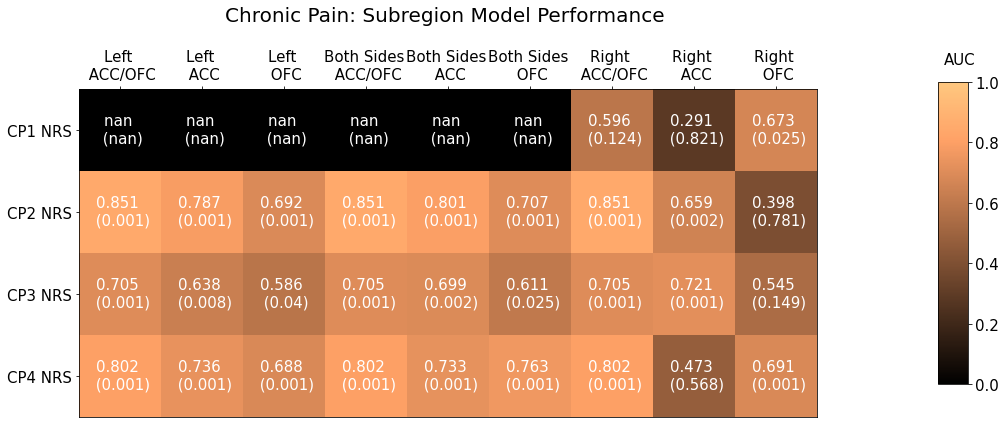

Working on... CP1 pain
CP1 acute right ofc/acc pain AUC: 0.47619 (p=0.384615)
CP1 acute right acc pain AUC: 0.738095 (p=0.045954)
CP1 acute right ofc pain AUC: 0.0714286 (p=0.883117)
Working on... CP2 pain
CP2 acute bilateral ofc/acc pain AUC: 0.833333 (p=0.018981)
CP2 acute bilateral acc pain AUC: 0.739583 (p=0.046953)
CP2 acute bilateral ofc pain AUC: 0.65625 (p=0.0859141)
CP2 acute left ofc/acc pain AUC: 0.833333 (p=0.00999001)
CP2 acute left acc pain AUC: 0.697917 (p=0.0719281)
CP2 acute left ofc pain AUC: 0.65625 (p=0.0939061)
CP2 acute right ofc/acc pain AUC: 0.833333 (p=0.010989)
CP2 acute right acc pain AUC: 0.697917 (p=0.0539461)
CP2 acute right ofc pain AUC: 0.270833 (p=0.757243)
Working on... CP3 pain
CP3 acute bilateral ofc/acc pain AUC: 0.493369 (p=0.432567)
CP3 acute bilateral acc pain AUC: 0.506631 (p=0.367632)
CP3 acute bilateral ofc pain AUC: 0.551724 (p=0.213786)
CP3 acute left ofc/acc pain AUC: 0.493369 (p=0.434565)
CP3 acute left acc pain AUC: 0.537135 (p=0.242757)


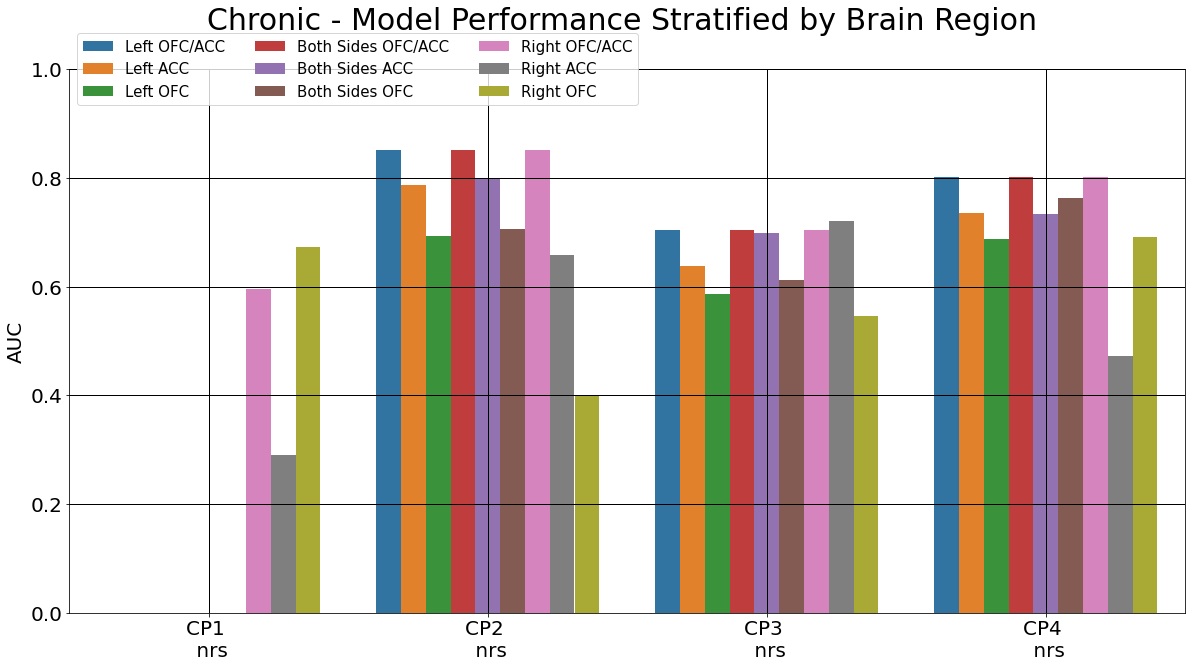

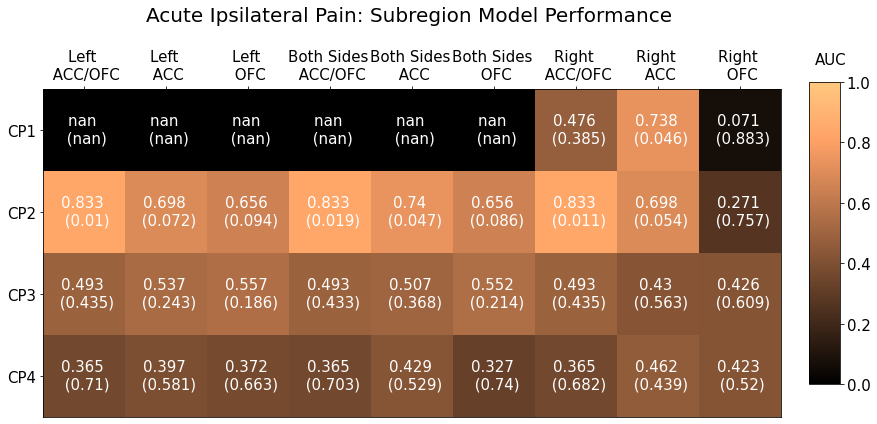

Working on... CP1 pain
CP1 acute right ofc/acc pain AUC: 0.384615 (p=0.441558)
CP1 acute right acc pain AUC: 0.410256 (p=0.380619)
CP1 acute right ofc pain AUC: 0.358974 (p=0.484515)
Working on... CP2 pain
CP2 acute bilateral ofc/acc pain AUC: 0.22619 (p=0.845155)
CP2 acute bilateral acc pain AUC: 0.297619 (p=0.715285)
CP2 acute bilateral ofc pain AUC: 0.309524 (p=0.712288)
CP2 acute left ofc/acc pain AUC: 0.22619 (p=0.828172)
CP2 acute left acc pain AUC: 0.047619 (p=0.948052)
CP2 acute left ofc pain AUC: 0.630952 (p=0.140859)
CP2 acute right ofc/acc pain AUC: 0.22619 (p=0.828172)
CP2 acute right acc pain AUC: 0.5 (p=0.308691)
CP2 acute right ofc pain AUC: 0.166667 (p=0.854146)
Working on... CP3 pain
CP3 acute bilateral ofc/acc pain AUC: 0.493369 (p=0.450549)
CP3 acute bilateral acc pain AUC: 0.506631 (p=0.392607)
CP3 acute bilateral ofc pain AUC: 0.551724 (p=0.213786)
CP3 acute left ofc/acc pain AUC: 0.493369 (p=0.444555)
CP3 acute left acc pain AUC: 0.537135 (p=0.234765)
CP3 acute le

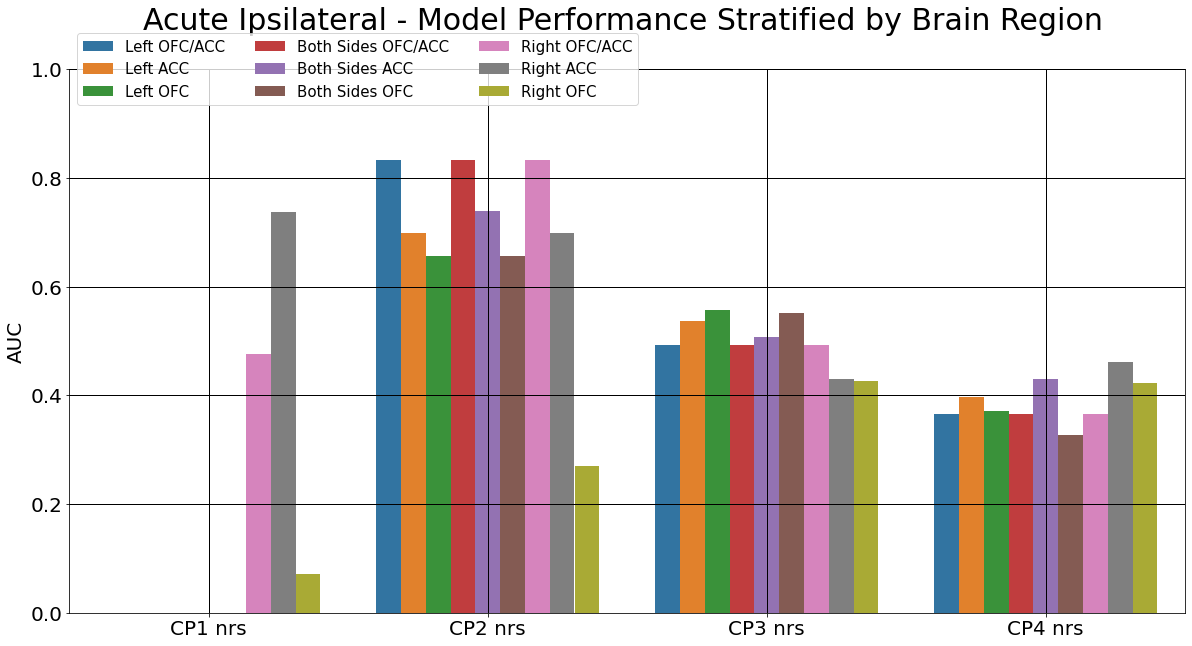

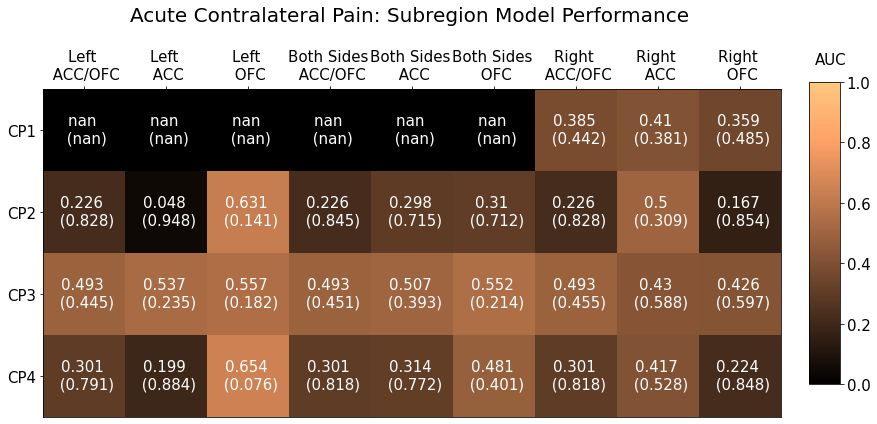

In [13]:
if PREDICT_TIME == True:
    pm = 'time_class'
    cp3_cp4_pms = [pm]

elif PREDICT_TIME == False and NRS_ONLY == True:
    cp3_cp4_pms = ['nrs']
elif PREDICT_TIME == False and NRS_ONLY == False:
    cp3_cp4_pms = ['unpvas', 'unpnrs', 'mpq', 'vas', 'nrs']
        
chronic_results, chronic_perm = classify_all_regions_and_hemispheres(_features=[cp1_chronic_features, cp2_chronic_features,
                                                cp3_chronic_features, cp4_chronic_features],
                                    _labels=[cp1_chronic_labels, cp2_chronic_labels,
                                            cp3_chronic_labels, cp4_chronic_labels],
                                    _pain_metrics=[['nrs'], ['nrs'],
                                                   cp3_cp4_pms, cp3_cp4_pms],
                                    _acute_or_chronic=['chronic']*4,
                                    _cp=['CP1', 'CP2', 'CP3', 'CP4'], n=1, plot_barplots=True,
                                    n_permutations=N_PERMUTATIONS,
                                    data_type = 'Chronic')

if PREDICT_TIME == False:
    ipsi_acute_results, ipsi_acute_perm = classify_all_regions_and_hemispheres(_features=[cp1_acute_ipsi_features, cp2_acute_ipsi_features,
                                                    cp3_acute_features, cp4_acute_ipsi_features],
                                        _labels=[cp1_acute_ipsi_labels, cp2_acute_ipsi_labels,
                                                cp3_acute_labels, cp4_acute_ipsi_labels],
                                        _pain_metrics=[['pain'], ['pain'],
                                                       ['pain'], ['pain']],
                                        _acute_or_chronic=['acute']*4,
                                        _cp=['CP1', 'CP2', 'CP3', 'CP4'], n=1, plot_barplots=True,
                                        n_permutations=N_PERMUTATIONS,
                                        data_type = 'Acute Ipsilateral')

    contra_acute_results, contra_acute_perm = classify_all_regions_and_hemispheres(_features=[cp1_acute_contra_features, cp2_acute_contra_features,
                                                    cp3_acute_features, cp4_acute_contra_features],
                                        _labels=[cp1_acute_contra_labels, cp2_acute_contra_labels,
                                                cp3_acute_labels, cp4_acute_contra_labels],
                                        _pain_metrics=[['pain'], ['pain'],
                                                       ['pain'], ['pain']],
                                        _acute_or_chronic=['acute']*4,
                                        _cp=['CP1', 'CP2', 'CP3', 'CP4'], n=1, plot_barplots=True,
                                        n_permutations=N_PERMUTATIONS,
                                        data_type = 'Acute Contralateral')

In [14]:
def plot_stratified_swarmplots(df, title, model_aucs, model_ps, classification, cp):
    plt.figure(figsize=(18, 6))
    ax = sns.swarmplot(data=df.melt(),
                      x='variable',
                      y='value',
                      s=3,
                      alpha=0.8)
    ax.set_xlabel('')
    plt.xticks(size=20, rotation=45)
    plt.yticks(size=20)
    if classification:
        ax.set_ylabel('AUC', size=25)
    else:
        ax.set_ylabel('rho', size=25)
    ax.set_ylim(0, 1.1)
    plt.title(title, size=25)
    plt.scatter('R ACC/OFC', model_aucs[0], marker='*', s=500, color='black')
    plt.scatter('R ACC', model_aucs[1], marker='*', s=500, color='black')
    plt.scatter('R OFC', model_aucs[2], marker='*', s=500, color='black')
    plt.text('R ACC/OFC', 1.05, 'p = {}'.format(np.round(model_ps[0], 3)), size=10, weight="bold")
    plt.text('R ACC', 1.05, 'p = {}'.format(np.round(model_ps[1], 3)), size=10, weight="bold")
    plt.text('R OFC', 1.05, 'p = {}'.format(np.round(model_ps[2], 3)), size=10, weight="bold")
    if cp != 'CP1':
        plt.scatter('B/L ACC/OFC', model_aucs[3], marker='*', s=500, color='black')
        plt.scatter('B/L ACC', model_aucs[4], marker='*', s=500, color='black')
        plt.scatter('B/L OFC', model_aucs[5], marker='*', s=500, color='black')
        plt.scatter('L ACC/OFC', model_aucs[6], marker='*', s=500, color='black')
        plt.scatter('L ACC', model_aucs[7], marker='*', s=500, color='black')
        plt.scatter('L OFC', model_aucs[8], marker='*', s=500, color='black')
        plt.text('B/L ACC/OFC', 1.05, 'p = {}'.format(np.round(model_ps[3], 3)), size=10, weight="bold")
        plt.text('B/L ACC', 1.05, 'p = {}'.format(np.round(model_ps[4], 3)), size=10, weight="bold")
        plt.text('B/L OFC', 1.05, 'p = {}'.format(np.round(model_ps[5], 3)), size=10, weight="bold")
        plt.text('L ACC/OFC', 1.05, 'p = {}'.format(np.round(model_ps[6], 3)), size=10, weight="bold")
        plt.text('L ACC', 1.05, 'p = {}'.format(np.round(model_ps[7], 3)), size=10, weight="bold")
        plt.text('L OFC', 1.05, 'p = {}'.format(np.round(model_ps[8], 3)), size=10, weight="bold")
    ax.plot()
    
    save_fp = BASE_PATH + 'pdf_figures/{}.pdf'.format(title)
    plt.savefig(save_fp, dpi=1000, format='pdf', bbox_inches = "tight")

In [15]:
chronic_results.to_csv(BASE_PATH + 'pcs_exports/subregion_chronic_results_classification.csv')
ipsi_acute_results.to_csv(BASE_PATH + 'pcs_exports/subregion_acute_ipsi_results_classification.csv')
contra_acute_results.to_csv(BASE_PATH + 'pcs_exports/subregion_acute_contra_results_classification.csv')

In [16]:
def extract_auc_and_p(results_df,
                      rows=['CP1 NRS', 'CP2 NRS', 'CP3 NRS', 'CP4 NRS']):
    
    all_aucs = []
    all_ps = []
    columns = ['Right ACC/OFC', 'Right ACC', 'Right OFC',
              'Both Sides ACC/OFC', 'Both Sides ACC', 'Both Sides OFC',
              'Left ACC/OFC', 'Left ACC', 'Left OFC']
    for r in rows:
        pt_aucs = []
        pt_ps = []
        for c in columns:
            cell = results_df.loc[r, c]
            if cell != 'nan':
                auc = cell.split(' ')[0]
                p = cell.split(' ')[1].split('p')[1].split('=')[1].split(')')[0].split('*')[0]
                pt_aucs.append(np.float(auc))
                pt_ps.append(np.float(p))
        all_aucs.append(pt_aucs)
        all_ps.append(pt_ps)
        
    return all_aucs, all_ps

In [17]:
# # CHRONIC SWARM PLOT

# if PREDICT_TIME == False:
#     all_model_aucs, all_model_ps = extract_auc_and_p(chronic_results)
    
# if chronic_results.shape[0] != 4:
#     chronic_results = chronic_results.iloc[[0, 1, 6, 11]]


# elif PREDICT_DIFFS == False and PREDICT_TIME == True:
#     print('null')


# try:
#     chronic_perm = pd.concat(chronic_perm)
# except:
#     chronic_perm = chronic_perm
    
# cnt = 0
# for cp in ['CP1', 'CP2', 'CP3', 'CP4']:
#     cp_perm_aucs = chronic_perm[chronic_perm['CP'] == cp]
#     cp_perm_aucs.drop(columns=['CP'], inplace=True)
#     if cp == 'CP1':
#         cp1_cols = [col for col in cp_perm_aucs.columns if 'R' in col]
#         cp_perm_aucs = cp_perm_aucs[cp1_cols]
#     model_aucs = all_model_aucs[cnt]
#     model_ps = all_model_ps[cnt]
#     title = '{} Chronic NRS Classification \n Permutation AUCS (n={})'.format(cp, N_PERMUTATIONS)
#     #plot_stratified_swarmplots(cp_perm_aucs, title, model_aucs, model_ps, classification=True, cp=cp)
#     cnt += 1

In [18]:
# # ACUTE IPSI SWARM PLOTS (AFFECTED SIDE)
# These are turned because they take a long time to plot!! (unless needed)

# all_model_aucs, all_model_ps = extract_auc_and_p(ipsi_acute_results,
#                                                 rows=['CP1 Acute', 'CP2 Acute', 'CP3 Acute', 'CP4 Acute'])


# cnt = 0
# acute_ipsi_perm = pd.concat(ipsi_acute_perm)
# for cp in ['CP1', 'CP2', 'CP3', 'CP4']:
#     cp_perm_aucs = acute_ipsi_perm[acute_ipsi_perm['CP'] == cp]
#     cp_perm_aucs.drop(columns='CP', inplace=True)
#     if cp == 'CP1':
#         cp1_cols = [col for col in cp_perm_aucs.columns if 'R' in col]
#         cp_perm_aucs = cp_perm_aucs[cp1_cols]
#     model_aucs = all_model_aucs[cnt]
#     model_ps = all_model_ps[cnt]
#     title = '{} Acute Ipsi NRS Classification \n Permutation AUCS (n={})'.format(cp, N_PERMUTATIONS)
#     #plot_stratified_swarmplots(cp_perm_aucs, title, model_aucs, model_ps, classification=True, cp=cp)
#     cnt += 1

In [19]:
# # ACUTE CONTRA SWARM PLOTS (UNAFFECTED SIDE)
# These are turned because they take a long time to plot!! (unless needed)

# all_model_aucs, all_model_ps = extract_auc_and_p(contra_acute_results,
#                                                 rows=['CP1 Acute', 'CP2 Acute', 'CP3 Acute', 'CP4 Acute'])

# cnt = 0
# acute_contra_perm = pd.concat(contra_acute_perm)
# for cp in ['CP1', 'CP2', 'CP3', 'CP4']:
#     cp_perm_aucs = acute_contra_perm[acute_contra_perm['CP'] == cp]
#     cp_perm_aucs.drop(columns='CP', inplace=True)
#     if cp == 'CP1':
#         cp1_cols = [col for col in cp_perm_aucs.columns if 'R' in col]
#         cp_perm_aucs = cp_perm_aucs[cp1_cols]
#     model_aucs = all_model_aucs[cnt]
#     model_ps = all_model_ps[cnt]
#     title = '{} Acute Contra NRS Classification \n Permutation AUCS (n={})'.format(cp, N_PERMUTATIONS)
#   #  plot_stratified_swarmplots(cp_perm_aucs, title, model_aucs, model_ps, classification=True, cp=cp)
#     cnt += 1

### LASSO REGRESSION

In [20]:
def prepare_x_y(X, Y, pain_metric, classify=True, CP='CP3', binarization='median'):
    X = sklearn.preprocessing.normalize(X, axis=0)
    X = np.array(X)
    y = Y[pain_metric]
    
    X = X[y.notna()]
    y = y[y.notna()]
    
    X, y = np.array(X), np.array(y)
    
    if PREDICT_DIFFS:
        y = Y[pain_metric]
        y = y[y.notna()]
        y = np.diff(y, axis=0)
        X = X[:-1, :]
    return X, y

def compute_optimal_metrics(preds, gts):

    tp, fp, tn, fn = conf_matrix(gts, preds)
    sens = tp / np.sum(gts)
    spec = tn / (len(gts) - np.sum(gts))
    ppv = tp / np.sum(preds)
    def cohen_d(x,y):
        return np.abs((np.mean(x) - np.mean(y)) / \
                np.sqrt((np.std(x, ddof=1) ** 2 + np.std(y, ddof=1) ** 2) / 2.0))
    
    d_prime = cohen_d(np.array(raw_preds)[preds == 0.0], np.array(raw_preds)[preds == 1.0])
    acc = (tp + tn) / len(gts)
    
    sens_lb, sens_ub = proportion_confint(tp, np.sum(gts), method='beta')
    spec_lb, spec_ub = proportion_confint(tn, len(gts) - np.sum(gts), method='beta')
    ppv_lb, ppv_ub = proportion_confint(tp, np.sum(preds), method='beta')
    acc_lb, acc_ub = proportion_confint(tp+tn, len(gts), method='beta')
    print('optimal threshold: {:.3f}'.format(optimal_thresh))
    print('sensitivity: {:.3f} ({:.3f}, {:.3f})'.format(sens, sens_lb, sens_ub))
    print('specificity: {:.3f} ({:.3f}, {:.3f})'.format(spec, spec_lb, spec_ub))
    print('ppv: {:.3f} ({:.3f}, {:.3f})'.format(ppv, ppv_lb, ppv_ub))
    print('cohens d: {:.3f}'.format(d_prime))
    print('accuracy: {:.3f} ({:.3f}, {:.3f})'.format(acc, acc_lb, acc_ub))
    
    return np.around([optimal_thresh,
                      sens, sens_lb, sens_ub,
                      spec, spec_lb, spec_ub,
                      ppv, ppv_lb, ppv_ub,
                      d_prime, acc, acc_lb, acc_ub], 3)

def plot_swarmplots(df, title, model_rhos, model_ps):
    plt.figure(figsize=(12, 6))
    ax = sns.swarmplot(data=df.melt(),
                      x='variable',
                      y='value',
                      s=3,
                      alpha=0.8)
    ax.set_xlabel('')
    plt.xticks(size=20)
    plt.yticks(size=20)
    ax.set_ylabel('rho', size=25)
    ax.set_ylim(-0.8, 1.2)
    plt.title(title, size=25)
    plt.scatter('CP1', model_rhos[0], marker='*', s=500, color='black')
    plt.scatter('CP2', model_rhos[1], marker='*', s=500, color='black')
    plt.scatter('CP3', model_rhos[2], marker='*', s=500, color='black')
    plt.scatter('CP4', model_rhos[3], marker='*', s=500, color='black')
    plt.text('CP1', 1.1, 'p = {}'.format(np.round(model_ps[0], 4)), size=12, weight="bold")
    plt.text('CP1', 1.00, 'rho = {}'.format(np.round(model_rhos[0], 3)), size=12, weight="bold")
    plt.text('CP2', 1.1, 'p = {}'.format(np.round(model_ps[1], 4)), size=12, weight="bold")
    plt.text('CP2', 1.00, 'rho = {}'.format(np.round(model_rhos[1], 3)), size=12, weight="bold")
    plt.text('CP3', 1.1, 'p = {}'.format(np.round(model_ps[2], 4)), size=12, weight="bold")
    plt.text('CP3', 1.00, 'rho = {}'.format(np.round(model_rhos[2], 3)), size=12, weight="bold")
    plt.text('CP4', 1.1, 'p = {}'.format(np.round(model_ps[3], 4)), size=12, weight="bold")
    plt.text('CP4', 1.00, 'rho = {}'.format(np.round(model_rhos[3], 3)), size=12, weight="bold")
    ax.plot()
    
    save_fp = BASE_PATH + 'pdf_figures/{}.pdf'.format(title)
    plt.savefig(save_fp, dpi=1000, format='pdf', bbox_inches = "tight")

def regress_pain(cp,
                 X,
                 Y,
                 pain_metric,
                 acute_or_chronic,
                 n_permutations=N_PERMUTATIONS,
                 side='bilateral ofc/acc',
                 save_preds_vs_gts=False,
                 compute_all_metrics=True,
                 save_lda_coefs=False,
                 accuracy_as_metric=False):
    
    X_, y_ = prepare_x_y(X, Y, pain_metric, CP=cp)
    if PREDICT_DIFFS:
        X = X[:-1]
        Y = Y[:-1]
    scaler = StandardScaler()
    X_ = scaler.fit_transform(X_)
    lwocv = windowed_loocv(X_, acute_or_chronic, cp=cp)
    preds = []
    gts = []
    lasso_coefs = []
    shap_values = []
    
    for train_idx, test_idx in lwocv:
        
        # Get train and test sets
        X_train, X_test = X_[train_idx], X_[test_idx]
        Y_train, Y_test = y_[train_idx], y_[test_idx]

        # Fit lasso
        np.random.seed(415)
        model = Lasso(alpha=1e-4, max_iter=1e4, tol=1e-4)
        model.fit(X_train, Y_train)
        preds.append(model.predict(X_test.reshape(1, -1)))
        gts.append(Y_test)

    gts = np.array(gts)
    preds = np.array(preds)[:, 0]
    model_rho = np.round(np.corrcoef(gts, preds)[0, 1], 3)
    model_r2 = r2_score(gts, preds)
    rmse =  mean_squared_error(gts, preds, squared=False)
    lasso_coefs.append(model.coef_)
    
    permutation_r2s = []
    permutation_rhos = []
    perm_inputs = range(n_permutations)
    
    
    def do_perm(i,X_, y_, acute_or_chronic):
        lwocv = windowed_loocv(X_, acute_or_chronic, cp=cp)
        np.random.shuffle(y_)
        perm_preds = []
        perm_gts = []
        for train_idx, test_idx in lwocv:
            X_train, X_test = X_[train_idx], X_[test_idx]
            Y_train, Y_test = y_[[train_idx]], y_[[test_idx]]
            model = Lasso(alpha=1e-4, max_iter=1e4, tol=1e-4)
            model.fit(X_train, Y_train)
            perm_preds.append(model.predict(X_test.reshape(1, -1)))
            perm_gts.append(Y_test)
        perm_gts = np.array(perm_gts)[:, 0]
        perm_preds = np.array(perm_preds)[:, 0]
        return [r2_score(perm_gts, perm_preds), np.corrcoef(perm_gts, perm_preds)[0, 1]]
    
    #Process the permutations in parallel
    num_cores = multiprocessing.cpu_count()
    results = Parallel(n_jobs=num_cores)(delayed(do_perm)(i,X_,y_,acute_or_chronic) for i in perm_inputs)
    permutation_r2s = [x[0] for x in results]
    permutation_rhos = [x[1] for x in results]
    p_val_k_r2 = sum(i > model_r2 for i in permutation_r2s)
    p_val_n_r2 = len(permutation_r2s)
    p_val_r2 = (p_val_k_r2+1) / (p_val_n_r2+1)
    
    p_val_k_rho = sum(i > model_rho for i in permutation_rhos)
    p_val_n_rho = len(permutation_rhos)
    p_val_rho = (p_val_k_rho+1) / (p_val_n_rho+1)
    
    model_r2 = np.around(model_r2, 3)
    p_val_r2 = np.around(p_val_r2, 3)
    model_rho = np.around(model_rho, 3)
    p_val_rho = np.around(p_val_rho, 3)
    rmse = np.around(rmse, 3)

    results = {'r-squared': ['{:g} ({:g})'.format(model_r2, p_val_r2)],
              'rho (p-val)': ['{:g} ({:g})'.format(model_rho, p_val_rho)],
              'rmse': ['{:g}'.format(rmse)]}
    if PREDICT_DIFFS:
        save_fp = BASE_PATH + 'pcs_exports/{}_{}_{}_LASSO_all_metrics_DIFFS.csv'.format(cp, acute_or_chronic, pain_metric)
    else:
        save_fp = BASE_PATH + 'pcs_exports/{}_{}_{}_LASSO_all_metrics.csv'.format(cp, acute_or_chronic, pain_metric)
    pd.DataFrame(results).to_csv(save_fp)
    
    if PREDICT_DIFFS:
        save_fp = BASE_PATH + 'pcs_exports/{}_{}_{}_LASSO_coefs_DIFFS.csv'.format(cp, acute_or_chronic, pain_metric)
    else:
        save_fp = BASE_PATH + 'pcs_exports/{}_{}_{}_LASSO_coefs.csv'.format(cp, acute_or_chronic, pain_metric)

    pd.DataFrame(np.vstack(lasso_coefs), columns=X.columns).to_csv(save_fp)

    print('{} {} {} {} r^2: {:g} (p={:g})'.format(cp, acute_or_chronic, side, pain_metric, model_r2, p_val_r2))
    print('{} {} {} {} rho: {:g} (p={:g})'.format(cp, acute_or_chronic, side, pain_metric, model_rho, p_val_rho))
    print('{} {} {} {} RMSE: {:g}'.format(cp, acute_or_chronic, side, pain_metric, rmse))
    return model_r2, permutation_r2s, p_val_r2, rmse 


In [21]:
# ### Full Model  NRS ONLY ###  
# TURNED OFF BECAUSE REDUNDANT WITH CODE BELOW, BUT HELPFUL FOR SANITY CHECK
# if NRS_ONLY == True:
#     cp3_cp4_pms = ['nrs']
# else:
#     cp3_cp4_pms = ['unpvas', 'unpnrs', 'mpq', 'vas', 'nrs']


# # CP1
# print('-' * 20 + ' CP1 ' + '-'*20)
# cp1_chronic_r, cp1_chronic_perm_r, cp1_chronic_p, cp1_chronic_rmse = regress_pain(
#     cp='CP1', X=cp1_chronic_features, Y=cp1_chronic_labels, save_preds_vs_gts=True,
#     pain_metric='nrs', acute_or_chronic='chronic', n_permutations=N_PERMUTATIONS)

# cp1_acute_ipsi_r, cp1_acute_ipsi_perm_r, cp1_acute_ipsi_p, cp1_acute_ipsi_rmse = regress_pain(
#     cp='CP1', X=cp1_acute_ipsi_features, Y=cp1_acute_ipsi_labels, save_preds_vs_gts=True,
#     pain_metric='pain', acute_or_chronic='acute_ipsi', n_permutations=N_PERMUTATIONS)

# cp1_acute_contra_r, cp1_acute_contra_perm_r, cp1_acute_contra_p, cp1_acute_contra_rmse = regress_pain(
#     cp='CP1', X=cp1_acute_contra_features, Y=cp1_acute_contra_labels, save_preds_vs_gts=True,
#     pain_metric='pain', acute_or_chronic='acute_contra', n_permutations=N_PERMUTATIONS)

# # CP2
# print('-' * 20 + ' CP2 ' + '-'*20)
# cp2_chronic_r, cp2_chronic_perm_r, cp2_chronic_p, cp2_chronic_rmse = regress_pain(
#     cp='CP2', X=cp2_chronic_features, Y=cp2_chronic_labels, save_preds_vs_gts=True,
#     pain_metric='nrs', acute_or_chronic='chronic', n_permutations=N_PERMUTATIONS)

# cp2_acute_ipsi_r, cp2_acute_ipsi_perm_r, cp2_acute_ipsi_p, cp2_acute_ipsi_rmse = regress_pain(
#     cp='CP2', X=cp2_acute_ipsi_features, Y=cp2_acute_ipsi_labels, save_preds_vs_gts=True,
#     pain_metric='pain', acute_or_chronic='acute_ipsi', n_permutations=N_PERMUTATIONS)

# cp2_acute_contra_r, cp2_acute_contra_perm_r, cp2_acute_contra_p, cp2_acute_contra_rmse = regress_pain(
#     cp='CP2', X=cp2_acute_contra_features, Y=cp2_acute_contra_labels, save_preds_vs_gts=True,
#     pain_metric='pain', acute_or_chronic='acute_contra', n_permutations=N_PERMUTATIONS)

# # CP3
# print('-' * 20 + ' CP3 ' + '-'*20)
# for pm in cp3_cp4_pms:
#     cp3_chronic_r, cp3_chronic_perm_r, cp3_chronic_p, cp3_chronic_rmse = regress_pain(
#         cp='CP3', X=cp3_chronic_features, Y=cp3_chronic_labels, save_preds_vs_gts=True,
#         pain_metric=pm, acute_or_chronic='chronic', n_permutations=N_PERMUTATIONS)
    
# cp3_acute_ipsi_r, cp3_acute_ipsi_perm_r, cp3_acute_ipsi_p, cp3_acute_ipsi_rmse = regress_pain(
#     cp='CP3', X=cp3_acute_ipsi_features, Y=cp3_acute_ipsi_labels, save_preds_vs_gts=True,
#     pain_metric='pain', acute_or_chronic='acute_ipsi', n_permutations=N_PERMUTATIONS)

# cp3_acute_contra_r, cp3_acute_contra_perm_r, cp3_acute_contra_p, cp3_acute_contra_rmse= regress_pain(
#     cp='CP3', X=cp3_acute_contra_features, Y=cp3_acute_contra_labels, save_preds_vs_gts=True,
#     pain_metric='pain', acute_or_chronic='acute_contra', n_permutations=N_PERMUTATIONS)
    
# # CP4
# print('-' * 20 + ' CP4 ' + '-'*20)
# for pm in cp3_cp4_pms:
#     cp4_chronic_r, cp4_chronic_perm_r, cp4_chronic_p, cp4_chronic_rmse  = regress_pain(
#         cp='CP4', X=cp4_chronic_features, Y=cp4_chronic_labels, save_preds_vs_gts=True,
#         pain_metric=pm, acute_or_chronic='chronic', n_permutations=N_PERMUTATIONS)

# cp4_acute_ipsi_r, cp4_acute_ipsi_perm_r, cp4_acute_ipsi_p, cp4_acute_ipsi_rmse = regress_pain(
#     cp='CP4', X=cp4_acute_ipsi_features, Y=cp4_acute_ipsi_labels, save_preds_vs_gts=True,
#     pain_metric='pain', acute_or_chronic='acute_ipsi', n_permutations=N_PERMUTATIONS)

# cp4_acute_contra_r, cp4_acute_contra_perm_r, cp4_acute_contra_p, cp4_acute_contra_rmse = regress_pain(
#     cp='CP4', X=cp4_acute_contra_features, Y=cp4_acute_contra_labels, save_preds_vs_gts=True,
#     pain_metric='pain', acute_or_chronic='acute_contra', n_permutations=N_PERMUTATIONS)

In [22]:
# # SAVE THE  CSV FOR ALL FULL MODEL - NRS REGRESSIONS 
# TURNED OFF BECAUSE REDUNDANT WITH CODE BELOW, BUT HELPFUL FOR SANITY CHECK

# if PREDICT_DIFFS == True and PREDICT_TIME == False: 

#     cp1_chronic_nrs_result = pd.read_csv(BASE_PATH + '/pcs_exports/CP1_chronic_nrs_LASSO_all_metrics_DIFFS.csv').iloc[:, 1:]
#     cp2_chronic_nrs_result = pd.read_csv(BASE_PATH + '/pcs_exports/CP2_chronic_nrs_LASSO_all_metrics_DIFFS.csv').iloc[:, 1:]
#     cp3_chronic_nrs_result = pd.read_csv(BASE_PATH + '/pcs_exports/CP3_chronic_nrs_LASSO_all_metrics_DIFFS.csv').iloc[:, 1:]
#     cp4_chronic_nrs_result = pd.read_csv(BASE_PATH + '/pcs_exports/CP4_chronic_nrs_LASSO_all_metrics_DIFFS.csv').iloc[:, 1:]

#     cp1_acute_contra_result = pd.read_csv(BASE_PATH + '/pcs_exports/CP1_acute_contra_pain_LASSO_all_metrics_DIFFS.csv').iloc[:, 1:]
#     cp2_acute_contra_result = pd.read_csv(BASE_PATH + '/pcs_exports/CP2_acute_contra_pain_LASSO_all_metrics_DIFFS.csv').iloc[:, 1:]
#     cp3_acute_contra_result = pd.read_csv(BASE_PATH + '/pcs_exports/CP3_acute_contra_pain_LASSO_all_metrics_DIFFS.csv').iloc[:, 1:]
#     cp4_acute_contra_result = pd.read_csv(BASE_PATH + '/pcs_exports/CP4_acute_contra_pain_LASSO_all_metrics_DIFFS.csv').iloc[:, 1:]

#     cp1_acute_ipsi_result = pd.read_csv(BASE_PATH + '/pcs_exports/CP1_acute_ipsi_pain_LASSO_all_metrics_DIFFS.csv').iloc[:, 1:]
#     cp2_acute_ipsi_result = pd.read_csv(BASE_PATH + '/pcs_exports/CP2_acute_ipsi_pain_LASSO_all_metrics_DIFFS.csv').iloc[:, 1:]
#     cp3_acute_ipsi_result = pd.read_csv(BASE_PATH + '/pcs_exports/CP3_acute_ipsi_pain_LASSO_all_metrics_DIFFS.csv').iloc[:, 1:]
#     cp4_acute_ipsi_result = pd.read_csv(BASE_PATH + '/pcs_exports/CP4_acute_ipsi_pain_LASSO_all_metrics_DIFFS.csv').iloc[:, 1:]

#     all_results = pd.concat([cp1_acute_contra_result, cp2_acute_contra_result, cp3_acute_contra_result, cp4_acute_contra_result,
#                          cp1_acute_ipsi_result, cp2_acute_ipsi_result, cp3_acute_ipsi_result, cp4_acute_ipsi_result,
#                          cp1_chronic_nrs_result, cp2_chronic_nrs_result, cp3_chronic_nrs_result, cp4_chronic_nrs_result])
#     result_idx = ['cp1 acute contra', 'cp2 acute contra', 'cp3 acute contra','cp4 acute contra',
#                 'cp1 acute ipsi', 'cp2_acute ipsi', 'cp3 acute ipsi', 'cp4 acute ipsi',
#                 'cp1 chronic nrs', 'cp2 chronic nrs', 'cp3 chronic nrs', 'cp4_chronic nrs']

#     if NRS_ONLY == False:
#         cp3_chronic_unpnrs_result = pd.read_csv(BASE_PATH + '/pcs_exports/CP3_chronic_unpnrs_LASSO_all_metrics_DIFFS.csv').iloc[:, 1:]
#         cp3_chronic_unpvas_result = pd.read_csv(BASE_PATH + '/pcs_exports/CP3_chronic_unpvas_LASSO_all_metrics_DIFFS.csv').iloc[:, 1:]
#         cp3_chronic_vas_result = pd.read_csv(BASE_PATH + '/pcs_exports/CP3_chronic_vas_LASSO_all_metrics_DIFFS.csv').iloc[:, 1:]
#         cp3_chronic_mpq_result = pd.read_csv(BASE_PATH + '/pcs_exports/CP3_chronic_mpq_LASSO_all_metrics_DIFFS.csv').iloc[:, 1:]

#         cp4_chronic_unpnrs_result = pd.read_csv(BASE_PATH + '/pcs_exports/CP4_chronic_unpnrs_LASSO_all_metrics_DIFFS.csv').iloc[:, 1:]
#         cp4_chronic_unpvas_result = pd.read_csv(BASE_PATH + '/pcs_exports/CP4_chronic_unpvas_LASSO_all_metrics_DIFFS.csv').iloc[:, 1:]
#         cp4_chronic_vas_result = pd.read_csv(BASE_PATH + '/pcs_exports/CP4_chronic_vas_LASSO_all_metrics_DIFFS.csv').iloc[:, 1:]
#         cp4_chronic_mpq_result = pd.read_csv(BASE_PATH + '/pcs_exports/CP4_chronic_mpq_LASSO_all_metrics_DIFFS.csv').iloc[:, 1:]

#         result_idx = result_idx + ['cp3 chronic unprs', 'cp4 chronic unprs', 'cp3 chronic unpvas',
#                                    'cp4 chronic unpvas', 'cp3 chronic vas', 'cp4 chronic vas',
#                                    'cp3 chronic mpq', 'cp4 chronic mpq']

#         all_results = pd.concat([all_results, cp3_chronic_unpnrs_result, cp4_chronic_unpnrs_result,
#                               cp3_chronic_unpvas_result, cp4_chronic_unpvas_result, cp3_chronic_vas_result,
#                               cp4_chronic_vas_result, cp3_chronic_mpq_result, cp4_chronic_mpq_result])
#     all_results.index = result_idx                        
#     all_results.to_csv(BASE_PATH + '/pcs_exports/full_models_all_metrics_results.csv')
#     all_results
    
# else:
#     if PREDICT_TIME == False:
#         cp1_chronic_nrs_result = pd.read_csv(BASE_PATH + '/pcs_exports/CP1_chronic_nrs_LASSO_all_metrics.csv').iloc[:, 1:]
#         cp2_chronic_nrs_result = pd.read_csv(BASE_PATH + '/pcs_exports/CP2_chronic_nrs_LASSO_all_metrics.csv').iloc[:, 1:]
#         cp3_chronic_nrs_result = pd.read_csv(BASE_PATH + '/pcs_exports/CP3_chronic_nrs_LASSO_all_metrics.csv').iloc[:, 1:]
#         cp4_chronic_nrs_result = pd.read_csv(BASE_PATH + '/pcs_exports/CP4_chronic_nrs_LASSO_all_metrics.csv').iloc[:, 1:]

#         cp1_acute_contra_result = pd.read_csv(BASE_PATH + '/pcs_exports/CP1_acute_contra_pain_LASSO_all_metrics.csv').iloc[:, 1:]
#         cp2_acute_contra_result = pd.read_csv(BASE_PATH + '/pcs_exports/CP2_acute_contra_pain_LASSO_all_metrics.csv').iloc[:, 1:]
#         cp3_acute_contra_result = pd.read_csv(BASE_PATH + '/pcs_exports/CP3_acute_contra_pain_LASSO_all_metrics.csv').iloc[:, 1:]
#         cp4_acute_contra_result = pd.read_csv(BASE_PATH + '/pcs_exports/CP4_acute_contra_pain_LASSO_all_metrics.csv').iloc[:, 1:]

#         cp1_acute_ipsi_result = pd.read_csv(BASE_PATH + '/pcs_exports/CP1_acute_ipsi_pain_LASSO_all_metrics.csv').iloc[:, 1:]
#         cp2_acute_ipsi_result = pd.read_csv(BASE_PATH + '/pcs_exports/CP2_acute_ipsi_pain_LASSO_all_metrics.csv').iloc[:, 1:]
#         cp3_acute_ipsi_result = pd.read_csv(BASE_PATH + '/pcs_exports/CP3_acute_ipsi_pain_LASSO_all_metrics.csv').iloc[:, 1:]
#         cp4_acute_ipsi_result = pd.read_csv(BASE_PATH + '/pcs_exports/CP4_acute_ipsi_pain_LASSO_all_metrics.csv').iloc[:, 1:]

#         all_results = pd.concat([cp1_acute_contra_result, cp2_acute_contra_result, cp3_acute_contra_result, cp4_acute_contra_result,
#                              cp1_acute_ipsi_result, cp2_acute_ipsi_result, cp3_acute_ipsi_result, cp4_acute_ipsi_result,
#                              cp1_chronic_nrs_result, cp2_chronic_nrs_result, cp3_chronic_nrs_result, cp4_chronic_nrs_result])
#         result_idx = ['cp1 acute contra', 'cp2 acute contra', 'cp3 acute contra','cp4 acute contra',
#                     'cp1 acute ipsi', 'cp2_acute ipsi', 'cp3 acute ipsi', 'cp4 acute ipsi',
#                     'cp1 chronic nrs', 'cp2 chronic nrs', 'cp3 chronic nrs', 'cp4_chronic nrs']

#         if NRS_ONLY == False:
#             cp3_chronic_unpnrs_result = pd.read_csv(BASE_PATH + '/pcs_exports/CP3_chronic_unpnrs_LASSO_all_metrics.csv').iloc[:, 1:]
#             cp3_chronic_unpvas_result = pd.read_csv(BASE_PATH + '/pcs_exports/CP3_chronic_unpvas_LASSO_all_metrics.csv').iloc[:, 1:]
#             cp3_chronic_vas_result = pd.read_csv(BASE_PATH + '/pcs_exports/CP3_chronic_vas_LASSO_all_metrics.csv').iloc[:, 1:]
#             cp3_chronic_mpq_result = pd.read_csv(BASE_PATH + '/pcs_exports/CP3_chronic_mpq_LASSO_all_metrics.csv').iloc[:, 1:]

#             cp4_chronic_unpnrs_result = pd.read_csv(BASE_PATH + '/pcs_exports/CP4_chronic_unpnrs_LASSO_all_metrics.csv').iloc[:, 1:]
#             cp4_chronic_unpvas_result = pd.read_csv(BASE_PATH + '/pcs_exports/CP4_chronic_unpvas_LASSO_all_metrics.csv').iloc[:, 1:]
#             cp4_chronic_vas_result = pd.read_csv(BASE_PATH + '/pcs_exports/CP4_chronic_vas_LASSO_all_metrics.csv').iloc[:, 1:]
#             cp4_chronic_mpq_result = pd.read_csv(BASE_PATH + '/pcs_exports/CP4_chronic_mpq_LASSO_all_metrics.csv').iloc[:, 1:]

#             result_idx = result_idx + ['cp3 chronic unprs', 'cp4 chronic unprs', 'cp3 chronic unpvas',
#                                        'cp4 chronic unpvas', 'cp3 chronic vas', 'cp4 chronic vas',
#                                        'cp3 chronic mpq', 'cp4 chronic mpq']

#             all_results = pd.concat([all_results, cp3_chronic_unpnrs_result, cp4_chronic_unpnrs_result,
#                                   cp3_chronic_unpvas_result, cp4_chronic_unpvas_result, cp3_chronic_vas_result,
#                                   cp4_chronic_vas_result, cp3_chronic_mpq_result, cp4_chronic_mpq_result])
#         all_results.index = result_idx                        
#         all_results.to_csv(BASE_PATH + '/pcs_exports/full_models_LASSO_all_metrics_results.csv')
#         all_results
        
# all_results

In [23]:
# # Full model swarm plots

# chronic_swarm_df = pd.DataFrame({'CP1': cp1_chronic_perm_r,
#                            'CP2': cp2_chronic_perm_r,
#                            'CP3': cp3_chronic_perm_r,
#                            'CP4': cp4_chronic_perm_r})


# acute_ipsi_swarm_df = pd.DataFrame({'CP1': cp1_acute_ipsi_perm_r,
#                                     'CP2': cp2_acute_ipsi_perm_r,
#                                     'CP3': cp3_acute_ipsi_perm_r,
#                                     'CP4': cp4_acute_ipsi_perm_r
#                                    })

# acute_contra_swarm_df = pd.DataFrame({'CP1': cp1_acute_contra_perm_r,
#                                     'CP2': cp2_acute_contra_perm_r,
#                                     'CP3': cp3_acute_contra_perm_r,
#                                     'CP4': cp4_acute_contra_perm_r
#                                    })


# # plot_swarmplots(chronic_swarm_df,
# #                 title='Full Model Chronic NRS Regression \n Permutation R2s (n={})'.format(N_PERMUTATIONS),
# #                 model_rhos=[cp1_chronic_r, cp2_chronic_r, cp3_chronic_r, cp4_chronic_r],
# #                 model_ps=[cp1_chronic_p, cp2_chronic_p, cp3_chronic_p, cp4_chronic_p])

# # plot_swarmplots(acute_ipsi_swarm_df,
# #                 title='Full Model Acute Ipsi NRS Regression \n Permutation R2s (n={})'.format(N_PERMUTATIONS),
# #                 model_rhos=[cp1_acute_ipsi_r, cp2_acute_ipsi_r, cp3_acute_ipsi_r, cp4_acute_ipsi_r],
# #                 model_ps=[cp1_acute_ipsi_p, cp2_acute_ipsi_p, cp3_acute_ipsi_p, cp4_acute_ipsi_p])

# # plot_swarmplots(acute_contra_swarm_df,
# #                 title='Full Model Acute Contra NRS Regression \n Permutation R2s (n={})'.format(N_PERMUTATIONS),
# #                  model_rhos=[cp1_acute_contra_r, cp2_acute_contra_r, cp3_acute_contra_r, cp4_acute_contra_r],
# #                  model_ps=[cp1_acute_contra_p, cp2_acute_contra_p, cp3_acute_contra_p, cp4_acute_contra_p])
    

In [24]:
def regress_all_regions_and_hemispheres(_features, _labels, _pain_metrics,
                                         _acute_or_chronic, data_type, _cp='CP2', n=2, plot_barplots=True,
                                         n_permutations=N_PERMUTATIONS):
    
    def is_significant(p_vals, alpha=0.05):
        sig = []
        for i in range(len(p_vals)):
            if p_vals[i] < alpha:
                sig.append('***')
            else:
                sig.append('')
        return sig

    data = {}
    data_p = {}
    data_rmse = {}
    rows_to_return = []
    perm_rhos_dfs = []
    auc_dfs = []
    for i in range(4):
        features = _features[i]
        labels = _labels[i]
        pain_metrics = _pain_metrics[i]
        acute_or_chronic = _acute_or_chronic[i]
        cp = _cp[i]
        for pm in pain_metrics:
            print('Working on... {} {}'.format(cp, pm))
            data[cp + ' ' + pm] = {}
            data_p[cp + ' ' + pm] = {}
            data_rmse[cp + ' ' + pm] = {}
            if cp != 'CP1':
                b_ofcacc_rho, b_ofcacc_prho, b_ofcacc_pval, b_ofcacc_rmse = regress_pain(cp=cp, X=features, Y=labels,
                                        pain_metric=pm, acute_or_chronic=acute_or_chronic, side='bilateral ofc/acc')
                b_acc_rho, b_acc_prho, b_acc_pval, b_acc_rmse = regress_pain(cp=cp, X=features[acc_cols], Y=labels,
                                         pain_metric=pm, acute_or_chronic=acute_or_chronic, side='bilateral acc')
                b_ofc_rho, b_ofc_prho, b_ofc_pval, b_ofc_rmse  = regress_pain(cp=cp, X=features[ofc_cols], Y=labels,
                                        pain_metric=pm, acute_or_chronic=acute_or_chronic, side='bilateral ofc')
                l_ofcacc_rho, l_ofcacc_prho, l_ofcacc_pval, l_ofcacc_rmse = regress_pain(cp=cp, X=features, Y=labels,
                                        pain_metric=pm, acute_or_chronic=acute_or_chronic, side='left ofc/acc')
                l_acc_rho, l_acc_prho, l_acc_pval, l_acc_rmse = regress_pain(cp=cp, X=features[left_acc_cols], Y=labels,
                                        pain_metric=pm, acute_or_chronic=acute_or_chronic, side='left acc')
                l_ofc_rho, l_ofc_prho, l_ofc_pval, l_ofc_rmse = regress_pain(cp=cp,  X=features[left_ofc_cols], Y=labels,
                                        pain_metric=pm, acute_or_chronic=acute_or_chronic, side='left ofc')
                _right_acc_cols = right_acc_cols
                _right_ofc_cols = right_ofc_cols
            
            elif cp == 'CP1':
                _right_acc_cols = [col for col in features if 'ofc' not in col]
                _right_ofc_cols = [col for col in features if 'acc' not in col]

            r_ofcacc_rho, r_ofcacc_prho, r_ofcacc_pval, r_ofcacc_rmse = regress_pain(cp=cp, X=features, Y=labels,
                                    pain_metric=pm, acute_or_chronic=acute_or_chronic, side='right ofc/acc')
            r_acc_rho, r_acc_prho, r_acc_pval, r_acc_rmse = regress_pain(cp=cp, X=features[_right_acc_cols], Y=labels,
                                    pain_metric=pm, acute_or_chronic=acute_or_chronic, side='right acc')
            r_ofc_rho, r_ofc_prho, r_ofc_pval, r_ofc_rmse = regress_pain(cp=cp, X=features[_right_ofc_cols], Y=labels,
                                    pain_metric=pm, acute_or_chronic=acute_or_chronic, side='right ofc')
        
            if cp != 'CP1':
            
                p_vals_corr = [l_ofcacc_pval, l_acc_pval, l_ofc_pval, r_ofcacc_pval,
                                   r_acc_pval, r_ofc_pval, b_ofcacc_pval, b_acc_pval, b_ofc_pval]
                sig = is_significant(p_vals_corr)
                row = ['{} (p={}{})'.format('{:g}'.format(l_ofcacc_rho), '{:g}'.format(p_vals_corr[0]), sig[0]), 
                   '{} (p={}{})'.format('{:g}'.format(l_acc_rho), '{:g}'.format(p_vals_corr[1]), sig[1]),
                   '{} (p={}{})'.format('{:g}'.format(l_ofc_rho), '{:g}'.format(p_vals_corr[2]), sig[2]),
                   '{} (p={}{})'.format('{:g}'.format(r_ofcacc_rho), '{:g}'.format(p_vals_corr[3]), sig[3]),
                   '{} (p={}{})'.format('{:g}'.format(r_acc_rho), '{:g}'.format(p_vals_corr[4]), sig[4]),
                   '{} (p={}{})'.format('{:g}'.format(r_ofc_rho), '{:g}'.format(p_vals_corr[5]), sig[5]),
                   '{} (p={}{})'.format('{:g}'.format(b_ofcacc_rho),'{:g}'.format( p_vals_corr[6]), sig[6]),
                   '{} (p={}{})'.format('{:g}'.format(b_acc_rho), '{:g}'.format(p_vals_corr[7]), sig[7]),
                   '{} (p={}{})'.format('{:g}'.format(b_ofc_rho), '{:g}'.format(p_vals_corr[8]), sig[8])]
                
                prho_df = pd.DataFrame({
                                       'B/L ACC/OFC': b_ofcacc_prho,
                                       'B/L ACC': b_acc_prho,
                                       'B/L OFC': b_ofc_prho,
                                       'L ACC/OFC': l_ofcacc_prho,
                                       'L ACC': l_acc_prho,
                                       'L OFC': l_ofc_prho,
                                       'R ACC/OFC': r_ofcacc_prho,
                                       'R ACC': r_acc_prho,
                                       'R OFC': r_ofc_prho,
                                       'CP': np.repeat(cp, N_PERMUTATIONS)
                                       })
                
                
                
                            
                l_ofcacc_pval = p_vals_corr[0]
                l_acc_pval = p_vals_corr[1]
                l_ofc_pval = p_vals_corr[2]
                r_ofcacc_pval = p_vals_corr[3]
                r_acc_pval = p_vals_corr[4]
                r_ofc_pval = p_vals_corr[5]
                b_ofcacc_pval = p_vals_corr[6]
                b_acc_pval = p_vals_corr[7]
                b_ofc_pval = p_vals_corr[8]
                
            elif cp == 'CP1':
                p_vals_corr = [r_ofcacc_pval, r_acc_pval, r_ofc_pval]
                sig = is_significant(p_vals_corr)
                row = [np.nan, np.nan, np.nan,
                       '{} (p={}{})'.format(r_ofcacc_rho, '{:g}'.format(p_vals_corr[0]), sig[0]),
                       '{} (p={}{})'.format(r_acc_rho, '{:g}'.format(p_vals_corr[1]), sig[1]),
                       '{} (p={}{})'.format(r_ofc_rho, '{:g}'.format(p_vals_corr[2]), sig[2]),
                       np.nan, np.nan, np.nan]
                prho_df = pd.DataFrame({
                       'R ACC/OFC': r_ofcacc_prho,
                       'R ACC': r_acc_prho,
                       'R OFC': r_ofc_prho,
                       'CP': np.repeat(cp, N_PERMUTATIONS)
                                       })
                
                
                r_ofcacc_pval = p_vals_corr[0]
                r_acc_pval = p_vals_corr[1]
                r_ofc_pval = p_vals_corr[2]     

            rows_to_return.append(row)
            perm_rhos_dfs.append(prho_df)
            if cp != 'CP1':
                data[cp + ' ' + pm]['Left OFC/ACC'], data_p[cp + ' ' + pm]['Left OFC/ACC'], data_rmse[cp + ' ' + pm]['Left OFC/ACC'] = l_ofcacc_rho, l_ofcacc_pval, l_ofcacc_rmse
                data[cp + ' ' + pm]['Left ACC'], data_p[cp + ' ' + pm]['Left ACC'], data_rmse[cp + ' ' + pm]['Left ACC'] = l_acc_rho, l_acc_pval, l_acc_rmse
                data[cp + ' ' + pm]['Left OFC'], data_p[cp + ' ' + pm]['Left OFC'], data_rmse[cp + ' ' + pm]['Left OFC'] = l_ofc_rho, l_ofc_pval, l_ofc_rmse
                data[cp + ' ' + pm]['Both Sides OFC/ACC'], data_p[cp + ' ' + pm]['Both Sides OFC/ACC'], data_rmse[cp + ' ' + pm]['Both Sides OFC/ACC'] = b_ofcacc_rho, b_ofcacc_pval, b_ofcacc_rmse
                data[cp + ' ' + pm]['Both Sides ACC'], data_p[cp + ' ' + pm]['Both Sides ACC'], data_rmse[cp + ' ' + pm]['Both Sides ACC'] = b_acc_rho, b_acc_pval, l_acc_rmse
                data[cp + ' ' + pm]['Both Sides OFC'], data_p[cp + ' ' + pm]['Both Sides OFC'], data_rmse[cp + ' ' + pm]['Both Sides OFC'] = b_ofc_rho, b_ofc_pval, l_ofc_rmse
            else:
                data[cp + ' ' + pm]['Left OFC/ACC'], data_p[cp + ' ' + pm]['Left OFC/ACC'], data_rmse[cp + ' ' + pm]['Left OFC/ACC'] = np.repeat(np.nan, n), np.repeat(np.nan, n), np.repeat(np.nan, n)
                data[cp + ' ' + pm]['Left ACC'], data_p[cp + ' ' + pm]['Left ACC'], data_rmse[cp + ' ' + pm]['Left ACC'] = np.repeat(np.nan, n), np.repeat(np.nan, n), np.repeat(np.nan, n)
                data[cp + ' ' + pm]['Left OFC'], data_p[cp + ' ' + pm]['Left OFC'], data_rmse[cp + ' ' + pm]['Left OFC'] = np.repeat(np.nan, n), np.repeat(np.nan, n), np.repeat(np.nan, n)
                data[cp + ' ' + pm]['Both Sides OFC/ACC'], data_p[cp + ' ' + pm]['Both Sides OFC/ACC'], data_rmse[cp + ' ' + pm]['Both Sides OFC/ACC'] = np.repeat(np.nan, n), np.repeat(np.nan, n), np.repeat(np.nan, n)
                data[cp + ' ' + pm]['Both Sides ACC'], data_p[cp + ' ' + pm]['Both Sides ACC'], data_rmse[cp + ' ' + pm]['Both Sides ACC'] = np.repeat(np.nan, n), np.repeat(np.nan, n), np.repeat(np.nan, n)
                data[cp + ' ' + pm]['Both Sides OFC'], data_p[cp + ' ' + pm]['Both Sides OFC'], data_rmse[cp + ' ' + pm]['Both Sides OFC'] = np.repeat(np.nan, n), np.repeat(np.nan, n), np.repeat(np.nan, n)
                
            data[cp + ' ' + pm]['Right OFC/ACC'], data_p[cp + ' ' + pm]['Right OFC/ACC'], data_rmse[cp + ' ' + pm]['Right OFC/ACC'] = r_ofcacc_rho, r_ofcacc_pval, r_ofcacc_rmse
            data[cp + ' ' + pm]['Right ACC'], data_p[cp + ' ' + pm]['Right ACC'], data_rmse[cp + ' ' + pm]['Right ACC'] = r_acc_rho, r_acc_pval, r_acc_rmse
            data[cp + ' ' + pm]['Right OFC'], data_p[cp + ' ' + pm]['Right OFC'], data_rmse[cp + ' ' + pm]['Right OFC']  = r_ofc_rho, r_ofc_pval, r_ofc_rmse

    if _acute_or_chronic[0] == 'chronic':
        cp1_nrs_data = pd.DataFrame(data['CP1 nrs'], index=np.arange(n))
        cp1_nrs_data['CP_PM'] = 'CP1 \n nrs'
        cp2_nrs_data = pd.DataFrame(data['CP2 nrs'], index=np.arange(n))
        cp2_nrs_data['CP_PM'] = 'CP2 \n nrs'
        cp3_nrs_data = pd.DataFrame(data['CP3 nrs'], index=np.arange(n))
        cp3_nrs_data['CP_PM'] = 'CP3 \n nrs'
        cp4_nrs_data = pd.DataFrame(data['CP4 nrs'], index=np.arange(n))
        cp4_nrs_data['CP_PM'] = 'CP4 \n nrs'
        
        cp1_nrs_data_p = pd.DataFrame(data_p['CP1 nrs'], index=np.arange(n))
        cp1_nrs_data_p['CP_PM'] = 'CP1 \n nrs'
        cp2_nrs_data_p = pd.DataFrame(data_p['CP2 nrs'], index=np.arange(n))
        cp2_nrs_data_p['CP_PM'] = 'CP2 \n nrs'
        cp3_nrs_data_p = pd.DataFrame(data_p['CP3 nrs'], index=np.arange(n))
        cp3_nrs_data_p['CP_PM'] = 'CP3 \n nrs'
        cp4_nrs_data_p = pd.DataFrame(data_p['CP4 nrs'], index=np.arange(n))
        cp4_nrs_data_p['CP_PM'] = 'CP4 \n nrs' 
        
        cp1_nrs_data_rmse = pd.DataFrame(data_rmse['CP1 nrs'], index=np.arange(n))
        cp1_nrs_data_rmse['CP_PM'] = 'CP1 \n nrs'
        cp2_nrs_data_rmse = pd.DataFrame(data_rmse['CP2 nrs'], index=np.arange(n))
        cp2_nrs_data_rmse['CP_PM'] = 'CP2 \n nrs'
        cp3_nrs_data_rmse = pd.DataFrame(data_rmse['CP3 nrs'], index=np.arange(n))
        cp3_nrs_data_rmse['CP_PM'] = 'CP3 \n nrs'
        cp4_nrs_data_rmse = pd.DataFrame(data_rmse['CP4 nrs'], index=np.arange(n))
        cp4_nrs_data_rmse['CP_PM'] = 'CP4 \n nrs'
        
        if NRS_ONLY == False:
            cp3_unpvas_data = pd.DataFrame(data['CP3 unpvas'], index=np.arange(n))
            cp3_unpvas_data['CP_PM'] = 'CP3 \n unpvas'
            cp3_unpnrs_data = pd.DataFrame(data['CP3 unpnrs'], index=np.arange(n))
            cp3_unpnrs_data['CP_PM'] = 'CP3 \n unpnrs'
            cp3_mpq_data = pd.DataFrame(data['CP3 mpq'], index=np.arange(n))
            cp3_mpq_data['CP_PM'] = 'CP3 \n mpq'
            cp3_vas_data = pd.DataFrame(data['CP3 vas'], index=np.arange(n))
            cp3_vas_data['CP_PM'] = 'CP3 \n vas'
            
            cp3_unpvas_data_p = pd.DataFrame(data_p['CP3 unpvas'], index=np.arange(n))
            cp3_unpvas_data_p['CP_PM'] = 'CP3 \n unpvas'
            cp3_unpnrs_data_p = pd.DataFrame(data_p['CP3 unpnrs'], index=np.arange(n))
            cp3_unpnrs_data_p['CP_PM'] = 'CP3 \n unpnrs'
            cp3_mpq_data_p = pd.DataFrame(data_p['CP3 mpq'], index=np.arange(n))
            cp3_mpq_data_p['CP_PM'] = 'CP3 \n mpq'
            cp3_vas_data_p = pd.DataFrame(data_p['CP3 vas'], index=np.arange(n))
            cp3_vas_data_p['CP_PM'] = 'CP3 \n vas'
            
            cp3_unpvas_data_rmse = pd.DataFrame(data_rmse['CP3 unpvas'], index=np.arange(n))
            cp3_unpvas_data_rmse['CP_PM'] = 'CP3 \n unpvas'
            cp3_unpnrs_data_rmse = pd.DataFrame(data_rmse['CP3 unpnrs'], index=np.arange(n))
            cp3_unpnrs_data_rmse['CP_PM'] = 'CP3 \n unpnrs'
            cp3_mpq_data_rmse = pd.DataFrame(data_rmse['CP3 mpq'], index=np.arange(n))
            cp3_mpq_data_rmse['CP_PM'] = 'CP3 \n mpq'
            cp3_vas_data_rmse = pd.DataFrame(data_rmse['CP3 vas'], index=np.arange(n))
            cp3_vas_data_rmse['CP_PM'] = 'CP3 \n vas'
            
            
            
            
            
            
            cp4_unpvas_data = pd.DataFrame(data['CP4 unpvas'], index=np.arange(n))
            cp4_unpvas_data['CP_PM'] = 'CP4 \n unpvas'
            cp4_unpnrs_data = pd.DataFrame(data['CP4 unpnrs'], index=np.arange(n))
            cp4_unpnrs_data['CP_PM'] = 'CP4 \n unpnrs'
            cp4_mpq_data = pd.DataFrame(data['CP4 mpq'], index=np.arange(n))
            cp4_mpq_data['CP_PM'] = 'CP4 \n mpq'
            cp4_vas_data = pd.DataFrame(data['CP4 vas'], index=np.arange(n))
            cp4_vas_data['CP_PM'] = 'CP4 \n vas'

            cp4_unpvas_data_p = pd.DataFrame(data_p['CP4 unpvas'], index=np.arange(n))
            cp4_unpvas_data_p['CP_PM'] = 'CP4 \n unpvas'
            cp4_unpnrs_data_p = pd.DataFrame(data_p['CP4 unpnrs'], index=np.arange(n))
            cp4_unpnrs_data_p['CP_PM'] = 'CP4 \n unpnrs'
            cp4_mpq_data_p = pd.DataFrame(data_p['CP4 mpq'], index=np.arange(n))
            cp4_mpq_data_p['CP_PM'] = 'CP4 \n mpq'
            cp4_vas_data_p = pd.DataFrame(data_p['CP4 vas'], index=np.arange(n))
            cp4_vas_data_p['CP_PM'] = 'CP4 \n vas'        
            
            cp4_unpvas_data_rmse = pd.DataFrame(data_rmse['CP4 unpvas'], index=np.arange(n))
            cp4_unpvas_data_rmse['CP_PM'] = 'CP4 \n unpvas'
            cp4_unpnrs_data_rmse = pd.DataFrame(data_rmse['CP4 unpnrs'], index=np.arange(n))
            cp4_unpnrs_data_rmse['CP_PM'] = 'CP4 \n unpnrs'
            cp4_mpq_data_rmse = pd.DataFrame(data_rmse['CP4 mpq'], index=np.arange(n))
            cp4_mpq_data_rmse['CP_PM'] = 'CP4 \n mpq'
            cp4_vas_data_rmse = pd.DataFrame(data_rmse['CP4 vas'], index=np.arange(n))
            cp4_vas_data_rmse['CP_PM'] = 'CP4 \n vas'      
        
        if NRS_ONLY:
            all_data = pd.concat([cp1_nrs_data, cp2_nrs_data, cp3_nrs_data, cp4_nrs_data])
            all_data_p = pd.concat([cp1_nrs_data_p, cp2_nrs_data_p, cp3_nrs_data_p, cp4_nrs_data_p])
        else:
            all_data = pd.concat([cp1_nrs_data, cp2_nrs_data,
                              cp3_nrs_data, cp4_nrs_data, cp3_vas_data, cp4_vas_data, cp3_unpnrs_data,
                              cp4_unpnrs_data, cp3_unpvas_data, cp4_unpvas_data, cp3_mpq_data, cp4_mpq_data])
            all_data_p = pd.concat([cp1_nrs_data_p, cp2_nrs_data_p,
                              cp3_nrs_data_p, cp4_nrs_data_p, cp3_vas_data_p, cp4_vas_data_p, cp3_unpnrs_data_p,
                              cp4_unpnrs_data_p, cp3_unpvas_data_p, cp4_unpvas_data_p, cp3_mpq_data_p, cp4_mpq_data_p])
            all_data_rmse = pd.concat([cp1_nrs_data_rmse, cp2_nrs_data_rmse,
                              cp3_nrs_data_rmse, cp4_nrs_data_rmse, cp3_vas_data_rmse, cp4_vas_data_rmse, cp3_unpnrs_data_rmse,
                              cp4_unpnrs_data_rmse, cp3_unpvas_data_rmse, cp4_unpvas_data_rmse, cp3_mpq_data_rmse, cp4_mpq_data_rmse])

            

            # NOW PLOT ALL RESULTS (R^2, p val RMSE) in HEATMAPS BELOW
            
        if NRS_ONLY:
            fig, ax = plt.subplots(figsize=(14, 6))
        else:
            fig, ax = plt.subplots(figsize=(16, 20))
        im = ax.imshow(np.nan_to_num(np.array(all_data.iloc[:, :-1], dtype=np.float64)),
                       cmap='copper', vmin=0, vmax=1)
        cbar = fig.colorbar(im, cax = fig.add_axes([1.01, 0.1, 0.03, 0.7]))
        cbar.ax.tick_params(labelsize=15) 
        cbar.set_label('R2', size=15, y=1.1, labelpad=-40, rotation=0)
        ax.set_xticks(np.arange(9))
        ax.set_xticklabels(['Left \n ACC/OFC', 'Left \n ACC', 'Left \n OFC',
                            'Both Sides \n ACC/OFC', 'Both Sides \n ACC', 'Both Sides \n OFC',
                            'Right \n ACC/OFC', 'Right \n ACC', 'Right \n OFC'
                            ], size=15)
        ax.xaxis.tick_top()
    
        if NRS_ONLY:
            ax.set_yticks(np.arange(4))
            ax.set_yticklabels(['CP1 NRS', 'CP2 NRS', 'CP3 NRS', 'CP4 NRS'], size=15)
            ax.set_ylim(4-0.5, -0.5)
        else:
            ax.set_yticks(np.arange(12))
            ax.set_yticklabels(['CP1 NRS', 'CP2 NRS', 'CP3 NRS', ' CP4 NRS', 'CP3 VAS','CP4 VAS', 'CP3 UNPNRS', 'CP4 UNPNRS', 
                                'CP3 UNPVAS', 'CP4 UNPVAS', 'CP3 MPQ', 'CP4 MPQ'], size=15)
            ax.set_ylim(12-0.5, -0.5)
        ax.set_title('Chronic Pain: LASSO REGRESSION Subregion Model Performance \n ', size=20)
        for i in range(all_data.shape[0]):
            for j in range(all_data.shape[1]):
                try:
                    text = ax.text(j, i, '{} \n {} \n ({})'.format(np.round(all_data.iloc[i, j], 3), np.round(all_data_rmse.iloc[i, j], 3), np.round(all_data_p.iloc[i, j], 3)), ha="center", va="center", color="w", size=10)
                    
                except:
                    continue
        plt.tight_layout()
        plt.show()
        fig.savefig(BASE_PATH + 'pdf_figures/' + data_type + '_regression_stratified_heatmaps.pdf', dpi=1000, format='pdf', bbox_inches='tight')
        
        cols_for_plotting = [c for c in all_data.columns if 'nrs' in c]
        if NRS_ONLY:
            data_long = pd.melt(all_data[all_data.CP_PM.str.contains('nrs')], id_vars='CP_PM')
        else:
            data_long = pd.melt(all_data, id_vars='CP_PM')
        data_long.rename(columns={'variable': 'Region', 'value': 'R^2'}, inplace=True)
        
        # FOR ACUTE DATA REGRESSIONS:
    elif _acute_or_chronic[0] == 'acute':
        cp1_acute_data = pd.DataFrame(data['CP1 pain'], index=np.arange(n))
        cp1_acute_data['CP_PM'] = 'CP1 nrs'
        cp2_acute_data = pd.DataFrame(data['CP2 pain'], index=np.arange(n))
        cp2_acute_data['CP_PM'] = 'CP2 nrs'
        cp3_acute_data = pd.DataFrame(data['CP3 pain'], index=np.arange(n))
        cp3_acute_data['CP_PM'] = 'CP3 nrs'
        cp4_acute_data = pd.DataFrame(data['CP4 pain'], index=np.arange(n))
        cp4_acute_data['CP_PM'] = 'CP4 nrs'
        
        cp1_acute_data_p = pd.DataFrame(data_p['CP1 pain'], index=np.arange(n))
        cp1_acute_data_p['CP_PM'] = 'CP1 nrs'
        cp2_acute_data_p = pd.DataFrame(data_p['CP2 pain'], index=np.arange(n))
        cp2_acute_data_p['CP_PM'] = 'CP2 nrs'
        cp3_acute_data_p = pd.DataFrame(data_p['CP3 pain'], index=np.arange(n))
        cp3_acute_data_p['CP_PM'] = 'CP3 nrs'
        cp4_acute_data_p = pd.DataFrame(data_p['CP4 pain'], index=np.arange(n))
        cp4_acute_data_p['CP_PM'] = 'CP4 nrs'
        
        cp1_acute_data_rmse = pd.DataFrame(data_rmse['CP1 pain'], index=np.arange(n))
        cp1_acute_data_rmse['CP_PM'] = 'CP1 nrs'
        cp2_acute_data_rmse = pd.DataFrame(data_rmse['CP2 pain'], index=np.arange(n))
        cp2_acute_data_rmse['CP_PM'] = 'CP2 nrs'
        cp3_acute_data_rmse = pd.DataFrame(data_rmse['CP3 pain'], index=np.arange(n))
        cp3_acute_data_rmse['CP_PM'] = 'CP3 nrs'
        cp4_acute_data_rmse = pd.DataFrame(data_rmse['CP4 pain'], index=np.arange(n))
        cp4_acute_data_rmse['CP_PM'] = 'CP4 nrs'
        
        
        
        all_data = pd.concat([cp1_acute_data, cp2_acute_data, cp3_acute_data, cp4_acute_data])
        all_data_p = pd.concat([cp1_acute_data_p, cp2_acute_data_p, cp3_acute_data_p, cp4_acute_data_p])
        all_data_rmse = pd.concat([cp1_acute_data_rmse, cp2_acute_data_rmse, cp3_acute_data_rmse, cp4_acute_data_rmse])
        
        fig, ax = plt.subplots(figsize=(14, 6))
        im = ax.imshow(np.nan_to_num(np.array(all_data.iloc[:, :-1], dtype=np.float64)), cmap='copper', vmin=0, vmax=1)
        cbar = fig.colorbar(im, cax = fig.add_axes([0.9, 0.1, 0.03, 0.7]))
        cbar.ax.tick_params(labelsize=15) 
        cbar.set_label('R2', size=15, y=1.1, labelpad=-40, rotation=0)
        ax.set_xticks(np.arange(9))
        ax.set_xticklabels(['Left \n ACC/OFC', 'Left \n ACC', 'Left \n OFC',
                            'Both Sides \n ACC/OFC', 'Both Sides \n ACC', 'Both Sides \n OFC',
                            'Right \n ACC/OFC', 'Right \n ACC', 'Right \n OFC'
                            ], size=15)
        ax.xaxis.tick_top()
        ax.set_yticks(np.arange(4))
        ax.set_yticklabels(['CP1', 'CP2', 'CP3', 'CP4'], size=15)
        ax.set_ylim(4-0.5, -0.5)
        ax.set_title('{} Pain: Subregion Model Performance \n '.format(data_type), size=20)
        for i in range(all_data.shape[0]):
            for j in range(all_data.shape[1]-1):
                text = ax.text(j, i, '{} \n {} \n({})'.format(np.round(all_data.iloc[i, j], 3), np.round(all_data_rmse.iloc[i, j], 3), np.round(all_data_p.iloc[i, j], 3)), ha="center", va="center", color="w", size=10)
        plt.tight_layout()
        plt.show()
        fig.savefig(BASE_PATH + 'pdf_figures/' + data_type + '_regression_stratified_heatmaps.pdf', dpi=1000, format='pdf', bbox_inches='tight')
        
        data_long = pd.melt(all_data, id_vars='CP_PM')
        data_long.rename(columns={'variable': 'Region', 'value': 'R^2'}, inplace=True)
        
    fig, ax = plt.subplots(figsize=(20, 10))
    g = sns.barplot(x='CP_PM', y='R^2', hue='Region', data=data_long, ci=None)
    ax.set_facecolor('white')
    ax.tick_params(labelsize=20)
    ax.set_xlabel('')
    ax.yaxis.label.set_size(20)
    ax.set_ylim(0, 1)
    ax.legend(ncol=3, prop={'size': 15}, bbox_to_anchor=(0, 1.08), loc='upper left')
    ax.grid(color='black', linestyle='-', linewidth=1)
    ax.set_title('{} - Model Performance Stratified by Brain Region \n'.format(data_type), fontsize=30)
    fig.savefig(BASE_PATH + 'pdf_figures/' + data_type + '_regression_stratified_barplots.pdf', dpi=1000, format='pdf', bbox_inches = "tight")
    
    if  _acute_or_chronic[0] == 'chronic' and NRS_ONLY == False:
        df_idx = ['CP1 NRS', 'CP2 NRS', 'CP3 NRS', ' CP4 NRS', 'CP3 VAS','CP4 VAS',
                  'CP3 UNPNRS', 'CP4 UNPNRS', 'CP3 UNPVAS', 'CP4 UNPVAS', 'CP3 MPQ', 'CP4 MPQ']
    elif _acute_or_chronic[0] == 'chronic' and NRS_ONLY == True:
        df_idx = ['CP1 NRS', 'CP2 NRS', 'CP3 NRS', 'CP4 NRS']
    else:
        df_idx = ['CP1 Acute', 'CP2 Acute', 'CP3 Acute', 'CP4 Acute']
    return pd.DataFrame(np.vstack(np.array(rows_to_return)), columns=['Left ACC/OFC', 'Left ACC', 'Left OFC', 'Right ACC/OFC', 'Right ACC', 'Right OFC','Both Sides ACC/OFC', 'Both Sides ACC', 'Both Sides OFC'], index=df_idx), perm_rhos_dfs

Working on... CP1 nrs
CP1 chronic right ofc/acc nrs r^2: -0.106 (p=0.067)
CP1 chronic right ofc/acc nrs rho: 0.25 (p=0.059)
CP1 chronic right ofc/acc nrs RMSE: 1.156
CP1 chronic right acc nrs r^2: -0.226 (p=0.816)
CP1 chronic right acc nrs rho: -0.184 (p=0.704)
CP1 chronic right acc nrs RMSE: 1.217
CP1 chronic right ofc nrs r^2: -0.017 (p=0.048)
CP1 chronic right ofc nrs rho: 0.228 (p=0.04)
CP1 chronic right ofc nrs RMSE: 1.108
Working on... CP2 nrs
CP2 chronic bilateral ofc/acc nrs r^2: 0.013 (p=0.001)
CP2 chronic bilateral ofc/acc nrs rho: 0.322 (p=0.001)
CP2 chronic bilateral ofc/acc nrs RMSE: 0.732
CP2 chronic bilateral acc nrs r^2: 0.071 (p=0.002)
CP2 chronic bilateral acc nrs rho: 0.325 (p=0.002)
CP2 chronic bilateral acc nrs RMSE: 0.71
CP2 chronic bilateral ofc nrs r^2: 0.025 (p=0.002)
CP2 chronic bilateral ofc nrs rho: 0.247 (p=0.004)
CP2 chronic bilateral ofc nrs RMSE: 0.727
CP2 chronic left ofc/acc nrs r^2: 0.013 (p=0.001)
CP2 chronic left ofc/acc nrs rho: 0.322 (p=0.001)
CP2

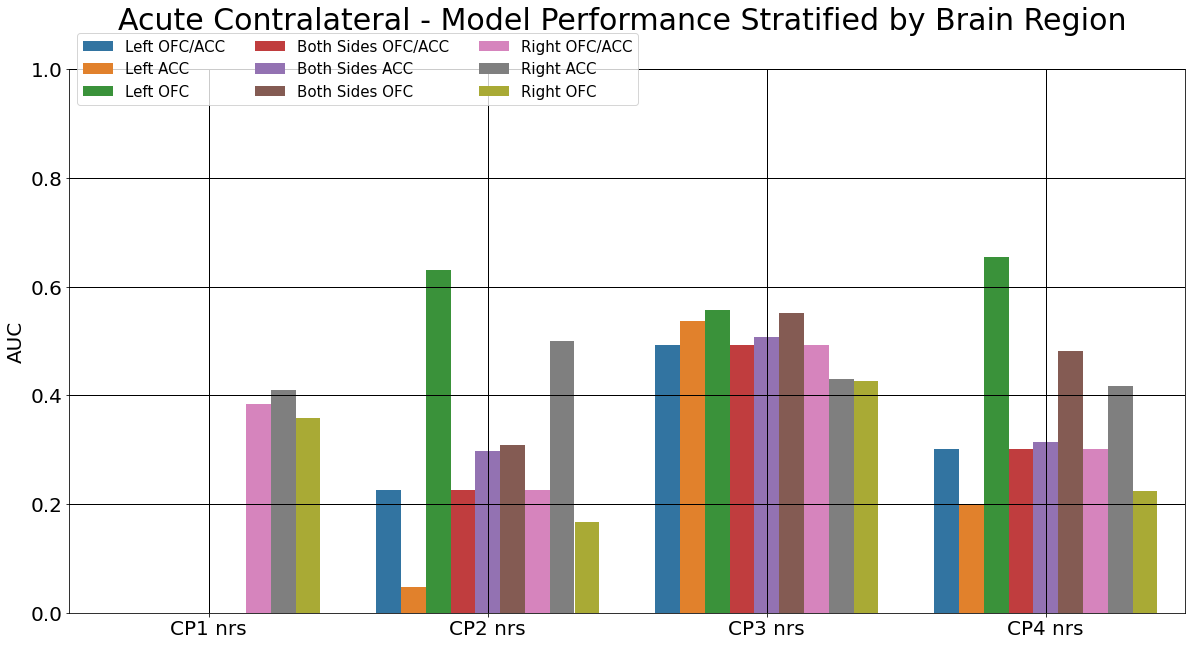

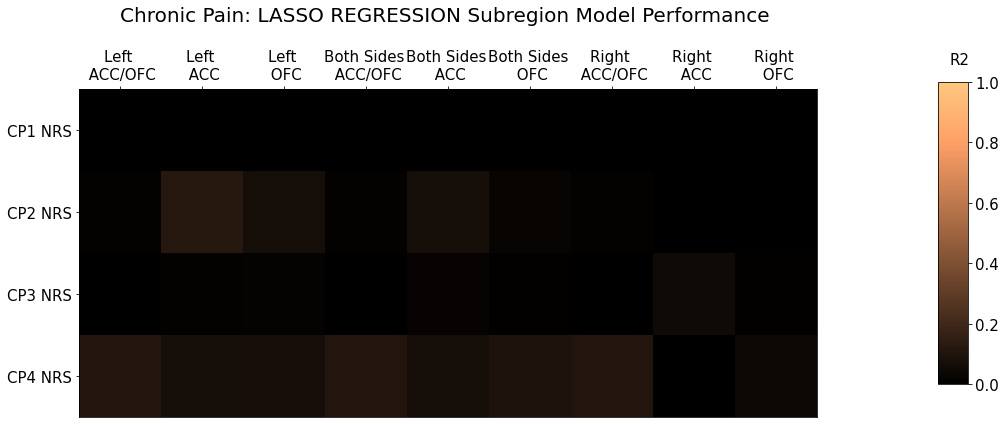

Working on... CP1 pain
CP1 acute right ofc/acc pain r^2: -1.947 (p=0.278)
CP1 acute right ofc/acc pain rho: 0.254 (p=0.388)
CP1 acute right ofc/acc pain RMSE: 5.351
CP1 acute right acc pain r^2: -0.945 (p=0.252)
CP1 acute right acc pain rho: 0.292 (p=0.2)
CP1 acute right acc pain RMSE: 4.348
CP1 acute right ofc pain r^2: -3.109 (p=0.79)
CP1 acute right ofc pain rho: -0.55 (p=0.916)
CP1 acute right ofc pain RMSE: 6.319
Working on... CP2 pain
CP2 acute bilateral ofc/acc pain r^2: -1.571 (p=0.305)
CP2 acute bilateral ofc/acc pain rho: 0.31 (p=0.241)
CP2 acute bilateral ofc/acc pain RMSE: 4.754
CP2 acute bilateral acc pain r^2: -0.086 (p=0.03)
CP2 acute bilateral acc pain rho: 0.495 (p=0.056)
CP2 acute bilateral acc pain RMSE: 3.089
CP2 acute bilateral ofc pain r^2: -2.24 (p=0.417)
CP2 acute bilateral ofc pain rho: -0.057 (p=0.584)
CP2 acute bilateral ofc pain RMSE: 5.337
CP2 acute left ofc/acc pain r^2: -1.571 (p=0.307)
CP2 acute left ofc/acc pain rho: 0.31 (p=0.225)
CP2 acute left ofc/ac

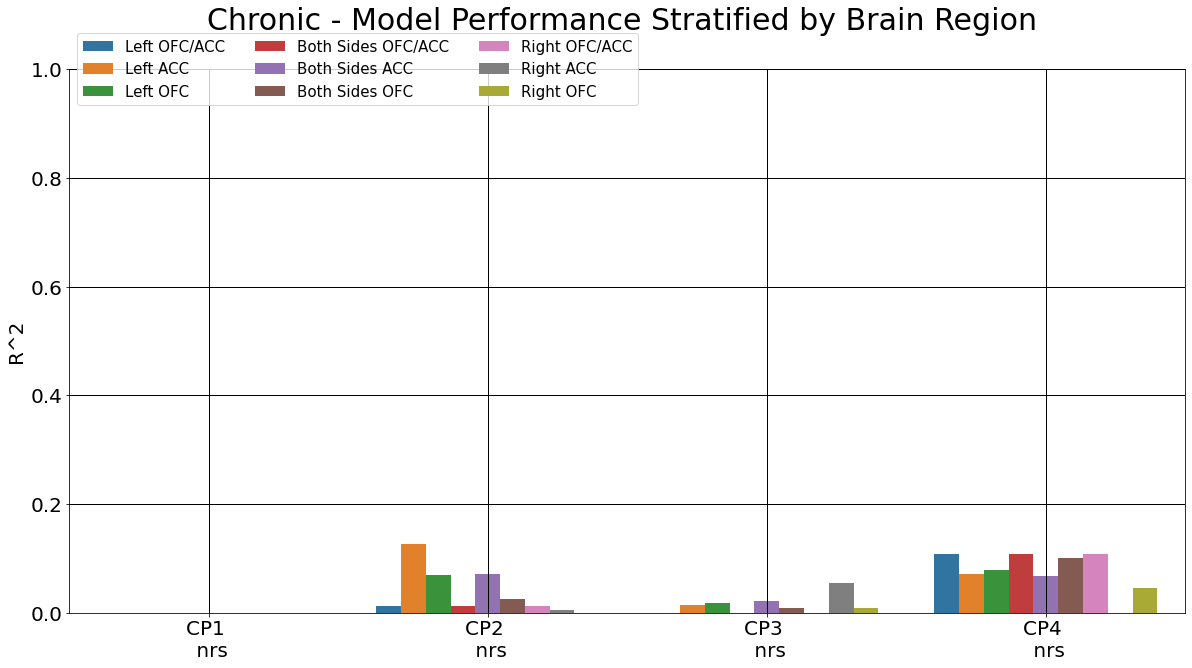

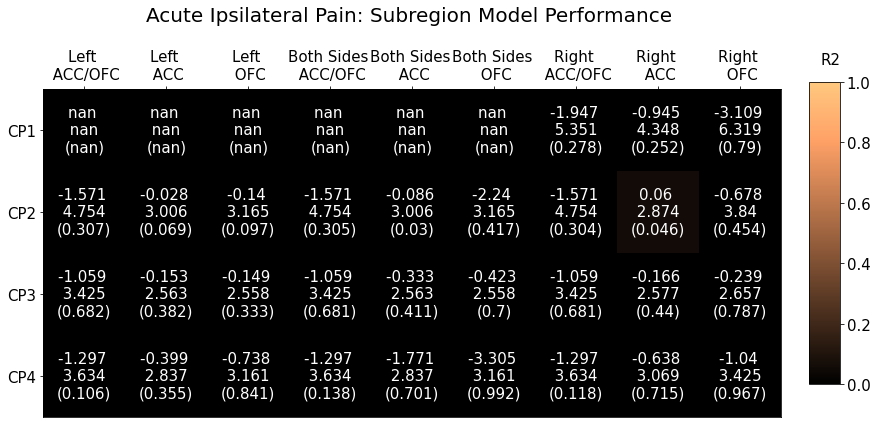

Working on... CP1 pain
CP1 acute right ofc/acc pain r^2: -42.036 (p=0.886)
CP1 acute right ofc/acc pain rho: -0.084 (p=0.671)
CP1 acute right ofc/acc pain RMSE: 12.951
CP1 acute right acc pain r^2: -0.464 (p=0.123)
CP1 acute right acc pain rho: 0.199 (p=0.136)
CP1 acute right acc pain RMSE: 2.389
CP1 acute right ofc pain r^2: -0.752 (p=0.281)
CP1 acute right ofc pain rho: 0.018 (p=0.352)
CP1 acute right ofc pain RMSE: 2.613
Working on... CP2 pain
CP2 acute bilateral ofc/acc pain r^2: -3.772 (p=0.519)
CP2 acute bilateral ofc/acc pain rho: 0.249 (p=0.297)
CP2 acute bilateral ofc/acc pain RMSE: 6.497
CP2 acute bilateral acc pain r^2: 0.01 (p=0.034)
CP2 acute bilateral acc pain rho: 0.607 (p=0.034)
CP2 acute bilateral acc pain RMSE: 2.96
CP2 acute bilateral ofc pain r^2: -1.273 (p=0.204)
CP2 acute bilateral ofc pain rho: 0.16 (p=0.331)
CP2 acute bilateral ofc pain RMSE: 4.485
CP2 acute left ofc/acc pain r^2: -3.772 (p=0.527)
CP2 acute left ofc/acc pain rho: 0.249 (p=0.29)
CP2 acute left of

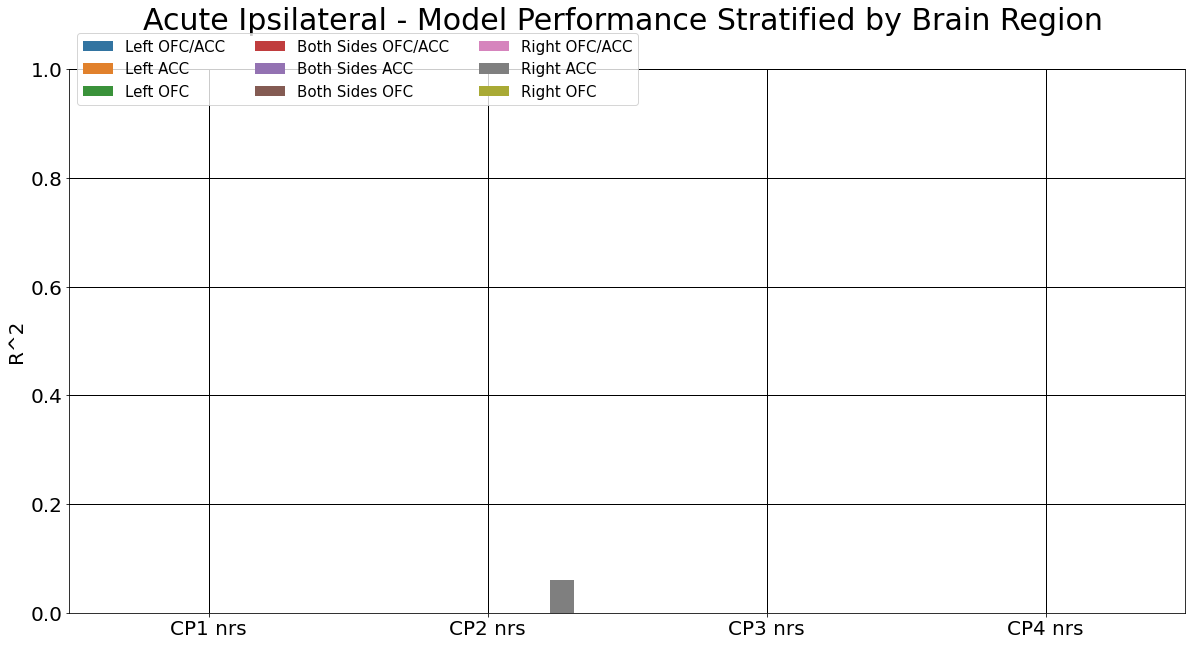

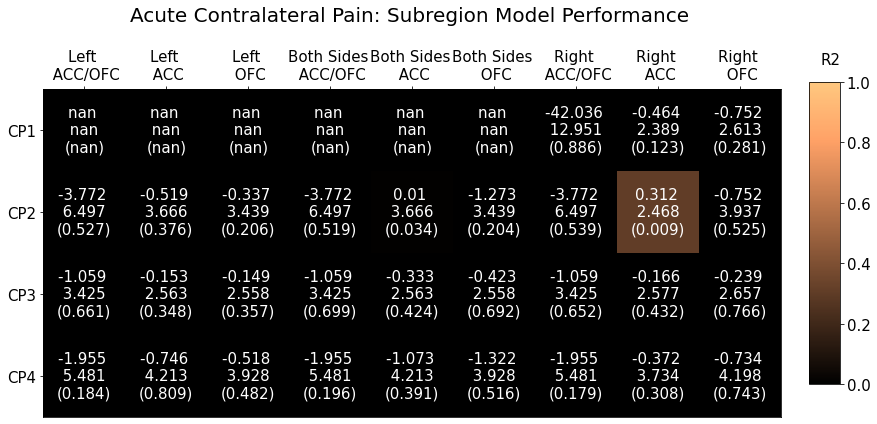

In [25]:
if PREDICT_TIME == True:
    pm = 'time_class'
    cp3_cp4_pms = [pm]

elif PREDICT_TIME == False and NRS_ONLY == True:
    cp3_cp4_pms = ['nrs']
elif PREDICT_TIME == False and NRS_ONLY == False:
    cp3_cp4_pms = ['unpvas', 'unpnrs', 'mpq', 'vas', 'nrs']
        
chronic_results, chronic_perm = regress_all_regions_and_hemispheres(_features=[cp1_chronic_features, cp2_chronic_features,
                                                cp3_chronic_features, cp4_chronic_features],
                                    _labels=[cp1_chronic_labels, cp2_chronic_labels,
                                            cp3_chronic_labels, cp4_chronic_labels],
                                    _pain_metrics=[['nrs'], ['nrs'],
                                                   cp3_cp4_pms, cp3_cp4_pms],
                                    _acute_or_chronic=['chronic']*4,
                                    _cp=['CP1', 'CP2', 'CP3', 'CP4'], n=1, plot_barplots=True,
                                    n_permutations=N_PERMUTATIONS,
                                    data_type = 'Chronic')

if PREDICT_TIME == False:
    ipsi_acute_results, ipsi_acute_perm = regress_all_regions_and_hemispheres(_features=[cp1_acute_ipsi_features, cp2_acute_ipsi_features,
                                                    cp3_acute_features, cp4_acute_ipsi_features],
                                        _labels=[cp1_acute_ipsi_labels, cp2_acute_ipsi_labels,
                                                cp3_acute_labels, cp4_acute_ipsi_labels],
                                        _pain_metrics=[['pain'], ['pain'],
                                                       ['pain'], ['pain']],
                                        _acute_or_chronic=['acute']*4,
                                        _cp=['CP1', 'CP2', 'CP3', 'CP4'], n=1, plot_barplots=True,
                                        n_permutations=N_PERMUTATIONS,
                                        data_type = 'Acute Ipsilateral')

    contra_acute_results, contra_acute_perm = regress_all_regions_and_hemispheres(_features=[cp1_acute_contra_features, cp2_acute_contra_features,
                                                    cp3_acute_features, cp4_acute_contra_features],
                                        _labels=[cp1_acute_contra_labels, cp2_acute_contra_labels,
                                                cp3_acute_labels, cp4_acute_contra_labels],
                                        _pain_metrics=[['pain'], ['pain'],
                                                       ['pain'], ['pain']],
                                        _acute_or_chronic=['acute']*4,
                                        _cp=['CP1', 'CP2', 'CP3', 'CP4'], n=1, plot_barplots=True,
                                        n_permutations=N_PERMUTATIONS,
                                        data_type = 'Acute Contralateral')

In [26]:
#Export Regression Results to CSV
chronic_results.to_csv(BASE_PATH + 'pcs_exports/subregion_chronic_results_regression.csv')
ipsi_acute_results.to_csv(BASE_PATH + 'pcs_exports/subregion_acute_ipsi_results_regression.csv')
contra_acute_results.to_csv(BASE_PATH + 'pcs_exports/subregion_acute_contra_results_regression.csv')

In [27]:
def plot_stratified_swarmplots(df, title, model_rhos, model_ps, cp):
    plt.figure(figsize=(18, 6))
    ax = sns.swarmplot(data=df.melt(),
                      x='variable',
                      y='value',
                      s=3,
                      alpha=0.8)
    ax.set_xlabel('')
    plt.xticks(size=20, rotation=45)
    plt.yticks(size=20)
    ax.set_ylabel('rho', size=25)
    ax.set_ylim(-0.8, 1.1)
    plt.title(title, size=25)
    plt.scatter('R ACC/OFC', model_rhos[0], marker='*', s=500, color='black')
    plt.scatter('R ACC', model_rhos[1], marker='*', s=500, color='black')
    plt.scatter('R OFC', model_rhos[2], marker='*', s=500, color='black')
    plt.text('R ACC/OFC', 1.05, 'p = {}'.format(np.round(model_ps[0], 4)), size=10, weight="bold")
    plt.text('R ACC', 1.05, 'p = {}'.format(np.round(model_ps[1], 4)), size=10, weight="bold")
    plt.text('R OFC', 1.05, 'p = {}'.format(np.round(model_ps[2], 4)), size=10, weight="bold")
    if cp != 'CP1':
        plt.scatter('B/L ACC/OFC', model_rhos[3], marker='*', s=500, color='black')
        plt.scatter('B/L ACC', model_rhos[4], marker='*', s=500, color='black')
        plt.scatter('B/L OFC', model_rhos[5], marker='*', s=500, color='black')
        plt.scatter('L ACC/OFC', model_rhos[6], marker='*', s=500, color='black')
        plt.scatter('L ACC', model_rhos[7], marker='*', s=500, color='black')
        plt.scatter('L OFC', model_rhos[8], marker='*', s=500, color='black')
        plt.text('B/L ACC/OFC', 1.05, 'p = {}'.format(np.round(model_ps[3], 4)), size=10, weight="bold")
        plt.text('B/L ACC', 1.05, 'p = {}'.format(np.round(model_ps[4], 4)), size=10, weight="bold")
        plt.text('B/L OFC', 1.05, 'p = {}'.format(np.round(model_ps[5], 4)), size=10, weight="bold")
        plt.text('L ACC/OFC', 1.05, 'p = {}'.format(np.round(model_ps[6], 4)), size=10, weight="bold")
        plt.text('L ACC', 1.05, 'p = {}'.format(np.round(model_ps[7], 4)), size=10, weight="bold")
        plt.text('L OFC', 1.05, 'p = {}'.format(np.round(model_ps[8], 4)), size=10, weight="bold")
    ax.plot()
    plt.show()
    save_fp = BASE_PATH + 'pdf_figures/{}.pdf'.format(title)
    plt.savefig(save_fp, dpi=200, format='pdf', bbox_inches = "tight")

    
    
def extract_rho_and_p(results_df,
                      rows=['CP1 NRS', 'CP2 NRS', 'CP3 NRS', 'CP4 NRS']):
    
    all_rhos = []
    all_ps = []
    columns = ['Right ACC/OFC', 'Right ACC', 'Right OFC',
              'Both Sides ACC/OFC', 'Both Sides ACC', 'Both Sides OFC',
              'Left ACC/OFC', 'Left ACC', 'Left OFC']
    for r in rows:
        pt_rhos = []
        pt_ps = []
        for c in columns:
            cell = results_df.loc[r, c]
            if cell != 'nan':
                rho = cell.split(' ')[0]
                p = cell.split(' ')[1].split('p')[1].split('=')[1].split(')')[0].split('*')[0]
                pt_rhos.append(np.float(rho))
                pt_ps.append(np.float(p))
        all_rhos.append(pt_rhos)
        all_ps.append(pt_ps)
        
    return all_rhos, all_ps    
    
    

if PREDICT_TIME == False:
    all_model_rhos, all_model_ps = extract_rho_and_p(chronic_results)


if chronic_results.shape[0] != 4:
    chronic_results = chronic_results.iloc[[0, 1, 6, 11]]

elif PREDICT_DIFFS == False and PREDICT_TIME == True:
    print('null')

try:
    chronic_perm = pd.concat(chronic_perm)
except:
    chronic_perm = chronic_perm
    
# cnt = 0
# for cp in ['CP1', 'CP2', 'CP3', 'CP4']:
#     cp_perm_rhos = chronic_perm[chronic_perm['CP'] == cp]
#     cp_perm_rhos.drop(columns=['CP'], inplace=True)
#     if cp == 'CP1':
#         cp1_cols = [col for col in cp_perm_rhos.columns if 'R' in col]
#         cp_perm_rhos = cp_perm_rhos[cp1_cols]
#     model_rhos = all_model_rhos[cnt]
#     model_ps = all_model_ps[cnt]
#     title = '{} Chronic NRS Regression \n Permutation R2s (n={})'.format(cp, N_PERMUTATIONS)
#     #plot_stratified_swarmplots(cp_perm_rhos, title, model_rhos, model_ps, cp=cp)
#     cnt += 1

In [28]:
# all_model_rhos, all_model_ps = extract_rho_and_p(ipsi_acute_results,
#                                                 rows=['CP1 Acute', 'CP2 Acute', 'CP3 Acute', 'CP4 Acute'])


# cnt = 0
# acute_ipsi_perm = pd.concat(ipsi_acute_perm)
# for cp in ['CP1', 'CP2', 'CP3', 'CP4']:
#     cp_perm_aucs = acute_ipsi_perm[acute_ipsi_perm['CP'] == cp]
#     cp_perm_aucs.drop(columns='CP', inplace=True)
#     if cp == 'CP1':
#         cp1_cols = [col for col in cp_perm_rhos.columns if 'R' in col]
#         cp_perm_rhos = cp_perm_rhos[cp1_cols]
#     model_rhos = all_model_rhos[cnt]
#     model_ps = all_model_ps[cnt]
#     title = '{} Acute Ipsi NRS Regression \n Permutation R2s (n={})'.format(cp, N_PERMUTATIONS)
#   #  #plot_stratified_swarmplots(cp_perm_aucs, title, model_rhos, model_ps, cp=cp)
#     cnt += 1

In [ ]:
# all_model_rhos, all_model_ps = extract_rho_and_p(contra_acute_results,
#                                                 rows=['CP1 Acute', 'CP2 Acute', 'CP3 Acute', 'CP4 Acute'])


# cnt = 0
# acute_contra_perm = pd.concat(contra_acute_perm)
# for cp in ['CP1', 'CP2', 'CP3', 'CP4']:
#     cp_perm_aucs = acute_ipsi_perm[acute_ipsi_perm['CP'] == cp]
#     cp_perm_aucs.drop(columns='CP', inplace=True)
#     if cp == 'CP1':
#         cp1_cols = [col for col in cp_perm_rhos.columns if 'R' in col]
#         cp_perm_rhos = cp_perm_rhos[cp1_cols]
#     model_rhos = all_model_rhos[cnt]
#     model_ps = all_model_ps[cnt]
#    # title = '{} Acute Contra NRS Regression \n Permutation R2s (n={})'.format(cp, N_PERMUTATIONS)
#    # plot_stratified_swarmplots(cp_perm_aucs, title, model_rhos, model_ps, cp=cp)
#     cnt += 1

# 70/30 Split Cross Validation LDA Classification for stability analysis

In [30]:
def prepare_x_y(X, Y, pain_metric, classify=True, CP='CP3', binarization='median'):
    X = sklearn.preprocessing.normalize(X, axis=0)
    X = np.array(X)
    y = Y[pain_metric]
    
    X = X[y.notna()]
    y = y[y.notna()]
    
    if PREDICT_TIME == True:
        binarization = 'none'
    if binarization == 'median':
        y[y < np.median(y)] = 0.0
        y[y >= np.median(y)] = 1.0
    elif binarization == 'nonzero':
        y[y > 0] = 1.0
        y[y == 0] = 0.0
           
    X, y = np.array(X), np.array(y)
    
    if PREDICT_DIFFS:
        y = Y[pain_metric]
        y = y[y.notna()]
        y = np.diff(y, axis=0)
        y[y > 0] = 1
        y[y <= 0] = 0
        X = X[:-1, :]
    return X, y.astype('float32')

def classify_pain_constant_split(cp,
                                 X,
                                 Y,
                                 pain_metric,
                                 acute_or_chronic,
                                 method='LDA',
                                 side='bilateral ofc/acc',
                                 test_size=0.2,
                                 n_permutations=N_PERMUTATIONS):
    
    X_, y_ = prepare_x_y(X, Y, pain_metric, CP=cp)
    scaler = StandardScaler()
    X_ = scaler.fit_transform(X_)
    X_train, X_test, y_train, y_test = train_test_split(X_, y_, test_size=test_size, shuffle=False)
    if cp == 'CP1':
        clf = LinearDiscriminantAnalysis(solver='lsqr', shrinkage=1) #for CP1 dont use shrinkage (pseudolinear)
    else:        
        clf = LinearDiscriminantAnalysis(solver='lsqr', shrinkage='auto')   
        
        
    clf.fit(X_train, y_train)
    preds = clf.predict_proba(X_test)
    try:
        auc = roc_auc_score(y_test, preds[:, 1])

    except:
        auc = np.nan
        p_val = np.nan
        
    try:
        # Permutation test
        permutation_aucs = []
        for i in range(n_permutations):
            np.random.shuffle(y_)
            X_train, X_test, y_train, y_test = train_test_split(X_, y_, test_size=test_size, shuffle=False)
            if cp == 'CP1':
                clf = LinearDiscriminantAnalysis(solver='lsqr', shrinkage=1) #for CP1 dont use shrinkage (pseudolinear)
            else:        
                clf = LinearDiscriminantAnalysis(solver='lsqr', shrinkage='auto')   
            clf.fit(X_train, y_train)
            preds = clf.predict_proba(X_test)
            permutation_aucs.append(roc_auc_score(y_test, preds[:, 1]))

        p_val_k = sum(i > auc for i in permutation_aucs)
        p_val_n = len(permutation_aucs)
        p_val = (p_val_k+1) / (p_val_n+1)        
    except:
        permutation_aucs = np.nan
        p_val = np.nan
        
     return np.round(auc, 3), np.round(p_val, 3), permutation_aucs

In [31]:
# HERE, WE ACTUALLY RUN THE 70/30 SPLIT CV LDA ANALYSIS 


TEST_SIZE = 0.3
TRAIN_SIZE = 1 - TEST_SIZE
col_names = ['right acc/ofc', 'right acc', 'right ofc',
            'both sides acc/ofc', 'both sides acc', 'both sides ofc',
            'left acc/ofc', 'left acc', 'left ofc']


# CP1
cp = 'CP1'
print('\n \n' + '='*20 + ' {} '.format(cp) + '='*20)
cols = [right_cols, right_acc_cols, right_ofc_cols]
# Only right cols for CP1
col_names_ = ['right acc/ofc', 'right acc', 'right ofc']
cp1_pms = ['nrs']
cp1_aucs = []
cp1_aucs_p = []
cp1_perm_aucs = []
for pm in cp1_pms:
    for i in range(len(cols)):
        print('{} {} -- classifying: {}'.format(cp, col_names_[i], pm))
        auc, pval, permaucs = classify_pain_constant_split(cp='CP1',
                            X=cp1_chronic_features[cols[i]],
                            Y=cp1_chronic_labels,
                            pain_metric=pm,
                            acute_or_chronic='chronic',
                            test_size=TEST_SIZE
                           )
        cp1_perm_aucs.append(permaucs)
        cp1_aucs.append(auc)
        cp1_aucs_p.append('{} ({})'.format(auc, pval))
        print('>>> AUC: {} (p={})'.format(np.round(auc, 3), pval))
[cp1_aucs.append(np.nan) for i in range(6)] 
[cp1_aucs_p.append(np.nan) for i in range(6)]
cp1_results = pd.DataFrame(np.array(cp1_aucs).reshape(len(cp1_pms), len(cp1_aucs)),
                           columns=col_names)
cp1_results.index = [cp + ' ' + pm for pm in cp1_pms]
cp1_results_p = pd.DataFrame(np.array(cp1_aucs_p).reshape(len(cp1_pms), len(cp1_aucs)),
                           columns=col_names)
cp1_results_p.index = [cp + ' ' + pm for pm in cp1_pms]

# CP2
cp = 'CP2'
print('\n \n' + '='*20 + ' {} '.format(cp) + '='*20)
cols = [right_cols, right_acc_cols, right_ofc_cols,
        all_feature_columns, acc_cols, ofc_cols,
        left_cols, left_acc_cols, left_ofc_cols]
cp2_pms = ['nrs']
cp2_aucs = []
cp2_aucs_p = []
for pm in cp1_pms:
    for i in range(len(cols)):
        print('{} {} -- classifying: {}'.format(cp, col_names[i], pm))
        auc, pval, permaucs = classify_pain_constant_split(cp='CP2',
                            X=cp2_chronic_features[cols[i]],
                            Y=cp2_chronic_labels,
                            pain_metric=pm,
                            acute_or_chronic='chronic',
                            test_size=TEST_SIZE
                           )
        cp2_aucs.append(auc)
        cp2_aucs_p.append('{} ({})'.format(auc, pval))
        print('>>> AUC: {} (p={})'.format(np.round(auc, 3), pval))
cp2_results = pd.DataFrame(np.array(cp2_aucs).reshape(len(cp2_pms), len(col_names)),
                           columns=col_names)
cp2_results.index = [cp + ' ' + pm for pm in cp2_pms]
cp2_results_p = pd.DataFrame(np.array(cp2_aucs_p).reshape(len(cp2_pms), len(col_names)),
                           columns=col_names)
cp2_results_p.index = [cp + ' ' + pm for pm in cp2_pms]

        

# CP3
cp = 'CP3'
print('\n \n' + '='*20 + ' {} '.format(cp) + '='*20)
cols = [right_cols, right_acc_cols, right_ofc_cols,
        all_feature_columns, acc_cols, ofc_cols,
        left_cols, left_acc_cols, left_ofc_cols]
cp3_pms = ['unpvas', 'unpnrs', 'mpq', 'vas', 'nrs']
cp3_aucs = []
cp3_aucs_p = []
for pm in cp3_pms:
    for i in range(len(cols)):
        print('{} {} -- classifying: {}'.format(cp, col_names[i], pm))
        auc, pval, permaucs = classify_pain_constant_split(cp='CP3',
                            X=cp3_chronic_features[cols[i]],
                            Y=cp3_chronic_labels,
                            pain_metric=pm,
                            acute_or_chronic='chronic',
                            test_size=TEST_SIZE
                           )
        cp3_aucs.append(auc)
        cp3_aucs_p.append('{} ({})'.format(auc, pval))
        print('>>> AUC: {} (p={})'.format(np.round(auc, 3), pval))
cp3_results = pd.DataFrame(np.array(cp3_aucs).reshape(len(cp3_pms), len(col_names)),
                           columns=col_names)
cp3_results.index = [cp + ' ' + pm for pm in cp3_pms]
cp3_results_p = pd.DataFrame(np.array(cp3_aucs_p).reshape(len(cp3_pms), len(col_names)),
                           columns=col_names)
cp3_results_p.index = [cp + ' ' + pm for pm in cp3_pms]
        
# CP4
cp = 'CP4'
print('\n \n' + '='*20 + ' {} '.format(cp) + '='*20)
cols = [right_cols, right_acc_cols, right_ofc_cols,
        all_feature_columns, acc_cols, ofc_cols,
        left_cols, left_acc_cols, left_ofc_cols]
cp4_pms = ['unpvas', 'unpnrs', 'mpq', 'vas', 'nrs']
cp4_aucs = []
cp4_aucs_p = []
for pm in cp4_pms:
    for i in range(len(cols)):
        print('{} {} -- classifying: {}'.format(cp, col_names[i], pm))
        auc, pval, permaucs = classify_pain_constant_split(cp='CP4',
                            X=cp4_chronic_features[cols[i]],
                            Y=cp4_chronic_labels,
                            pain_metric=pm,
                            acute_or_chronic='chronic',
                            test_size=TEST_SIZE
                           )
        cp4_aucs.append(auc)
        cp4_aucs_p.append('{} ({})'.format(auc, pval))
        print('>>> AUC: {} (p={})'.format(np.round(auc, 3), pval))
cp4_results = pd.DataFrame(np.array(cp4_aucs).reshape(len(cp4_pms), len(col_names)),
                           columns=col_names)
cp4_results.index = [cp + ' ' + pm for pm in cp4_pms]
cp4_results_p = pd.DataFrame(np.array(cp4_aucs_p).reshape(len(cp4_pms), len(col_names)),
                           columns=col_names)
cp4_results_p.index = [cp + ' ' + pm for pm in cp4_pms]


all_results = pd.concat([cp1_results, cp2_results, cp3_results, cp4_results])
all_results_p = pd.concat([cp1_results_p, cp2_results_p, cp3_results_p, cp4_results_p])

all_results_p.to_csv(BASE_PATH + '/pcs_exports/{}_{}_chronic_classification.csv'.format(TRAIN_SIZE, TEST_SIZE))
all_results_p


 
==================== CP1 ====================
CP1 right acc/ofc -- classifying: nrs
>>> AUC: nan (p=nan)
CP1 right acc -- classifying: nrs
>>> AUC: nan (p=nan)
CP1 right ofc -- classifying: nrs
>>> AUC: nan (p=nan)

 
==================== CP2 ====================
CP2 right acc/ofc -- classifying: nrs
>>> AUC: 0.575 (p=0.227)
CP2 right acc -- classifying: nrs
>>> AUC: 0.8 (p=0.002)
CP2 right ofc -- classifying: nrs
>>> AUC: 0.294 (p=0.98)
CP2 both sides acc/ofc -- classifying: nrs
>>> AUC: 0.877 (p=0.001)
CP2 both sides acc -- classifying: nrs
>>> AUC: 0.877 (p=0.001)
CP2 both sides ofc -- classifying: nrs
>>> AUC: 0.677 (p=0.038)
CP2 left acc/ofc -- classifying: nrs
>>> AUC: 0.852 (p=0.001)
CP2 left acc -- classifying: nrs
>>> AUC: 0.872 (p=0.001)
CP2 left ofc -- classifying: nrs
>>> AUC: 0.679 (p=0.039)

 
==================== CP3 ====================
CP3 right acc/ofc -- classifying: unpvas
>>> AUC: 0.407 (p=0.921)
CP3 right acc -- classifying: unpvas
>>> AUC: 0.59 (p=0.105)
CP3 r

,right acc/ofc,right acc,right ofc,both sides acc/ofc,both sides acc,both sides ofc,left acc/ofc,left acc,left ofc
CP1 nrs,nan (nan),nan (nan),nan (nan),nan,nan,nan,nan,nan,nan
CP2 nrs,0.575 (0.227),0.8 (0.002),0.294 (0.98),0.877 (0.001),0.877 (0.001),0.677 (0.038),0.852 (0.001),0.872 (0.001),0.679 (0.039)
CP3 unpvas,0.407 (0.921),0.59 (0.105),0.323 (0.995),0.424 (0.878),0.62 (0.037),0.354 (0.985),0.466 (0.685),0.509 (0.468),0.424 (0.874)
CP3 unpnrs,0.651 (0.066),0.508 (0.481),0.651 (0.07),0.73 (0.015),0.825 (0.001),0.825 (0.002),0.794 (0.005),0.73 (0.002),0.952 (0.001)
CP3 mpq,0.464 (0.694),0.521 (0.388),0.362 (0.969),0.497 (0.503),0.576 (0.144),0.38 (0.951),0.553 (0.244),0.597 (0.087),0.354 (0.974)
CP3 vas,0.458 (0.735),0.463 (0.707),0.464 (0.699),0.463 (0.7),0.401 (0.912),0.513 (0.428),0.41 (0.892),0.35 (0.988),0.4 (0.938)
CP3 nrs,0.547 (0.333),0.578 (0.235),0.641 (0.077),0.938 (0.001),0.969 (0.001),0.891 (0.001),0.953 (0.001),0.938 (0.001),0.906 (0.001)
CP4 unpvas,0.572 (0.172),0.538 (0.296),0.547 (0.274),0.336 (0.988),0.55 (0.233),0.566 (0.19),0.688 (0.007),0.847 (0.001),0.569 (0.182)
CP4 unpnrs,nan (0.001),nan (0.001),nan (0.001),nan (0.001),nan (0.001),nan (0.001),nan (0.001),nan (0.001),nan (0.001)
CP4 mpq,nan (0.001),nan (0.001),nan (0.001),nan (0.001),nan (0.001),nan (0.001),nan (0.001),nan (0.001),nan (0.001)


In [32]:
# Save the bar plot figure 70/30 split analysis results
df_bar = all_results.reset_index().melt(id_vars=["index"])
train_size = str(TRAIN_SIZE).split('.')[1] + '0'
test_size = str(TEST_SIZE).split('.')[1] + '0'

plt.figure(figsize=(16, 8))
sns.barplot(x="index",
            y="value",
            hue="variable",
            data=df_bar)
plt.legend(fontsize=15, ncol=3)
plt.ylabel('AUC', size=20)
plt.xlabel('CP + Pain Metric', size=20)
plt.ylim(0, 1.2)
plt.yticks([0, 0.2, 0.4, 0.6, 0.8, 1.0], size=15)
plt.xticks(rotation=70, size=15)
plt.grid()
plt.tight_layout()
plt.title('{}/{} Train/Test Split Chronic Pain Classification'.format(train_size, test_size), size=25)
plt.savefig(BASE_PATH + '/pdf_figures/{}_{}_chronic_classification.pdf'.format(train_size, test_size),
           bbox_inches='tight', dpi=400)

In [33]:
#Save the Heatmap Figures for 70/30 split analysis
all_data = all_results
all_data_p = all_results_p


all_data = all_data[['left acc/ofc', 'left acc', 'left ofc',
                    'both sides acc/ofc', 'both sides acc', 'both sides ofc',
                   'right acc/ofc', 'right acc', 'right ofc']]
all_data = all_data.reindex(['CP1 nrs', 'CP2 nrs', 'CP3 nrs', 'CP4 nrs',
                 'CP3 vas', 'CP4 vas', 'CP3 unpnrs', 'CP4 unpnrs',
                 'CP3 unpvas', 'CP4 unpvas', 'CP3 mpq', 'CP4 mpq'])


all_data_p = all_data_p[['left acc/ofc', 'left acc', 'left ofc',
                    'both sides acc/ofc', 'both sides acc', 'both sides ofc',
                   'right acc/ofc', 'right acc', 'right ofc']]
all_data_p = all_data_p.reindex(['CP1 nrs', 'CP2 nrs', 'CP3 nrs', 'CP4 nrs',
                 'CP3 vas', 'CP4 vas', 'CP3 unpnrs', 'CP4 unpnrs',
                 'CP3 unpvas', 'CP4 unpvas', 'CP3 mpq', 'CP4 mpq'])

data_type = 'Chronic'
fig, ax = plt.subplots(figsize=(16, 20))
im = ax.imshow(np.nan_to_num(np.array(all_data.iloc[:, :], dtype=np.float64)),
               cmap='copper', vmin=0, vmax=1)
cbar = fig.colorbar(im, cax = fig.add_axes([1.01, 0.1, 0.03, 0.7]))
cbar.ax.tick_params(labelsize=15) 
cbar.set_label('AUC', size=15, y=1.1, labelpad=-40, rotation=0)
ax.set_xticks(np.arange(9))
ax.set_xticklabels(['Left \n ACC/OFC', 'Left \n ACC', 'Left \n OFC',
                    'Both Sides \n ACC/OFC', 'Both Sides \n ACC', 'Both Sides \n OFC',
                    'Right \n ACC/OFC', 'Right \n ACC', 'Right \n OFC'
                    ], size=15)
ax.xaxis.tick_top()
ax.set_yticks(np.arange(12))
ax.set_yticklabels(['CP1 NRS', 'CP2 NRS', 'CP3 NRS', 'CP4 NRS', 'CP3 VAS', 'CP4 VAS', 'CP3 UNPNRS', 
                    'CP4 UNPNRS', 'CP3 UNPVAS', 'CP4 UNPVAS', 'CP3 MPQ', 'CP4 MPQ'], size=15)
ax.set_ylim(12-0.5, -0.5)
plt.suptitle('{} Pain {} / {} Split \n Subregion Model Performance \n '.format(data_type, int((1-TEST_SIZE)*100),
             int(TEST_SIZE*100)), size=20)
for i in range(all_data.shape[0]):
    for j in range(all_data.shape[1]):
        try:
            p = np.float(all_data_p.iloc[i, j].split('(')[1].split(')')[0])
            text = ax.text(j, i, '{} \n ({})'.format(np.round(all_data.iloc[i, j], 3),
                                            np.round(p, 3)),
               ha="center", va="center", color="w", size=15)
        except:
            continue

plt.tight_layout()
plt.savefig(BASE_PATH + 'pdf_figures/{}_{}_chronic_classification_heatmap.pdf'.format(train_size, test_size),
           bbox_inches='tight', dpi=400)

# Temperature Decoding

CP1 acute_ipsi bilateral ofc/acc temp AUC: 0.444444 (p=0.35964)
optimal threshold: 0.889
sensitivity: 0.444 (0.137, 0.788)
specificity: 0.750 (0.194, 0.994)
ppv: 0.800 (0.284, 0.995)
cohens d: 1.935
accuracy: 0.538 (0.251, 0.808)


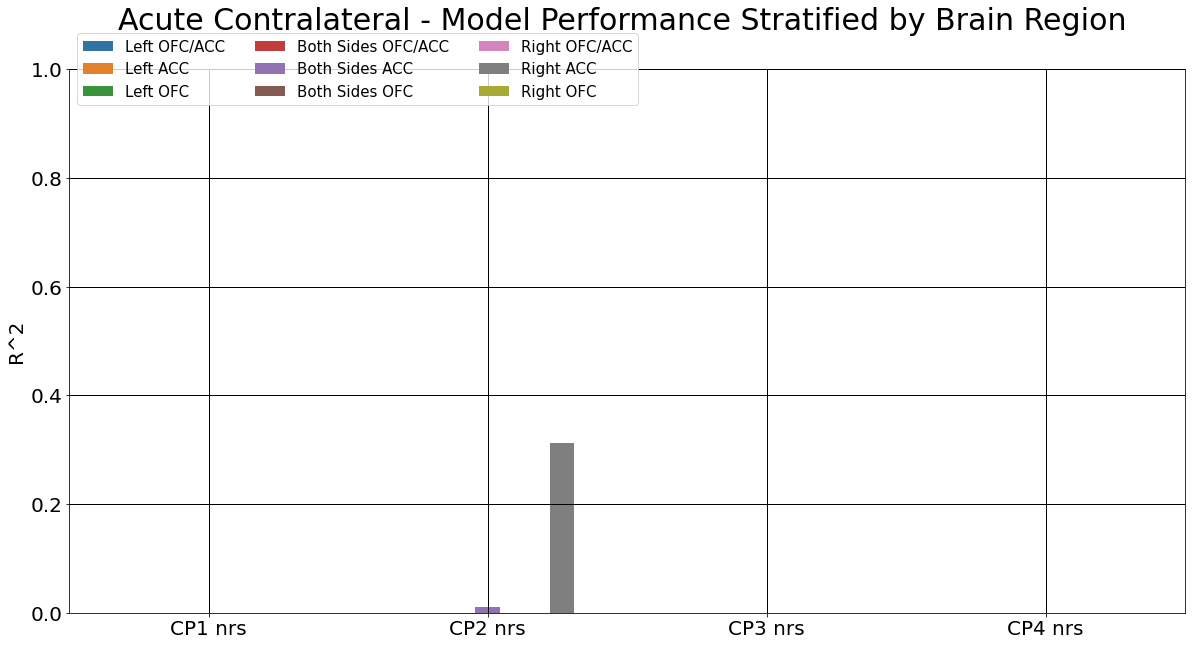

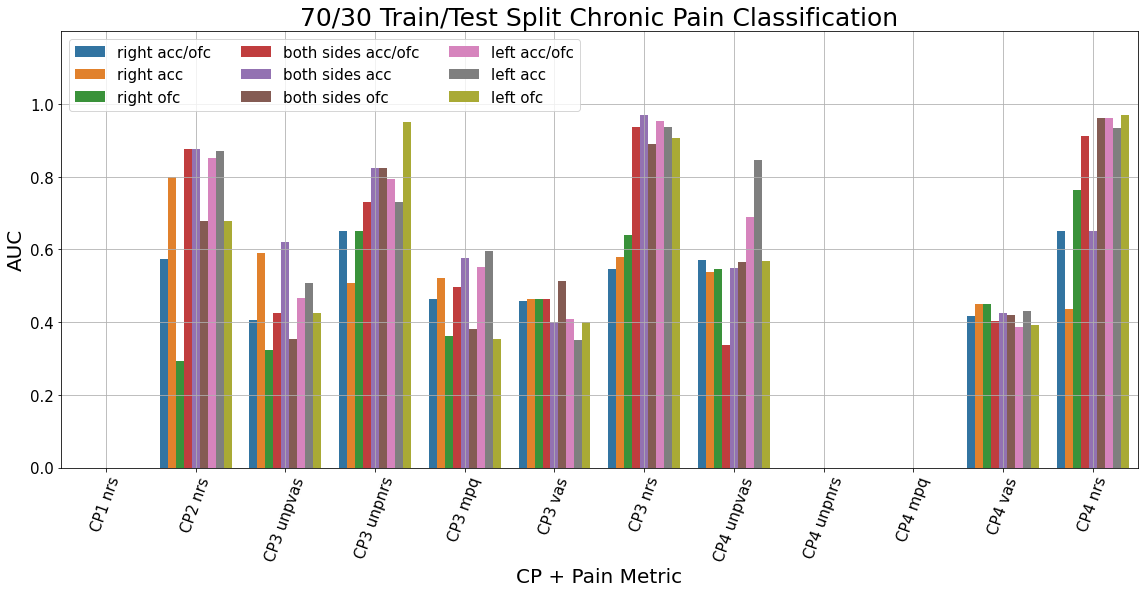

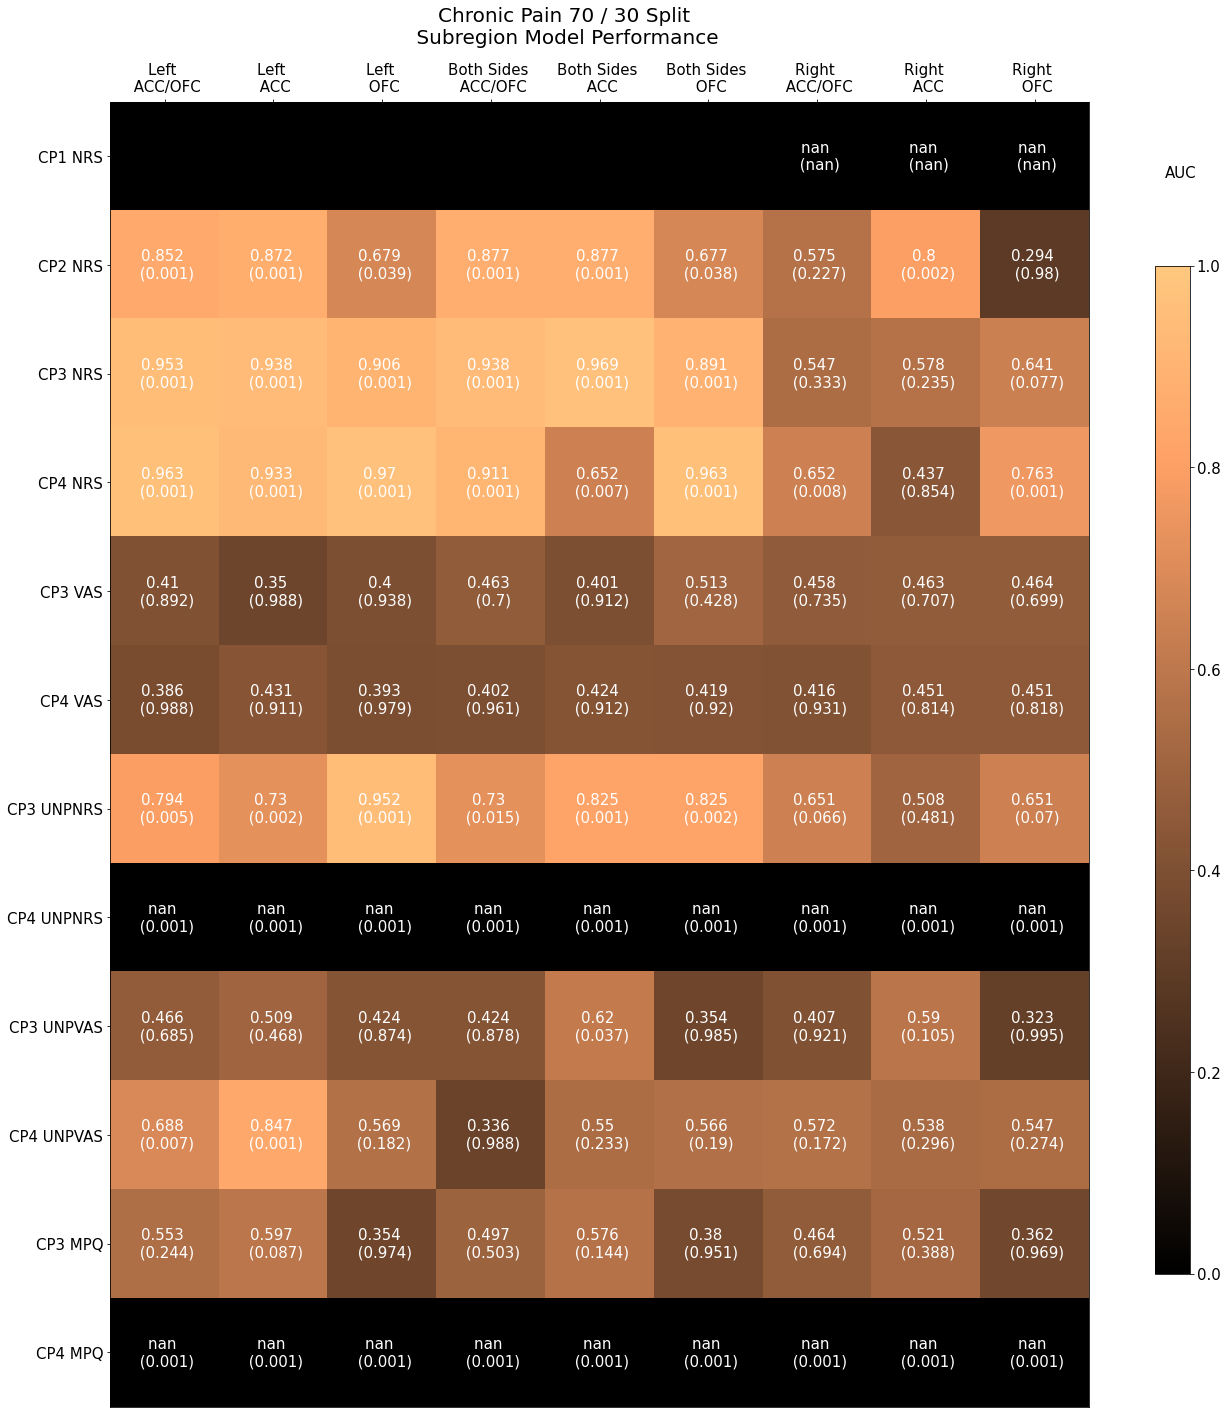

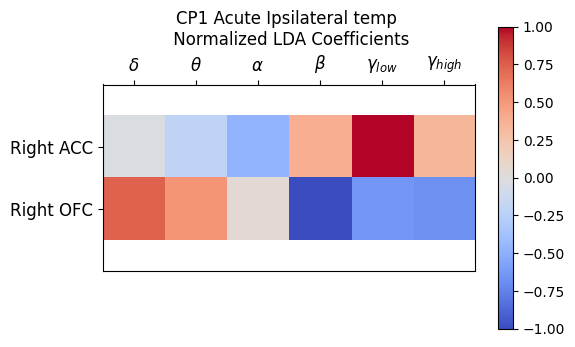

CP1 acute_contra bilateral ofc/acc temp AUC: 0.733333 (p=0.0639361)
optimal threshold: 0.464
sensitivity: 0.700 (0.348, 0.933)
specificity: 0.833 (0.359, 0.996)
ppv: 0.875 (0.473, 0.997)
cohens d: 5.808
accuracy: 0.750 (0.476, 0.927)


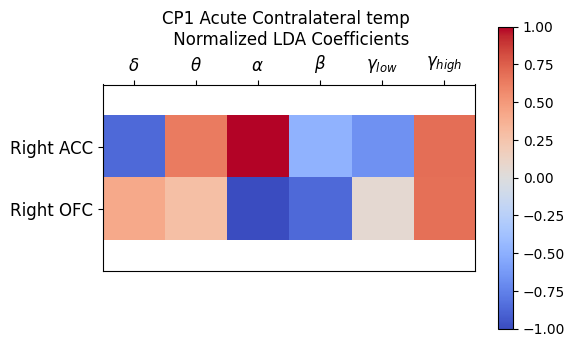

CP2 acute_ipsi bilateral ofc/acc temp AUC: 0.572917 (p=0.230769)
optimal threshold: 0.319
sensitivity: 0.833 (0.516, 0.979)
specificity: 0.500 (0.157, 0.843)
ppv: 0.714 (0.419, 0.916)
cohens d: 4.926
accuracy: 0.700 (0.457, 0.881)


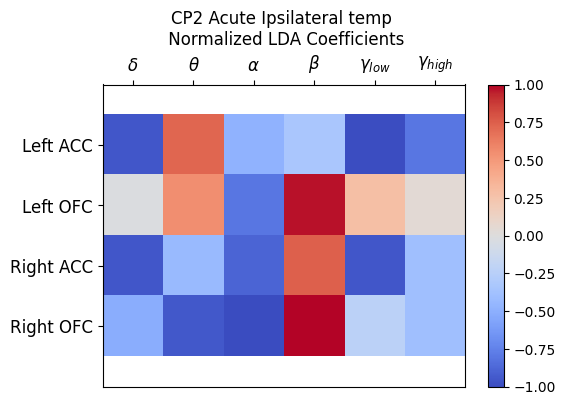

CP2 acute_contra bilateral ofc/acc temp AUC: 0.604167 (p=0.175824)
optimal threshold: 0.953
sensitivity: 0.500 (0.211, 0.789)
specificity: 0.875 (0.473, 0.997)
ppv: 0.857 (0.421, 0.996)
cohens d: 2.637
accuracy: 0.650 (0.408, 0.846)


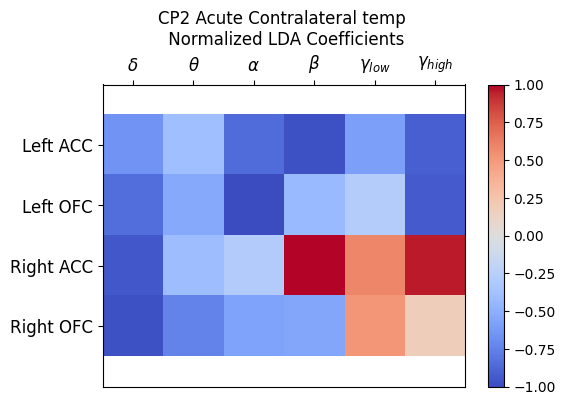

CP3 acute_ipsi bilateral ofc/acc temp AUC: 0.4 (p=0.603397)
optimal threshold: 0.970
sensitivity: 0.200 (0.043, 0.481)
specificity: 0.900 (0.555, 0.997)
ppv: 0.750 (0.194, 0.994)
cohens d: 1.706
accuracy: 0.480 (0.278, 0.687)


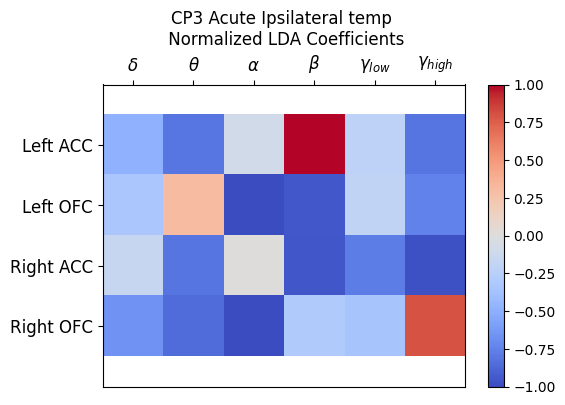

CP3 acute_contra bilateral ofc/acc temp AUC: 0.497738 (p=0.405594)
optimal threshold: 0.958
sensitivity: 0.294 (0.103, 0.560)
specificity: 1.000 (0.753, 1.000)
ppv: 1.000 (0.478, 1.000)
cohens d: 2.260
accuracy: 0.600 (0.406, 0.773)


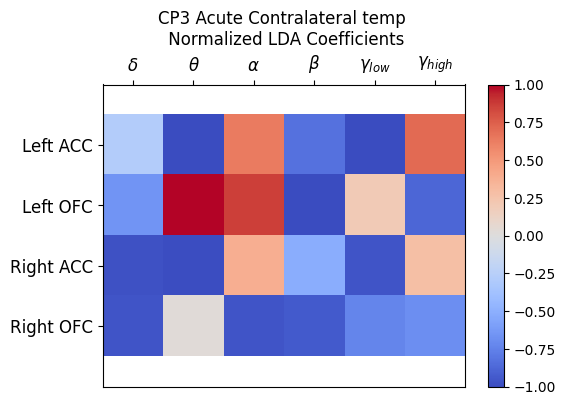

CP4 acute_ipsi bilateral ofc/acc temp AUC: 0.6 (p=0.18981)
optimal threshold: 0.924
sensitivity: 0.533 (0.266, 0.787)
specificity: 0.800 (0.444, 0.975)
ppv: 0.800 (0.444, 0.975)
cohens d: 2.476
accuracy: 0.640 (0.425, 0.820)


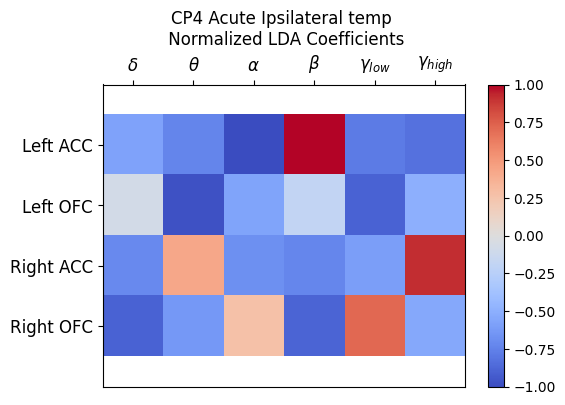

CP4 acute_contra bilateral ofc/acc temp AUC: 0.76 (p=0.024975)
optimal threshold: 0.848
sensitivity: 0.733 (0.449, 0.922)
specificity: 0.900 (0.555, 0.997)
ppv: 0.917 (0.615, 0.998)
cohens d: 3.078
accuracy: 0.800 (0.593, 0.932)


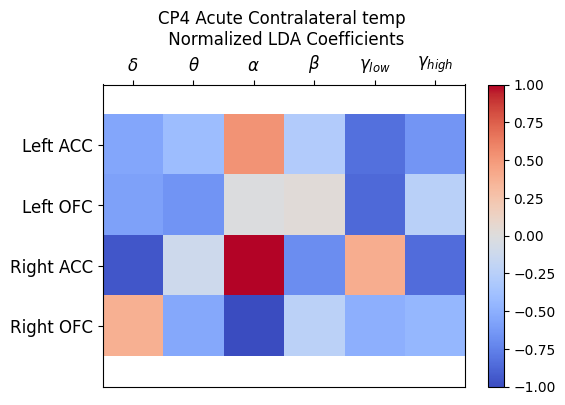

In [34]:
def compute_optimal_metrics(raw_preds, gts):
    fpr, tpr, thresh = roc_curve(gts, raw_preds)
    margins = tpr - fpr
    optimal_idx = np.argmax(margins)
    optimal_thresh = thresh[optimal_idx]
    preds = np.copy(raw_preds)
    preds[preds >= optimal_thresh] = 1.0
    preds[preds < optimal_thresh] = 0.0
    
    def conf_matrix(gts, preds):
        TP = 0
        FP = 0
        TN = 0
        FN = 0
        for i in range(len(preds)): 
            if gts[i]==preds[i]==1:
                TP += 1
            if preds[i]==1 and gts[i]!=preds[i]:
                FP += 1
            if gts[i]==preds[i]==0:
                TN += 1
            if preds[i]==0 and gts[i]!=preds[i]:
                FN += 1
        return TP, FP, TN, FN
    
    def cohen_d(x,y):
        return np.abs((np.mean(x) - np.mean(y)) / \
                np.sqrt((np.std(x, ddof=1) ** 2 + np.std(y, ddof=1) ** 2) / 2.0))
    
    tp, fp, tn, fn = conf_matrix(gts, preds)
    sens = tp / np.sum(gts)
    spec = tn / (len(gts) - np.sum(gts))
    ppv = tp / np.sum(preds)
    d_prime = cohen_d(np.array(raw_preds)[preds == 0.0], np.array(raw_preds)[preds == 1.0])
    acc = (tp + tn) / len(gts)
    
    sens_lb, sens_ub = proportion_confint(tp, np.sum(gts), method='beta')
    spec_lb, spec_ub = proportion_confint(tn, len(gts) - np.sum(gts), method='beta')
    ppv_lb, ppv_ub = proportion_confint(tp, np.sum(preds), method='beta')
    acc_lb, acc_ub = proportion_confint(tp+tn, len(gts), method='beta')
    print('optimal threshold: {:.3f}'.format(optimal_thresh))
    print('sensitivity: {:.3f} ({:.3f}, {:.3f})'.format(sens, sens_lb, sens_ub))
    print('specificity: {:.3f} ({:.3f}, {:.3f})'.format(spec, spec_lb, spec_ub))
    print('ppv: {:.3f} ({:.3f}, {:.3f})'.format(ppv, ppv_lb, ppv_ub))
    print('cohens d: {:.3f}'.format(d_prime))
    print('accuracy: {:.3f} ({:.3f}, {:.3f})'.format(acc, acc_lb, acc_ub))
    
    return np.around([optimal_thresh,
                      sens, sens_lb, sens_ub,
                      spec, spec_lb, spec_ub,
                      ppv, ppv_lb, ppv_ub,
                      d_prime, acc, acc_lb, acc_ub], 3)

# BELOW ACUTALLY RUN THE TEMPERATURE DECODING

### CP1
cp1_acute_ipsi_auc, cp1_acute_ipsi_perm_auc, cp1_acute_ipsi_p, cp1_acute_ipsi_lda, cp1_acute_ipsi_shap = classify_pain(
    cp='CP1', X=cp1_acute_ipsi_features, Y=cp1_acute_ipsi_labels, save_preds_vs_gts=True,
    pain_metric='temp', acute_or_chronic='acute_ipsi', n_permutations=N_PERMUTATIONS,
    compute_all_metrics=True, save_lda_coefs=True)
plot_heatmap_of_lda_coeffs(np.mean(np.abs(cp1_acute_ipsi_lda), axis=0), 'CP1', 'Acute Ipsilateral', 'temp')

cp1_acute_contra_auc, cp1_acute_contra_perm_auc, cp1_acute_contra_p, cp1_acute_contra_lda, cp1_acute_contra_shap = classify_pain(
    cp='CP1', X=cp1_acute_contra_features, Y=cp1_acute_contra_labels, save_preds_vs_gts=True,
    pain_metric='temp', acute_or_chronic='acute_contra', n_permutations=N_PERMUTATIONS,
    compute_all_metrics=True, save_lda_coefs=True)
plot_heatmap_of_lda_coeffs(np.mean(np.abs(cp1_acute_contra_lda), axis=0), 'CP1', 'Acute Contralateral', 'temp')


### CP2
cp2_acute_ipsi_auc, cp2_acute_ipsi_perm_auc, cp2_acute_ipsi_p, cp2_acute_ipsi_lda, cp2_acute_ipsi_shap = classify_pain(
    cp='CP2', X=cp2_acute_ipsi_features, Y=cp2_acute_ipsi_labels, save_preds_vs_gts=True,
    pain_metric='temp', acute_or_chronic='acute_ipsi', n_permutations=N_PERMUTATIONS,
    compute_all_metrics=True,  save_lda_coefs=True)
plot_heatmap_of_lda_coeffs(np.mean(np.abs(cp2_acute_ipsi_lda), axis=0), 'CP2', 'Acute Ipsilateral', 'temp')

cp2_acute_contra_auc, cp2_acute_contra_perm_auc, cp2_acute_contra_p, cp2_acute_contra_lda, cp2_acute_contra_shap = classify_pain(
    cp='CP2', X=cp2_acute_contra_features, Y=cp2_acute_contra_labels, save_preds_vs_gts=True,
    pain_metric='temp', acute_or_chronic='acute_contra', n_permutations=N_PERMUTATIONS,
    compute_all_metrics=True, save_lda_coefs=True)
plot_heatmap_of_lda_coeffs(np.mean(np.abs(cp2_acute_contra_lda), axis=0), 'CP2', 'Acute Contralateral', 'temp')


### CP3
cp3_acute_ipsi_auc, cp3_acute_ipsi_perm_auc, cp3_acute_ipsi_p, cp3_acute_ipsi_lda, cp3_acute_ipsi_shap = classify_pain(
    cp='CP3', X=cp3_acute_ipsi_features, Y=cp3_acute_ipsi_labels, save_preds_vs_gts=True,
    pain_metric='temp', acute_or_chronic='acute_ipsi', n_permutations=N_PERMUTATIONS,
    compute_all_metrics=True, save_lda_coefs=True)
plot_heatmap_of_lda_coeffs(np.mean(np.abs(cp3_acute_ipsi_lda), axis=0), 'CP3', 'Acute Ipsilateral', 'temp')

cp3_acute_contra_auc, cp3_acute_contra_perm_auc, cp3_acute_contra_p, cp3_acute_contra_lda, cp3_acute_contra_shap = classify_pain(
    cp='CP3', X=cp3_acute_contra_features, Y=cp3_acute_contra_labels, save_preds_vs_gts=True,
    pain_metric='temp', acute_or_chronic='acute_contra', n_permutations=N_PERMUTATIONS,
    compute_all_metrics=True,  save_lda_coefs=True)
plot_heatmap_of_lda_coeffs(np.mean(np.abs(cp3_acute_contra_lda), axis=0), 'CP3', 'Acute Contralateral', 'temp')



### CP4
cp4_acute_ipsi_auc, cp4_acute_ipsi_perm_auc, cp4_acute_ipsi_p, cp4_acute_ipsi_lda, cp4_acute_ipsi_shap = classify_pain(
    cp='CP4', X=cp4_acute_ipsi_features, Y=cp4_acute_ipsi_labels, save_preds_vs_gts=True,
    pain_metric='temp', acute_or_chronic='acute_ipsi', n_permutations=N_PERMUTATIONS,
    compute_all_metrics=True,  save_lda_coefs=True)
plot_heatmap_of_lda_coeffs(np.mean(np.abs(cp4_acute_ipsi_lda), axis=0), 'CP4', 'Acute Ipsilateral', 'temp')

cp4_acute_contra_auc, cp4_acute_contra_perm_auc, cp4_acute_contra_p, cp4_acute_contra_lda, cp4_acute_contra_shap = classify_pain(
    cp='CP4', X=cp4_acute_contra_features, Y=cp4_acute_contra_labels, save_preds_vs_gts=True,
    pain_metric='temp', acute_or_chronic='acute_contra', n_permutations=N_PERMUTATIONS,
    compute_all_metrics=True,  save_lda_coefs=True)
plot_heatmap_of_lda_coeffs(np.mean(np.abs(cp4_acute_contra_lda), axis=0), 'CP4', 'Acute Contralateral', 'temp')

In [35]:
cp1_acute_contra_result = pd.read_csv(BASE_PATH + '/pcs_exports/CP1_acute_contra_temp_LDA_all_metrics.csv').iloc[:, 1:]
cp2_acute_contra_result = pd.read_csv(BASE_PATH + '/pcs_exports/CP2_acute_contra_temp_LDA_all_metrics.csv').iloc[:, 1:]
cp3_acute_contra_result = pd.read_csv(BASE_PATH + '/pcs_exports/CP3_acute_contra_temp_LDA_all_metrics.csv').iloc[:, 1:]
cp4_acute_contra_result = pd.read_csv(BASE_PATH + '/pcs_exports/CP4_acute_contra_temp_LDA_all_metrics.csv').iloc[:, 1:]

cp1_acute_ipsi_result = pd.read_csv(BASE_PATH + '/pcs_exports/CP1_acute_ipsi_temp_LDA_all_metrics.csv').iloc[:, 1:]
cp2_acute_ipsi_result = pd.read_csv(BASE_PATH + '/pcs_exports/CP2_acute_ipsi_temp_LDA_all_metrics.csv').iloc[:, 1:]
cp3_acute_ipsi_result = pd.read_csv(BASE_PATH + '/pcs_exports/CP3_acute_ipsi_temp_LDA_all_metrics.csv').iloc[:, 1:]
cp4_acute_ipsi_result = pd.read_csv(BASE_PATH + '/pcs_exports/CP4_acute_ipsi_temp_LDA_all_metrics.csv').iloc[:, 1:]

In [36]:
result_idx = ['cp1 acute contra temp', 'cp2 acute contra temp',  'cp3 acute contra temp',
              'cp4 acute contra temp', 'cp1 acute ipsi temp', 'cp2 acute ipsi temp',
              'cp3 acute ipsi temp', 'cp4 acute ipsi temp',]

all_results = pd.concat([cp1_acute_contra_result, cp2_acute_contra_result, cp3_acute_contra_result,
                        cp4_acute_contra_result, cp1_acute_ipsi_result, cp2_acute_ipsi_result, 
                        cp3_acute_ipsi_result, cp4_acute_ipsi_result])
all_results.index = result_idx                        
all_results.to_csv(BASE_PATH + '/pcs_exports/acute_temp_decoding_all_metrics_results.csv')
all_results

,threshold,sensitivity,specificity,ppv,cohens d,auc (p-value),accuracy
cp1 acute contra temp,0.464,"0.7 (0.348, 0.933)","0.833 (0.359, 0.996)","0.875 (0.473, 0.997)",5.808,0.733 (0.064),"0.75 (0.476, 0.927)"
cp2 acute contra temp,0.953,"0.5 (0.211, 0.789)","0.875 (0.473, 0.997)","0.857 (0.421, 0.996)",2.637,0.604 (0.176),"0.65 (0.408, 0.846)"
cp3 acute contra temp,0.958,"0.294 (0.103, 0.56)","1.0 (0.753, 1.0)","1.0 (0.478, 1.0)",2.260,0.498 (0.406),"0.6 (0.406, 0.773)"
cp4 acute contra temp,0.848,"0.733 (0.449, 0.922)","0.9 (0.555, 0.997)","0.917 (0.615, 0.998)",3.078,0.76 (0.025),"0.8 (0.593, 0.932)"
cp1 acute ipsi temp,0.889,"0.444 (0.137, 0.788)","0.75 (0.194, 0.994)","0.8 (0.284, 0.995)",1.935,0.444 (0.36),"0.538 (0.251, 0.808)"
cp2 acute ipsi temp,0.319,"0.833 (0.516, 0.979)","0.5 (0.157, 0.843)","0.714 (0.419, 0.916)",4.926,0.573 (0.231),"0.7 (0.457, 0.881)"
cp3 acute ipsi temp,0.970,"0.2 (0.043, 0.481)","0.9 (0.555, 0.997)","0.75 (0.194, 0.994)",1.706,0.4 (0.603),"0.48 (0.278, 0.687)"
cp4 acute ipsi temp,0.924,"0.533 (0.266, 0.787)","0.8 (0.444, 0.975)","0.8 (0.444, 0.975)",2.476,0.6 (0.19),"0.64 (0.425, 0.82)"


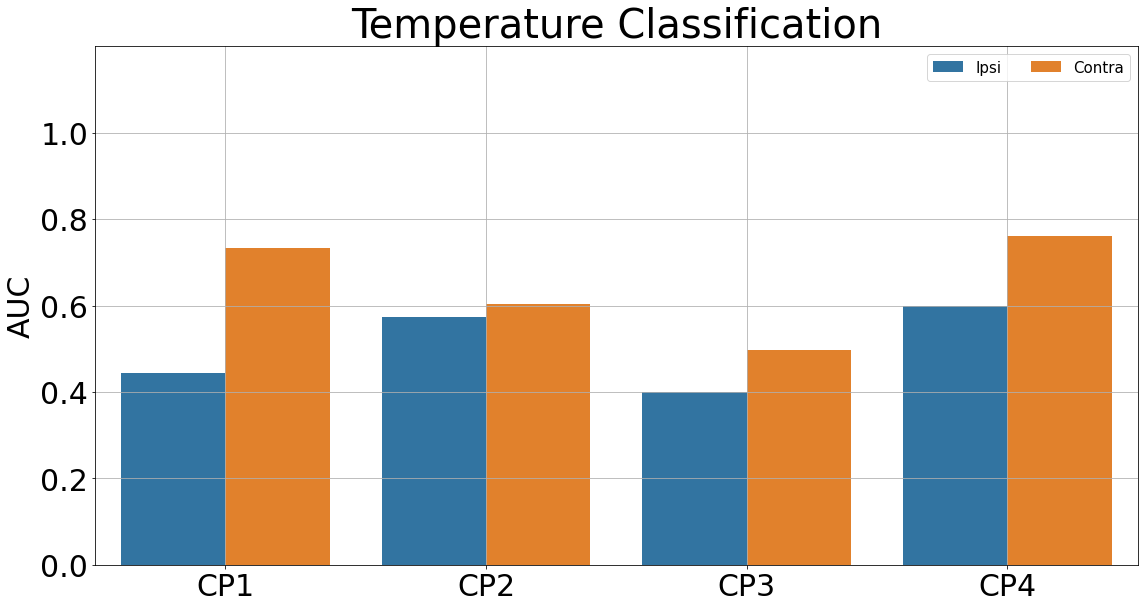

In [37]:
# Calculate and save the temperature decoding LDA heatmap
aucs = [cp1_acute_ipsi_auc, cp1_acute_contra_auc,
        cp2_acute_ipsi_auc, cp2_acute_contra_auc,
        cp3_acute_ipsi_auc, cp3_acute_contra_auc, 
        cp4_acute_ipsi_auc, cp4_acute_contra_auc]
ps = [cp1_acute_ipsi_p, cp1_acute_contra_p,
      cp2_acute_ipsi_p, cp2_acute_contra_p,
      cp3_acute_ipsi_p, cp3_acute_contra_p, 
    cp4_acute_ipsi_p, cp4_acute_contra_p]
side = ['Ipsi', 'Contra', 'Ipsi', 'Contra', 'Ipsi', 'Contra', 'Ipsi', 'Contra']
cps = ['CP1', 'CP1', 'CP2', 'CP2', 'CP3', 'CP3', 'CP4', 'CP4']
data_long = pd.DataFrame([aucs, ps, side, cps]).T
data_long.columns = ['AUC', 'p', 'Side', 'CP']

# barplot
plt.figure(figsize=(16, 8))
sns.barplot(x="CP",
            y="AUC",
            hue="Side",
            data=data_long)
plt.legend(fontsize=15, ncol=3)
plt.ylabel('AUC', size=20)
plt.xlabel('Temperature', size=20)
plt.ylim(0, 1.2)
plt.yticks([0, 0.2, 0.4, 0.6, 0.8, 1.0], size=30)
plt.xticks(size=30)
plt.ylabel('AUC', size=30)
plt.xlabel('', size=30)
plt.grid()
plt.tight_layout()
plt.title('Temperature Classification', size=40)
plt.savefig(BASE_PATH + '/pdf_figures/temperature_classification_barplot.pdf',
          bbox_inches='tight', dpi=400)
plt.show()

# heatmap
aucs = np.array(aucs).reshape(4, 2)
ps = np.array(ps).reshape(4, 2)

plt.figure()
fig, ax = plt.subplots(figsize=(14, 6))
im = ax.imshow(np.array(aucs).reshape(4, 2),
               cmap='copper', vmin=0, vmax=1)
cbar = fig.colorbar(im, cax = fig.add_axes([0.65, 0.15, 0.03, 0.7]))
cbar.ax.tick_params(labelsize=15) 
cbar.set_label('AUC', size=15, y=1.1, labelpad=-40, rotation=0)
ax.set_xticks(np.arange(2))
ax.set_xticklabels(['Ipsi', 'Contra'], size=15)
ax.xaxis.tick_top()
ax.set_yticks(np.arange(4))
ax.set_yticklabels(['CP1', 'CP2', 'CP3', 'CP4'], size=15)
ax.set_ylim(4-0.5, -0.5)
ax.set_title('Temperature Classification', size=20, y=1.1)
for i in range(aucs.shape[0]):
    for j in range(aucs.shape[1]):
        text = ax.text(j, i, '{} \n ({})'.format(np.round(aucs[i, j], 3),
                                                    np.round(ps[i, j], 3)),
                       ha="center", va="center", color="w", size=15)
plt.savefig(BASE_PATH + '/pdf_figures/temperature_classification_heatmap.pdf',
          bbox_inches='tight', dpi=400)

# Train on Chronic, Test on Acute... and Vice Versa

In [38]:
def train_and_test_full_models(chronic_features,
                               chronic_labels,
                               acute_features,
                               acute_labels,
                               n_permutations,
                               CP,
                               acute_to_acute=False):
    
    print('-------> Working on {}...'.format(CP))
    
    ##### Train on chronic, test on acute #####
    if not acute_to_acute:
        print('\n ------------------ Chronic ---> Acute')
    else:
        print('\n ------------------ Acute Ipsi ---> Acute Contra')
    X_acute, Y_acute = prepare_x_y(acute_features, acute_labels, 'pain', CP=CP)
    if not acute_to_acute:
        X_chronic, Y_chronic = prepare_x_y(chronic_features, chronic_labels, 'nrs', CP=CP)
    else:
        X_chronic, Y_chronic = prepare_x_y(chronic_features, chronic_labels, 'pain', CP=CP)
    chronic_scaler = StandardScaler()
    X_chronic = chronic_scaler.fit_transform(X_chronic)
    X_acute = chronic_scaler.transform(X_acute)
    
    if CP == 'CP1':
        chronic_clf = LinearDiscriminantAnalysis(solver='lsqr', shrinkage=1) #for CP1 dont use shrinkage (pseudolinear)
    else:        
        chronic_clf = LinearDiscriminantAnalysis(solver='lsqr', shrinkage='auto') 
    chronic_clf.fit(X_chronic, Y_chronic)
    acute_preds = chronic_clf.predict_proba(X_acute)[:, 1]
    chronic_to_acute_auc = roc_auc_score(Y_acute, acute_preds)
    
    permutation_aucs_1 = []
    for _ in range(n_permutations):
        np.random.shuffle(Y_chronic)
        if CP == 'CP1':
            perm_clf = LinearDiscriminantAnalysis(solver='lsqr', shrinkage=1) #for CP1 dont use shrinkage (pseudolinear)
        else:        
            perm_clf = LinearDiscriminantAnalysis(solver='lsqr', shrinkage='auto') 
        perm_clf.fit(X_chronic, Y_chronic)
        perm_acute_preds = perm_clf.predict_proba(X_acute)[:, 1]
        permutation_aucs_1.append(roc_auc_score(Y_acute, perm_acute_preds))
    p_val_k = sum(i > chronic_to_acute_auc for i in permutation_aucs_1)
    p_val_n = len(permutation_aucs_1)
    chronic_to_acute_p = (p_val_k+1) / (p_val_n+1)
    if not acute_to_acute:
        print('{} chronic to acute auc: {:g} (p={:g})'.format(CP, chronic_to_acute_auc, chronic_to_acute_p))
    else:
        print('{} acute ipsi to acute contra auc: {:g} (p={:g})'.format(CP, chronic_to_acute_auc, chronic_to_acute_p))
        
    ##### Train on acute, test on chronic #####
    if not acute_to_acute: 
        print('------------------ Acute ---> Chronic')
    else:
        print('\n ------------------ Acute Contra ---> Acute Ipsi')    
    X_acute, Y_acute = prepare_x_y(acute_features, acute_labels, 'pain', CP=CP)
    if not acute_to_acute:
        X_chronic, Y_chronic = prepare_x_y(chronic_features, chronic_labels, 'nrs', CP=CP)
    else:
        X_chronic, Y_chronic = prepare_x_y(chronic_features, chronic_labels, 'pain', CP=CP)
    acute_scaler = StandardScaler()
    X_acute = acute_scaler.fit_transform(X_acute)
    X_chronic = acute_scaler.transform(X_chronic)
    
    acute_clf = LinearDiscriminantAnalysis(solver='lsqr', shrinkage='auto', priors=np.array([0.5, 0.5]))
    acute_clf.fit(X_acute, Y_acute)
    chronic_preds = acute_clf.predict_proba(X_chronic)[:, 1]
    acute_to_chronic_auc = roc_auc_score(Y_chronic, chronic_preds)
    
    permutation_aucs_2 = []
    for _ in range(n_permutations):
        np.random.shuffle(Y_acute)
        if CP == 'CP1':
            perm_clf = LinearDiscriminantAnalysis(solver='lsqr', shrinkage=1) #for CP1 dont use shrinkage (pseudolinear)
        else:        
            perm_clf = LinearDiscriminantAnalysis(solver='lsqr', shrinkage='auto') 
        perm_clf.fit(X_acute, Y_acute)
        perm_chronic_preds = perm_clf.predict_proba(X_chronic)[:, 1]
        permutation_aucs_2.append(roc_auc_score(Y_chronic, perm_chronic_preds))
    p_val_k = sum(i > acute_to_chronic_auc for i in permutation_aucs_2)
    p_val_n = len(permutation_aucs_2)
    acute_to_chronic_p = (p_val_k+1) / (p_val_n+1)
    if not acute_to_acute:
        print('{} acute to chronic auc: {:g} (p={:g})'.format(CP, acute_to_chronic_auc, acute_to_chronic_p))
    else:
        print('{} acute contra to acute ipsi auc: {:g} (p={:g})'.format(CP, acute_to_chronic_auc, acute_to_chronic_p))
    permutation_aucs_cta, permutation_aucs_atc = permutation_aucs_1, permutation_aucs_2
    return chronic_to_acute_auc, chronic_to_acute_p, acute_to_chronic_auc, acute_to_chronic_p, permutation_aucs_cta, permutation_aucs_atc

In [39]:
# All Acute  - Run the Analyses
print('@'*10 + ' All Acute ' + '@'*10)
cp1_cta_all_auc, cp1_cta_all_p, cp1_atc_all_auc, cp1_atc_all_p, cp1_cta_perm_aucs, cp1_atc_perm_aucs = train_and_test_full_models(cp1_chronic_features,
                           cp1_chronic_labels,
                           cp1_acute_features,
                           cp1_acute_labels,
                           n_permutations=N_PERMUTATIONS,
                           CP='CP1')

cp2_cta_all_auc, cp2_cta_all_p, cp2_atc_all_auc, cp2_atc_all_p, cp2_cta_perm_aucs, cp2_atc_perm_aucs  = train_and_test_full_models(cp2_chronic_features,
                           cp2_chronic_labels,
                           cp2_acute_features,
                           cp2_acute_labels,
                           n_permutations=N_PERMUTATIONS, 
                           CP='CP2')

cp3_cta_all_auc, cp3_cta_all_p, cp3_atc_all_auc, cp3_atc_all_p, cp3_cta_perm_aucs, cp3_atc_perm_aucs  = train_and_test_full_models(cp3_chronic_features,
                           cp3_chronic_labels,
                           cp3_acute_features,
                           cp3_acute_labels,
                           n_permutations=N_PERMUTATIONS,
                           CP='CP3')

cp4_cta_all_auc, cp4_cta_all_p, cp4_atc_all_auc, cp4_atc_all_p, cp4_cta_perm_aucs, cp4_atc_perm_aucs = train_and_test_full_models(cp4_chronic_features,
                           cp4_chronic_labels,
                           cp4_acute_ipsi_features,
                           cp4_acute_ipsi_labels,
                           n_permutations=N_PERMUTATIONS,
                           CP='CP4')

# Ipsi Acute
print('@'*10 + ' Ipsi Acute ' + '@'*10)
cp1_cta_ipsi_auc, cp1_cta_ipsi_p, cp1_atc_ipsi_auc, cp1_atc_ipsi_p, cp1_cta_ipsi_perm_aucs, cp1_atc_ipsi_perm_aucs = train_and_test_full_models(cp1_chronic_features,
                           cp1_chronic_labels,
                           cp1_acute_ipsi_features,
                           cp1_acute_ipsi_labels,
                           n_permutations=N_PERMUTATIONS,
                           CP='CP1')

cp2_cta_ipsi_auc, cp2_cta_ipsi_p, cp2_atc_ipsi_auc, cp2_atc_ipsi_p, cp2_cta_ipsi_perm_aucs, cp2_atc_ipsi_perm_aucs = train_and_test_full_models(cp2_chronic_features,
                           cp2_chronic_labels,
                           cp2_acute_ipsi_features,
                           cp2_acute_ipsi_labels,
                           n_permutations=N_PERMUTATIONS,
                           CP='CP2')

cp3_cta_ipsi_auc, cp3_cta_ipsi_p, cp3_atc_ipsi_auc, cp3_atc_ipsi_p, cp3_cta_ipsi_perm_aucs, cp3_atc_ipsi_perm_aucs = train_and_test_full_models(cp3_chronic_features,
                           cp3_chronic_labels,
                           cp3_acute_ipsi_features,
                           cp3_acute_ipsi_labels,
                           n_permutations=N_PERMUTATIONS,
                           CP='CP3')


cp4_cta_ipsi_auc, cp4_cta_ipsi_p, cp4_atc_ipsi_auc, cp4_atc_ipsi_p, cp4_cta_ipsi_perm_aucs, cp4_atc_ipsi_perm_aucs = train_and_test_full_models(cp4_chronic_features,
                           cp4_chronic_labels,
                           cp4_acute_ipsi_features,
                           cp4_acute_ipsi_labels,
                           n_permutations=N_PERMUTATIONS,
                           CP='CP4')

# Contra Acute
print('@'*10 + ' Contra Acute ' + '@'*10)
cp1_cta_contra_auc, cp1_cta_contra_p, cp1_atc_contra_auc, cp1_atc_contra_p, cp1_cta_contra_perm_aucs, cp1_atc_contra_perm_aucs = train_and_test_full_models(cp1_chronic_features,
                           cp1_chronic_labels,
                           cp1_acute_contra_features,
                           cp1_acute_contra_labels,
                           n_permutations=N_PERMUTATIONS,
                           CP='CP1')

cp2_cta_contra_auc, cp2_cta_contra_p, cp2_atc_contra_auc, cp2_atc_contra_p, cp2_cta_contra_perm_aucs, cp2_atc_contra_perm_aucs = train_and_test_full_models(cp2_chronic_features,
                           cp2_chronic_labels,
                           cp2_acute_contra_features,
                           cp2_acute_contra_labels,
                           n_permutations=N_PERMUTATIONS, 
                           CP='CP2')

cp3_cta_contra_auc, cp3_cta_contra_p, cp3_atc_contra_auc, cp3_atc_contra_p, cp3_cta_contra_perm_aucs, cp3_atc_contra_perm_aucs = train_and_test_full_models(cp3_chronic_features,
                           cp3_chronic_labels,
                           cp3_acute_contra_features,
                           cp3_acute_contra_labels,
                           n_permutations=N_PERMUTATIONS, 
                           CP='CP3')

cp4_cta_contra_auc, cp4_cta_contra_p, cp4_atc_contra_auc, cp4_atc_contra_p, cp4_cta_contra_perm_aucs, cp4_atc_contra_perm_aucs = train_and_test_full_models(cp4_chronic_features,
                           cp4_chronic_labels,
                           cp4_acute_contra_features,
                           cp4_acute_contra_labels,
                           n_permutations=N_PERMUTATIONS,
                           CP='CP4')

@@@@@@@@@@ All Acute @@@@@@@@@@
-------> Working on CP1...

 ------------------ Chronic ---> Acute
CP1 chronic to acute auc: 0.619048 (p=0.138861)
------------------ Acute ---> Chronic
CP1 acute to chronic auc: 0.601744 (p=0.245754)
-------> Working on CP2...

 ------------------ Chronic ---> Acute
CP2 chronic to acute auc: 0.708791 (p=0.023976)
------------------ Acute ---> Chronic
CP2 acute to chronic auc: 0.729575 (p=0.017982)
-------> Working on CP3...

 ------------------ Chronic ---> Acute
CP3 chronic to acute auc: 0.607427 (p=0.0949051)
------------------ Acute ---> Chronic
CP3 acute to chronic auc: 0.391754 (p=0.831169)
-------> Working on CP4...

 ------------------ Chronic ---> Acute
CP4 chronic to acute auc: 0.5 (p=0.501499)
------------------ Acute ---> Chronic
CP4 acute to chronic auc: 0.534152 (p=0.401598)
@@@@@@@@@@ Ipsi Acute @@@@@@@@@@
-------> Working on CP1...

 ------------------ Chronic ---> Acute
CP1 chronic to acute auc: 0.47619 (p=0.514486)
------------------ Ac

<Figure size 432x288 with 0 Axes>

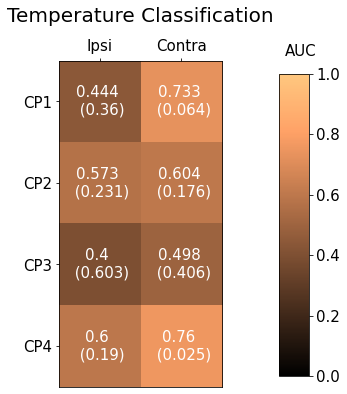

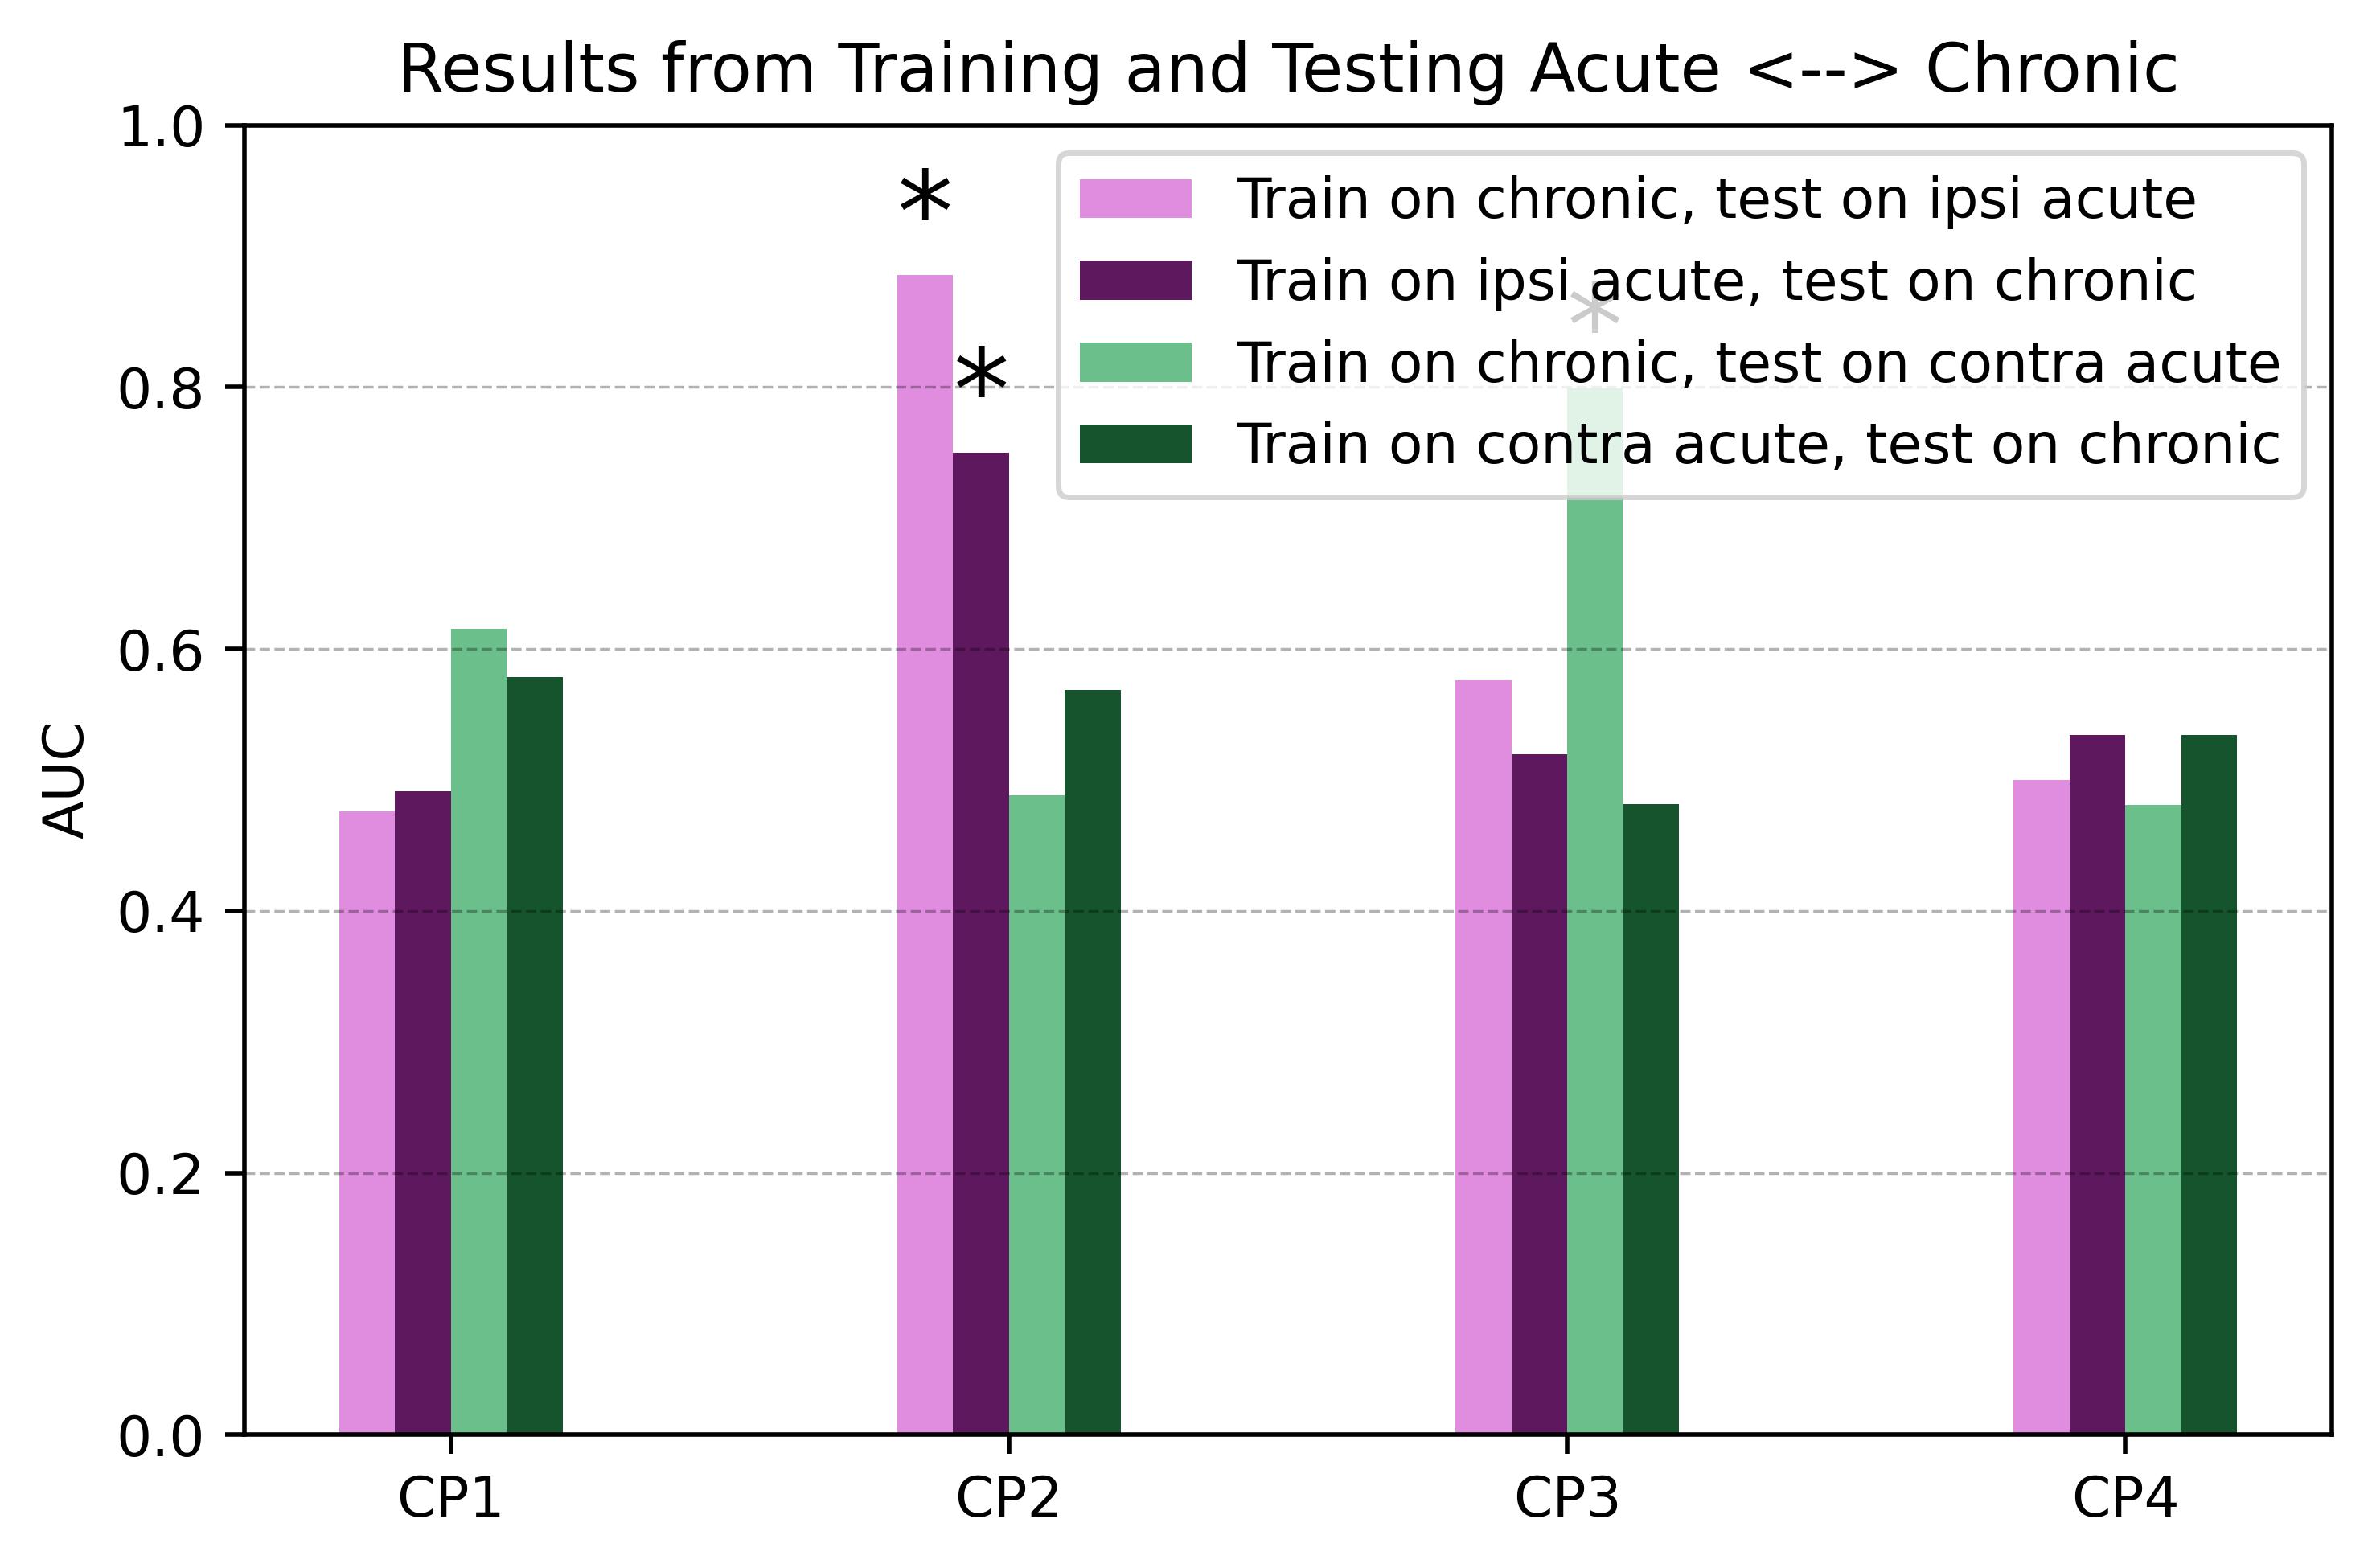

In [40]:
#Plot all the subplots
cp1_aucs = [cp1_cta_all_auc, cp1_atc_all_auc, cp1_cta_ipsi_auc, cp1_atc_ipsi_auc, cp1_cta_contra_auc, cp1_atc_contra_auc]
cp2_aucs = [cp2_cta_all_auc, cp2_atc_all_auc, cp2_cta_ipsi_auc, cp2_atc_ipsi_auc, cp2_cta_contra_auc, cp2_atc_contra_auc]
cp3_aucs = [cp3_cta_all_auc, cp3_atc_all_auc, cp3_cta_ipsi_auc, cp3_atc_ipsi_auc, cp3_cta_contra_auc, cp3_atc_contra_auc]
cp4_aucs = [cp4_cta_all_auc, cp4_atc_all_auc, cp4_cta_ipsi_auc, cp4_atc_ipsi_auc, cp4_cta_contra_auc, cp4_atc_contra_auc]
cp1_ps = [cp1_cta_all_p, cp1_atc_all_p, cp1_cta_ipsi_p, cp1_atc_ipsi_p, cp1_cta_contra_p, cp1_atc_contra_p]
cp2_ps = [cp2_cta_all_p, cp2_atc_all_p, cp2_cta_ipsi_p, cp2_atc_ipsi_p, cp2_cta_contra_p, cp2_atc_contra_p]
cp3_ps = [cp3_cta_all_p, cp3_atc_all_p, cp3_cta_ipsi_p, cp3_atc_ipsi_p, cp3_cta_contra_p, cp3_atc_contra_p]
cp4_ps = [cp4_cta_all_p, cp4_atc_all_p, cp4_cta_ipsi_p, cp4_atc_ipsi_p, cp4_cta_contra_p, cp4_atc_contra_p]
data = np.array([cp1_aucs, cp2_aucs, cp3_aucs, cp4_aucs])
data_p = np.array([cp1_ps, cp2_ps, cp3_ps, cp4_ps])
length = len(data)
x_labels = ['CP1', 'CP2', 'CP3', 'CP4']


fig, ax = plt.subplots(figsize=(6, 4), dpi=500)
width = 0.1
x = np.arange(length)
# rects1 = ax.bar(x, data[:,0], width, color='#4287f5', label='Train on chronic, test on all acute')
# rects2 = ax.bar(x + width, data[:,1], width, color='#0a254f', label='Train on all acute, test on chronic')
rects3 = ax.bar(x + width, data[:,2], width, color='#e08ddf', label='Train on chronic, test on ipsi acute')
rects4 = ax.bar(x + width*2, data[:,3], width, color='#5e195e', label='Train on ipsi acute, test on chronic')
rects5 = ax.bar(x + width*3, data[:,4], width, color='#6bbf8a', label='Train on chronic, test on contra acute')
rects6 = ax.bar(x + width*4, data[:,5], width, color='#15542c', label='Train on contra acute, test on chronic')

# cnt = 0
# for rect in rects1:
#     if data_p[cnt, 0] < 0.05:
#         sig = '*'
#     else: sig = ' '
#     height = rect.get_height()
#     ax.text(rect.get_x() + rect.get_width()/2, height,
#             sig, ha='center', va='bottom', size=20)
#     cnt+=1
    
    
# cnt = 0
# for rect in rects2:
#     if data_p[cnt, 1] < 0.05:
#         sig = '*'
#     else: sig = ' '
#     height = rect.get_height()
#     ax.text(rect.get_x() + rect.get_width()/2, height,
#             sig, ha='center', va='bottom', size=20)
#     cnt+=1
    
cnt = 0
for rect in rects3:
    if data_p[cnt, 2] < 0.05:
        sig = '*'
    else: sig = ' '
    height = rect.get_height()
    ax.text(rect.get_x() + rect.get_width()/2, height,
            sig, ha='center', va='bottom', size=20)
    cnt+=1
    
cnt = 0
for rect in rects4:
    if data_p[cnt, 3] < 0.05:
        sig = '*'
    else: sig = ' '
    height = rect.get_height()
    ax.text(rect.get_x() + rect.get_width()/2, height,
            sig, ha='center', va='bottom', size=20)
    cnt+=1
    
cnt = 0
for rect in rects5:
    if data_p[cnt, 4] < 0.05:
        sig = '*'
    else: sig = ' '
    height = rect.get_height()
    ax.text(rect.get_x() + rect.get_width()/2, height,
            sig, ha='center', va='bottom', size=20)
    cnt+=1
    
cnt = 0
for rect in rects6:
    if data_p[cnt, 5] < 0.05:
        sig = '*'
    else: sig = ' '
    height = rect.get_height()
    ax.text(rect.get_x() + rect.get_width()/2, height,
            sig, ha='center', va='bottom', size=20)
    cnt+=1
    
ax.set_ylabel('AUC')
ax.set_ylim(0.0, 1)
ax.set_xticks(x + width*2.5)
ax.set_xticklabels(x_labels)
ax.set_xlabel('')
ax.set_title('Results from Training and Testing Acute <--> Chronic')
ax.legend(loc=1)
plt.grid(True, 'major', 'y', ls='--', lw=.5, c='k', alpha=.3)

fig.tight_layout()
plt.show()
fig.savefig(BASE_PATH + 'pdf_figures/train_test_acute_chronic.pdf', dpi=1000, format='pdf', bbox_inches = "tight")